# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests THE_MEAN.

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-07 00:13:25.657370
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'THE_MEAN'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-07 00:13:56.657757
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            discrim = np.mean(rci_values)
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-07 00:13:59.666049
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-07 00:14:15.184883
splitting
Fold 1
RCI threshold derived from training set: -0.07263865964057306
FIT
2023-02-07 00:14:18.063800
PREDICT
2023-02-07 00:14:34.101570


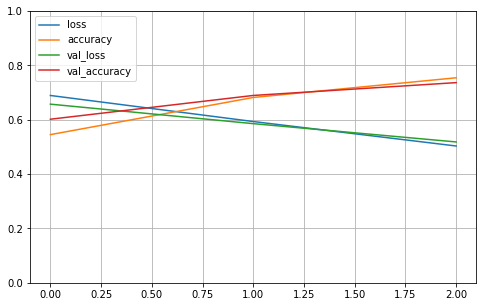

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 452 / 869
Range of scores: 0.0057053855 to 0.98611265
Score threshold 0.5
Prediction set ones/size 459 / 869


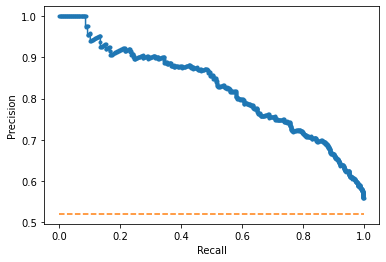

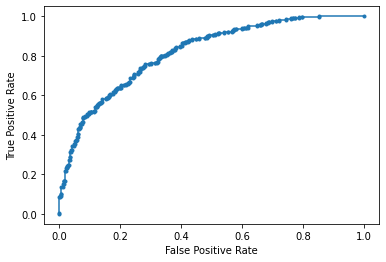

Accuracy: 73.65% Precision: 74.29% Recall: 75.44%
F1: 74.86% AUPRC: 82.44% AUROC: 81.70%
2023-02-07 00:14:34.861018
Fold 2
RCI threshold derived from training set: -0.08890415963673573
FIT
2023-02-07 00:14:38.434518
PREDICT
2023-02-07 00:14:49.681523


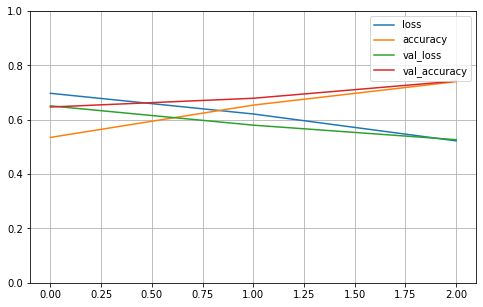

Train set ones/size 4246 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 506 / 869
Range of scores: 0.012673861 to 0.97480893
Score threshold 0.5
Prediction set ones/size 452 / 869


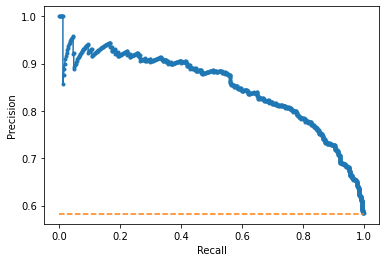

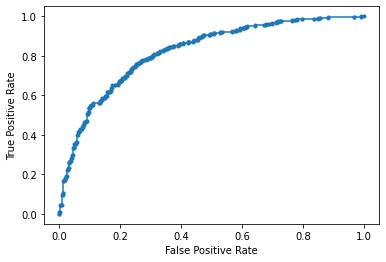

Accuracy: 74.22% Precision: 81.19% Recall: 72.53%
F1: 76.62% AUPRC: 85.04% AUROC: 82.17%
2023-02-07 00:14:50.406033
Fold 3
RCI threshold derived from training set: -0.08061058532361218
FIT
2023-02-07 00:14:54.689742
PREDICT
2023-02-07 00:15:06.303829


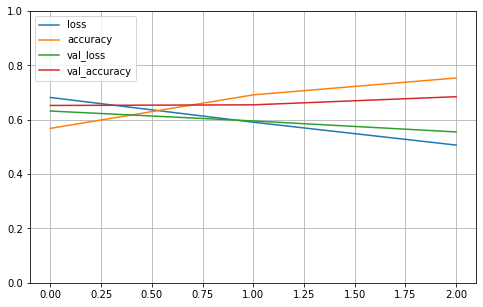

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 461 / 869
Range of scores: 0.005358584 to 0.9845687
Score threshold 0.5
Prediction set ones/size 295 / 869


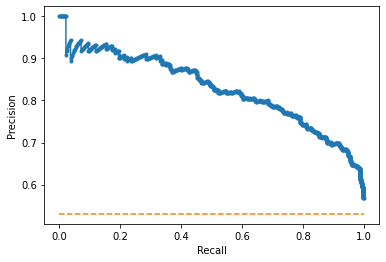

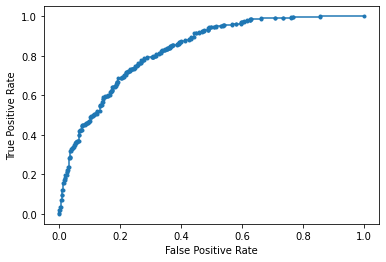

Accuracy: 68.47% Precision: 81.69% Recall: 52.28%
F1: 63.76% AUPRC: 82.86% AUROC: 83.15%
2023-02-07 00:15:07.179663
Fold 4
RCI threshold derived from training set: -0.07163159574827323
FIT
2023-02-07 00:15:11.260861
PREDICT
2023-02-07 00:15:19.440484


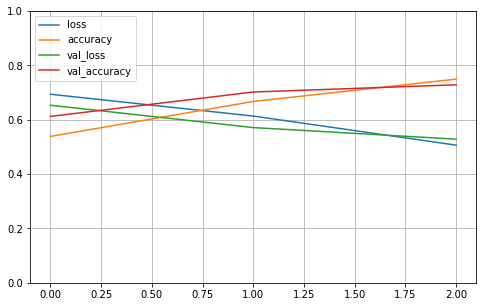

Train set ones/size 4211 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 441 / 869
Range of scores: 0.004272955 to 0.9920803
Score threshold 0.5
Prediction set ones/size 413 / 869


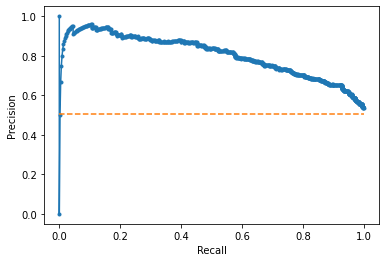

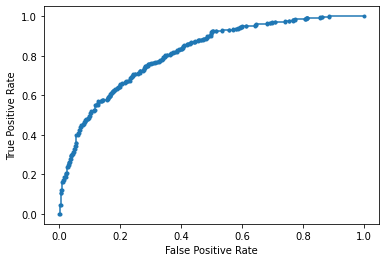

Accuracy: 72.84% Precision: 74.82% Recall: 70.07%
F1: 72.37% AUPRC: 80.50% AUROC: 81.40%
2023-02-07 00:15:20.445572
Fold 5
RCI threshold derived from training set: -0.07909441939498593
FIT
2023-02-07 00:15:24.399395
PREDICT
2023-02-07 00:15:35.680249


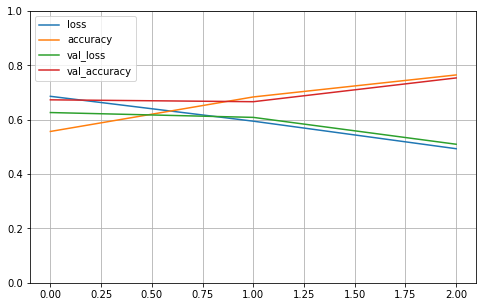

Train set ones/size 4186 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 475 / 869
Range of scores: 0.007839112 to 0.9915935
Score threshold 0.5
Prediction set ones/size 481 / 869


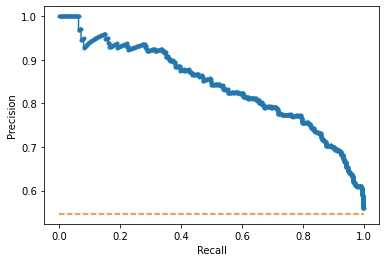

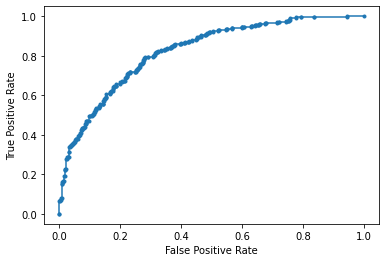

Accuracy: 75.37% Precision: 77.13% Recall: 78.11%
F1: 77.62% AUPRC: 84.18% AUROC: 82.38%
2023-02-07 00:15:36.376986
Fold 6
RCI threshold derived from training set: -0.08340265725249423
FIT
2023-02-07 00:15:39.913446
PREDICT
2023-02-07 00:15:51.170295


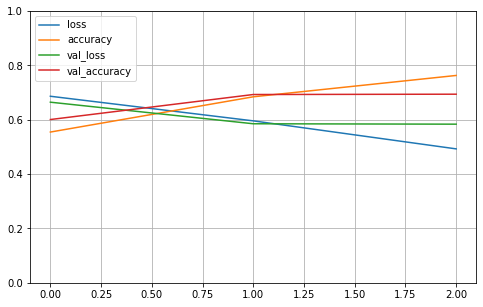

Train set ones/size 4204 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 457 / 869
Range of scores: 0.0075897328 to 0.99688065
Score threshold 0.5
Prediction set ones/size 583 / 869


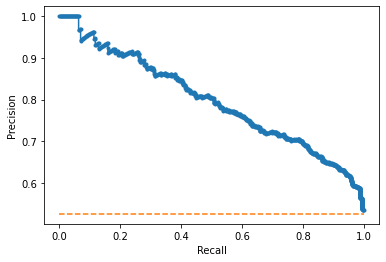

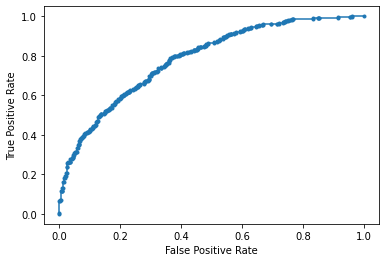

Accuracy: 69.39% Precision: 66.38% Recall: 84.68%
F1: 74.42% AUPRC: 79.87% AUROC: 78.44%
2023-02-07 00:15:51.872975
Fold 7
RCI threshold derived from training set: -0.07222989336019443
FIT
2023-02-07 00:15:55.485583
PREDICT
2023-02-07 00:16:06.763612


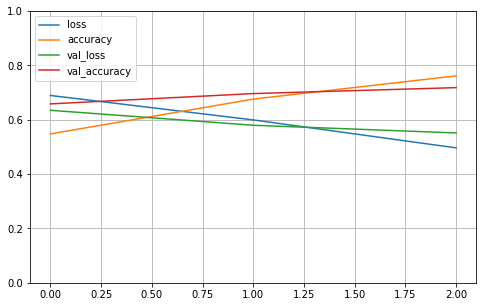

Train set ones/size 4172 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 480 / 869
Range of scores: 0.0015706299 to 0.98307014
Score threshold 0.5
Prediction set ones/size 431 / 869


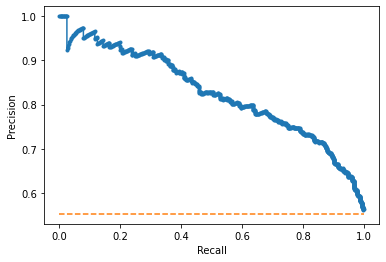

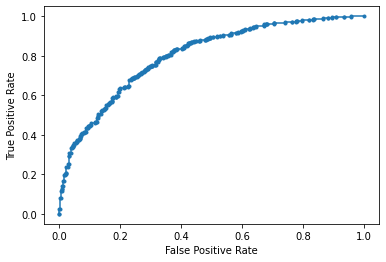

Accuracy: 71.81% Precision: 77.26% Recall: 69.38%
F1: 73.11% AUPRC: 82.66% AUROC: 80.11%
2023-02-07 00:16:07.446889
Fold 8
RCI threshold derived from training set: -0.07443658561580764
FIT
2023-02-07 00:16:11.007492
PREDICT
2023-02-07 00:16:19.759155


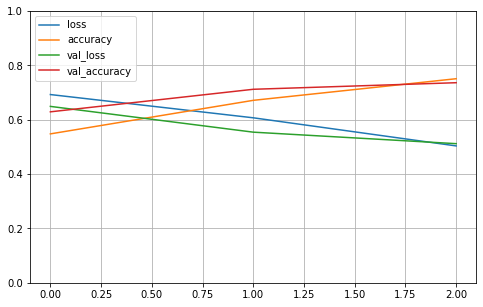

Train set ones/size 4194 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 458 / 868
Range of scores: 0.022439888 to 0.9972894
Score threshold 0.5
Prediction set ones/size 519 / 868


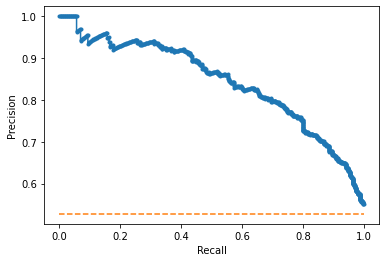

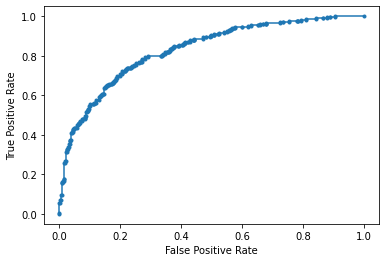

Accuracy: 73.62% Precision: 72.06% Recall: 81.66%
F1: 76.56% AUPRC: 84.43% AUROC: 83.02%
2023-02-07 00:16:20.459721
Fold 9
RCI threshold derived from training set: -0.08124539040798057
FIT
2023-02-07 00:16:24.122739
PREDICT
2023-02-07 00:16:35.558988


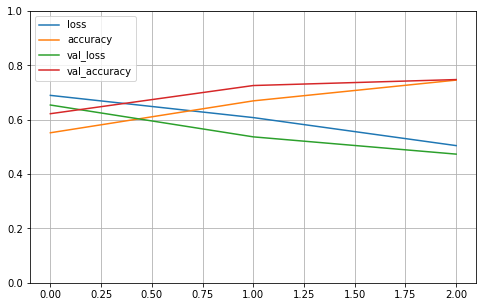

Train set ones/size 4190 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 471 / 868
Range of scores: 0.001708239 to 0.9911419
Score threshold 0.5
Prediction set ones/size 486 / 868


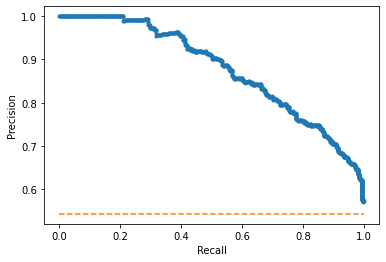

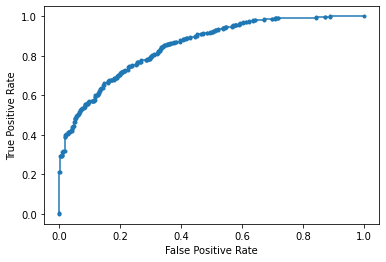

Accuracy: 74.77% Precision: 75.93% Recall: 78.34%
F1: 77.12% AUPRC: 87.80% AUROC: 85.10%
2023-02-07 00:16:36.246328
Fold 10
RCI threshold derived from training set: -0.07852757553011895
FIT
2023-02-07 00:16:40.929710
PREDICT
2023-02-07 00:16:52.405708


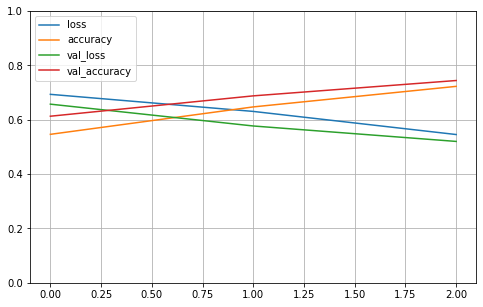

Train set ones/size 4192 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 469 / 868
Range of scores: 0.019267377 to 0.98721373
Score threshold 0.5
Prediction set ones/size 441 / 868


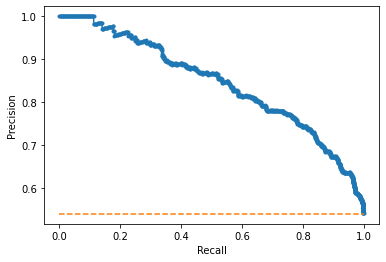

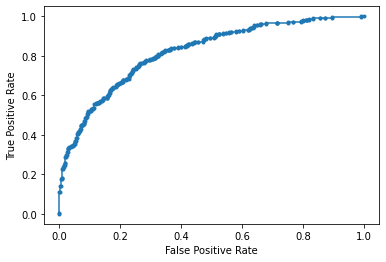

Accuracy: 74.42% Precision: 78.00% Recall: 73.35%
F1: 75.60% AUPRC: 84.56% AUROC: 81.92%
2023-02-07 00:16:53.533277

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.86% +/- 2.31
 precision mean 75.88% +/- 4.45
 recall mean 73.58% +/- 8.95
 F1 mean 74.20% +/- 4.05
 AUPRC mean 83.43% +/- 2.30
 AUROC mean 81.94% +/- 1.79
Finished cell Line 0 A549

2023-02-07 00:16:55.078356
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-07 00:17:20.892221
splitting
Fold 1
RCI threshold derived from training set: -0.2860503863035882
FIT
2023-02-07 00:17:25.675807
PREDICT
2023-02-07 00:17:47.630304


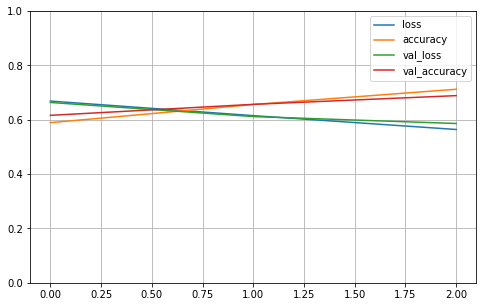

Train set ones/size 7436 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 828 / 1654
Range of scores: 0.013527516 to 0.9947017
Score threshold 0.5
Prediction set ones/size 655 / 1654


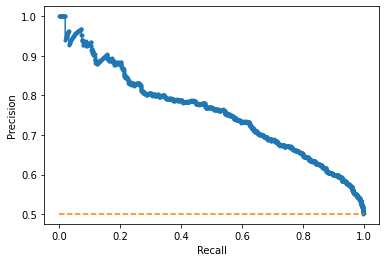

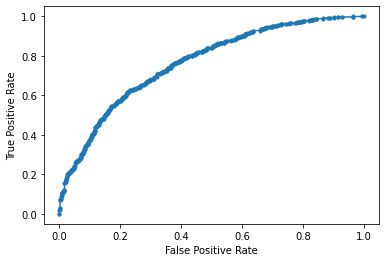

Accuracy: 68.86% Precision: 73.89% Recall: 58.45%
F1: 65.27% AUPRC: 75.80% AUROC: 76.46%
2023-02-07 00:17:48.528805
Fold 2
RCI threshold derived from training set: -0.2767828940834565
FIT
2023-02-07 00:17:54.201060
PREDICT
2023-02-07 00:18:16.172456


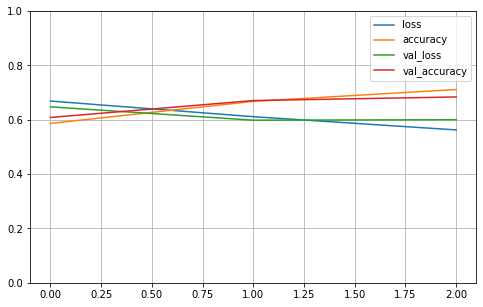

Train set ones/size 7472 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 789 / 1654
Range of scores: 0.008273249 to 0.9863499
Score threshold 0.5
Prediction set ones/size 476 / 1654


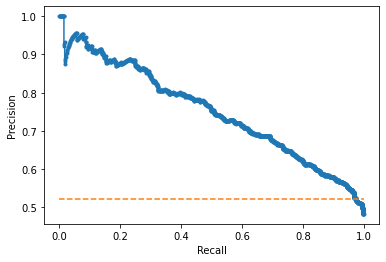

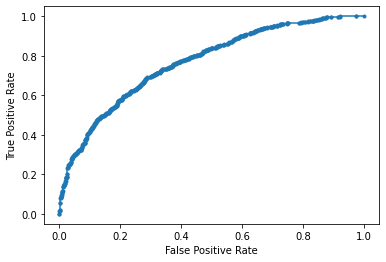

Accuracy: 68.38% Precision: 77.94% Recall: 47.02%
F1: 58.66% AUPRC: 75.15% AUROC: 76.82%
2023-02-07 00:18:17.080227
Fold 3
RCI threshold derived from training set: -0.2846416293146083
FIT
2023-02-07 00:18:22.758106
PREDICT
2023-02-07 00:18:38.754316


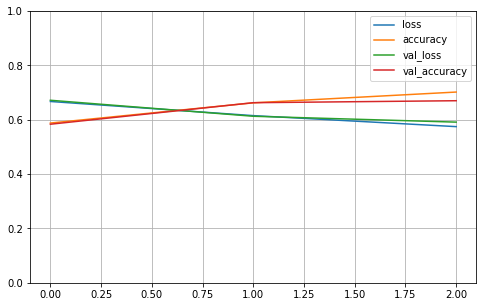

Train set ones/size 7418 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 846 / 1654
Range of scores: 0.024163278 to 0.9865036
Score threshold 0.5
Prediction set ones/size 896 / 1654


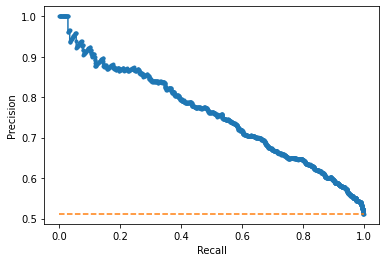

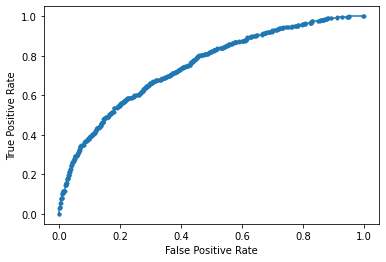

Accuracy: 66.99% Precision: 66.74% Recall: 70.69%
F1: 68.66% AUPRC: 75.77% AUROC: 74.82%
2023-02-07 00:18:39.800346
Fold 4
RCI threshold derived from training set: -0.2841060262625991
FIT
2023-02-07 00:18:45.551417
PREDICT
2023-02-07 00:19:07.499287


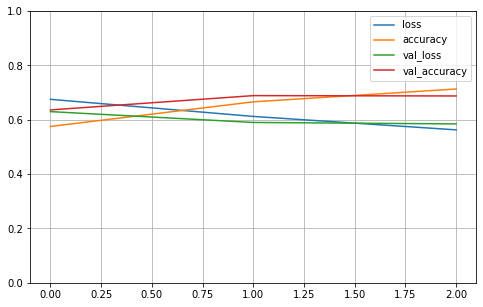

Train set ones/size 7416 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 848 / 1654
Range of scores: 0.060802564 to 0.9952518
Score threshold 0.5
Prediction set ones/size 1063 / 1654


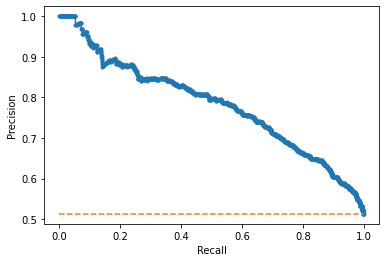

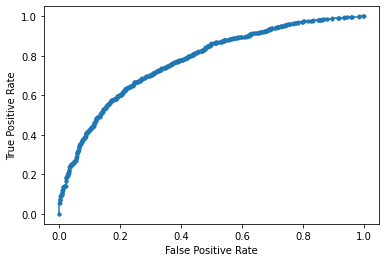

Accuracy: 68.74% Precision: 65.57% Recall: 82.19%
F1: 72.95% AUPRC: 78.26% AUROC: 77.45%
2023-02-07 00:19:08.410379
Fold 5
RCI threshold derived from training set: -0.2888123344866282
FIT
2023-02-07 00:19:14.091984
PREDICT
2023-02-07 00:19:29.878604


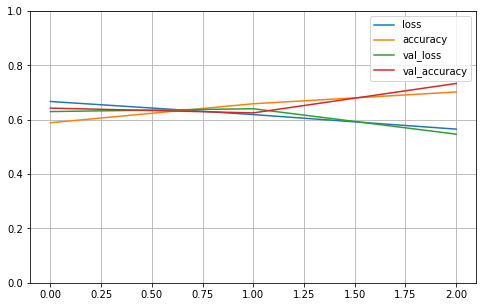

Train set ones/size 7408 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 856 / 1654
Range of scores: 0.024465395 to 0.9880542
Score threshold 0.5
Prediction set ones/size 813 / 1654


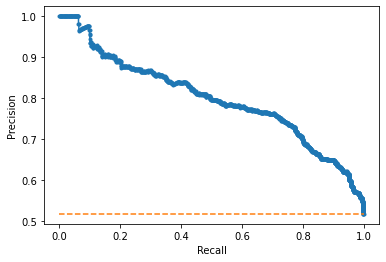

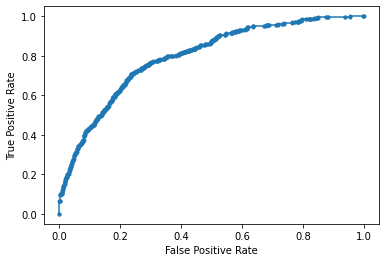

Accuracy: 73.34% Precision: 75.52% Recall: 71.73%
F1: 73.58% AUPRC: 79.93% AUROC: 79.59%
2023-02-07 00:19:30.997707
Fold 6
RCI threshold derived from training set: -0.2858548136823007
FIT
2023-02-07 00:19:36.916176
PREDICT
2023-02-07 00:19:58.874799


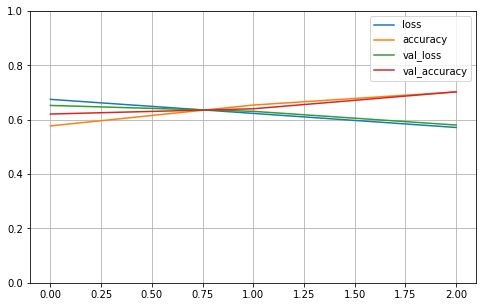

Train set ones/size 7422 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 842 / 1654
Range of scores: 0.015375682 to 0.9841135
Score threshold 0.5
Prediction set ones/size 948 / 1654


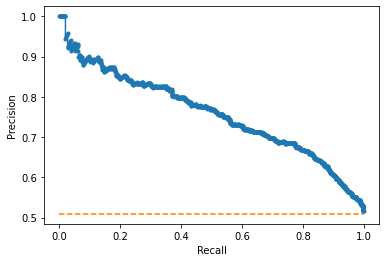

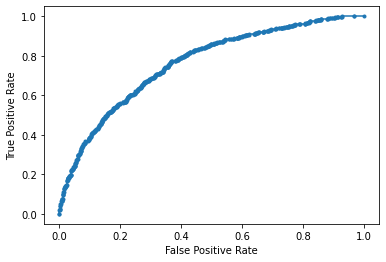

Accuracy: 70.25% Precision: 68.46% Recall: 77.08%
F1: 72.51% AUPRC: 75.90% AUROC: 76.25%
2023-02-07 00:19:59.711055
Fold 7
RCI threshold derived from training set: -0.28354508167439363
FIT
2023-02-07 00:20:05.411815
PREDICT
2023-02-07 00:20:27.353267


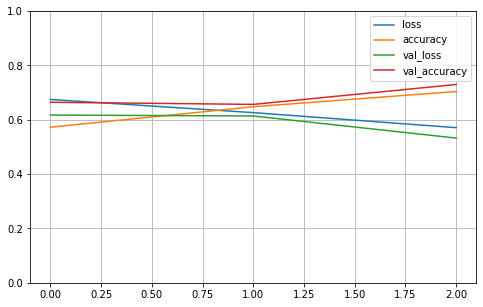

Train set ones/size 7446 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 818 / 1653
Range of scores: 0.002808108 to 0.9924447
Score threshold 0.5
Prediction set ones/size 861 / 1653


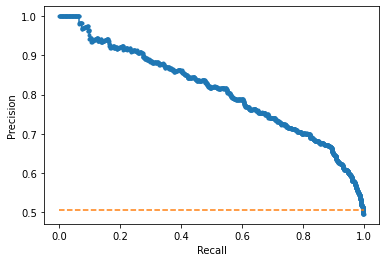

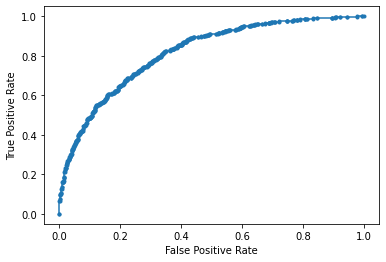

Accuracy: 72.96% Precision: 71.54% Recall: 75.31%
F1: 73.38% AUPRC: 80.99% AUROC: 81.63%
2023-02-07 00:20:28.273155
Fold 8
RCI threshold derived from training set: -0.27972968674662363
FIT
2023-02-07 00:20:34.814074
PREDICT
2023-02-07 00:20:56.989280


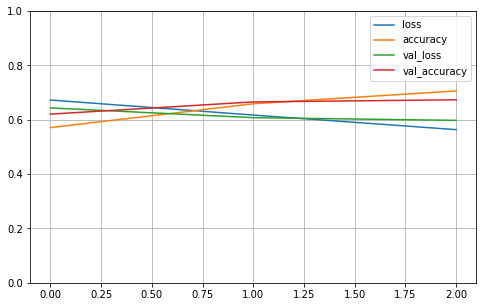

Train set ones/size 7448 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 813 / 1653
Range of scores: 0.021239871 to 0.9947179
Score threshold 0.5
Prediction set ones/size 1057 / 1653


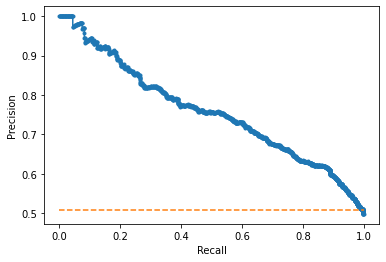

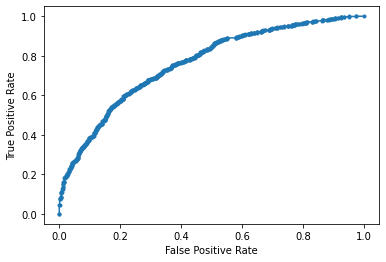

Accuracy: 67.33% Precision: 62.91% Recall: 81.80%
F1: 71.12% AUPRC: 75.86% AUROC: 76.26%
2023-02-07 00:20:57.850168
Fold 9
RCI threshold derived from training set: -0.2802676957286837
FIT
2023-02-07 00:21:05.113050
PREDICT
2023-02-07 00:21:27.066406


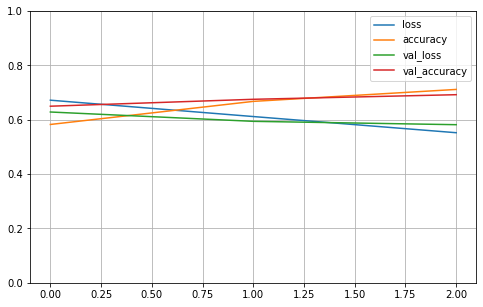

Train set ones/size 7456 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 805 / 1653
Range of scores: 0.021354966 to 0.9921922
Score threshold 0.5
Prediction set ones/size 1068 / 1653


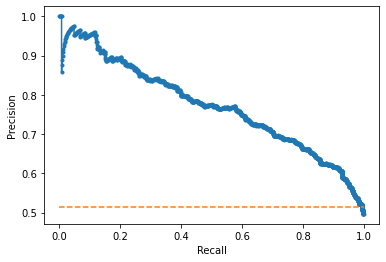

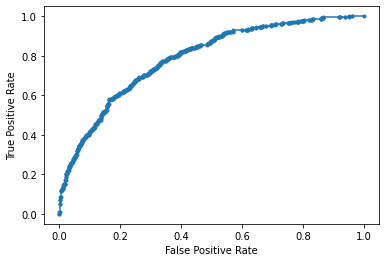

Accuracy: 69.21% Precision: 63.86% Recall: 84.72%
F1: 72.82% AUPRC: 77.25% AUROC: 78.85%
2023-02-07 00:21:28.260675
Fold 10
RCI threshold derived from training set: -0.28432212661761747
FIT
2023-02-07 00:21:34.177589
PREDICT
2023-02-07 00:21:49.698302


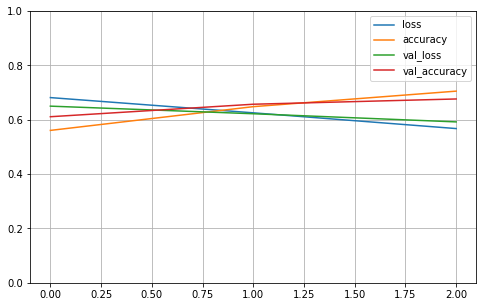

Train set ones/size 7445 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 819 / 1653
Range of scores: 0.029939543 to 0.99301445
Score threshold 0.5
Prediction set ones/size 1030 / 1653


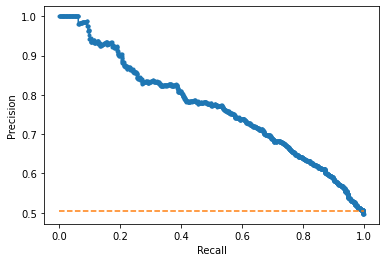

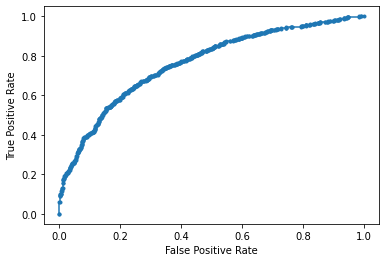

Accuracy: 67.63% Precision: 63.79% Recall: 80.22%
F1: 71.07% AUPRC: 76.82% AUROC: 76.35%
2023-02-07 00:21:50.616374

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.37% +/- 2.21
 precision mean 69.02% +/- 5.38
 recall mean 72.92% +/- 11.86
 F1 mean 70.00% +/- 4.74
 AUPRC mean 77.17% +/- 1.97
 AUROC mean 77.45% +/- 2.01
Finished cell Line 1 H1.hESC

2023-02-07 00:21:52.199902
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-07 00:22:02.119625
splitting
Fold 1
RCI threshold derived from training set: -1.283539943874046
FIT
2023-02-07 00:22:03.759949
PREDICT
2023-02-07 00:22:14.923758


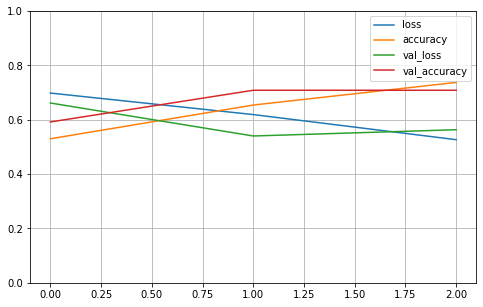

Train set ones/size 2529 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 277 / 583
Range of scores: 0.0020913032 to 0.94738007
Score threshold 0.5
Prediction set ones/size 131 / 583


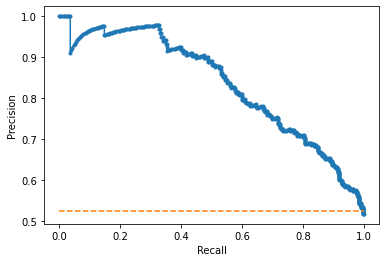

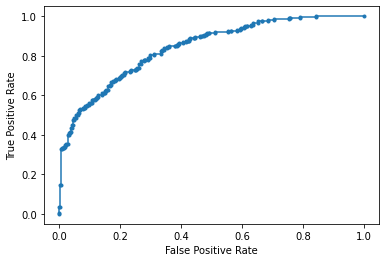

Accuracy: 70.84% Precision: 90.84% Recall: 42.96%
F1: 58.33% AUPRC: 83.53% AUROC: 84.05%
2023-02-07 00:22:15.529993
Fold 2
RCI threshold derived from training set: -1.2804343327099237
FIT
2023-02-07 00:22:18.340478
PREDICT
2023-02-07 00:22:29.453596


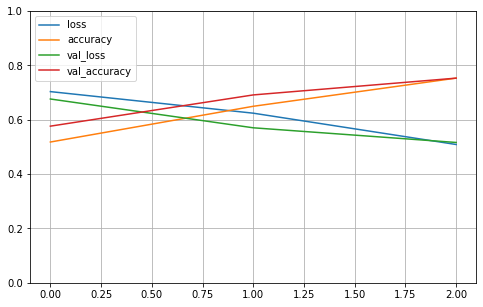

Train set ones/size 2532 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 274 / 583
Range of scores: 0.0022651118 to 0.9778487
Score threshold 0.5
Prediction set ones/size 212 / 583


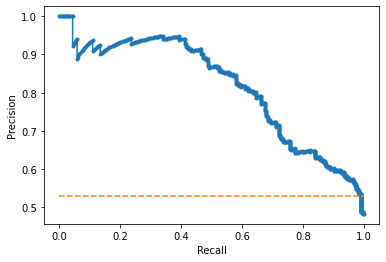

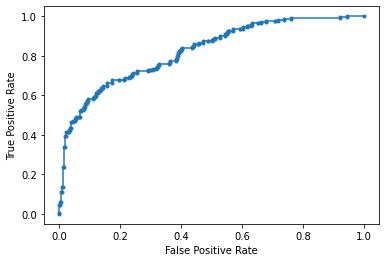

Accuracy: 75.30% Precision: 80.66% Recall: 62.41%
F1: 70.37% AUPRC: 81.66% AUROC: 82.44%
2023-02-07 00:22:30.115256
Fold 3
RCI threshold derived from training set: -1.2776195288549619
FIT
2023-02-07 00:22:32.896303
PREDICT
2023-02-07 00:22:39.520525


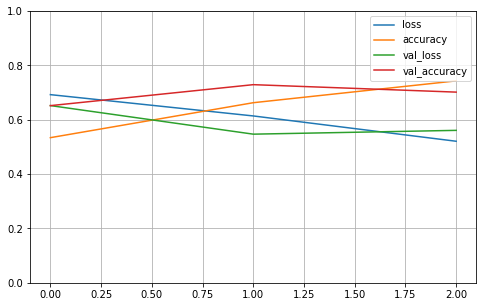

Train set ones/size 2501 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 265 / 583
Range of scores: 0.0047890856 to 0.9618337
Score threshold 0.5
Prediction set ones/size 131 / 583


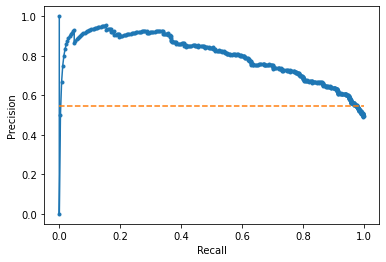

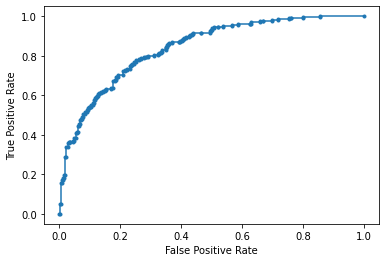

Accuracy: 70.15% Precision: 84.73% Recall: 41.89%
F1: 56.06% AUPRC: 79.91% AUROC: 84.07%
2023-02-07 00:22:40.131373
Fold 4
RCI threshold derived from training set: -1.2759836982064492
FIT
2023-02-07 00:22:42.943372
PREDICT
2023-02-07 00:22:54.073982


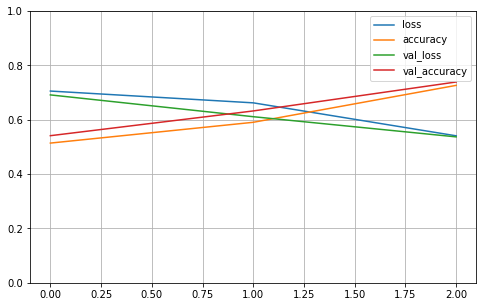

Train set ones/size 2508 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 258 / 582
Range of scores: 0.009557995 to 0.97879046
Score threshold 0.5
Prediction set ones/size 178 / 582


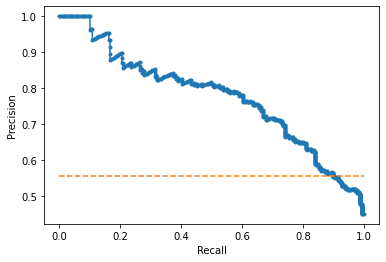

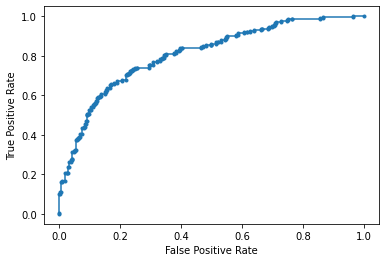

Accuracy: 73.88% Precision: 79.78% Recall: 55.04%
F1: 65.14% AUPRC: 77.72% AUROC: 80.82%
2023-02-07 00:22:54.728041
Fold 5
RCI threshold derived from training set: -1.2879645047891624
FIT
2023-02-07 00:22:57.555501
PREDICT
2023-02-07 00:23:03.910022


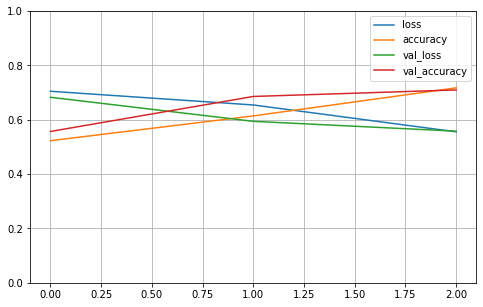

Train set ones/size 2523 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 284 / 582
Range of scores: 0.0066427775 to 0.9515102
Score threshold 0.5
Prediction set ones/size 163 / 582


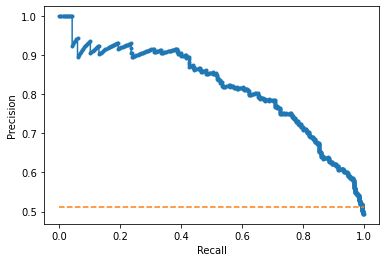

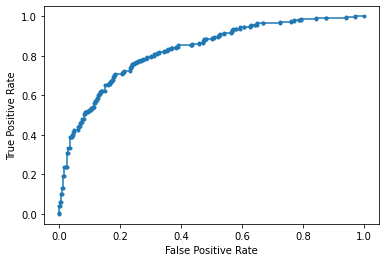

Accuracy: 70.96% Precision: 85.28% Recall: 48.94%
F1: 62.19% AUPRC: 81.88% AUROC: 82.79%
2023-02-07 00:23:04.547394
Fold 6
RCI threshold derived from training set: -1.285638432093112
FIT
2023-02-07 00:23:07.364146
PREDICT
2023-02-07 00:23:13.358176


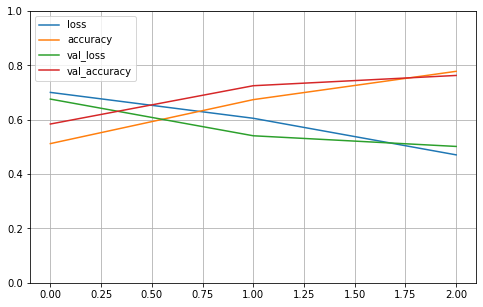

Train set ones/size 2525 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 282 / 582
Range of scores: 0.0071980357 to 0.99180704
Score threshold 0.5
Prediction set ones/size 302 / 582


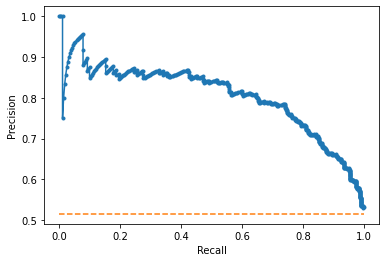

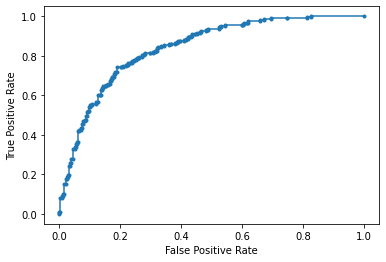

Accuracy: 76.29% Precision: 73.84% Recall: 79.08%
F1: 76.37% AUPRC: 80.51% AUROC: 84.02%
2023-02-07 00:23:14.169654
Fold 7
RCI threshold derived from training set: -1.3007761754245373
FIT
2023-02-07 00:23:17.160018
PREDICT
2023-02-07 00:23:23.167762


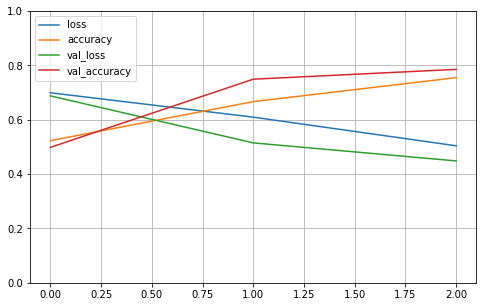

Train set ones/size 2520 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 303 / 582
Range of scores: 0.010998067 to 0.9947331
Score threshold 0.5
Prediction set ones/size 316 / 582


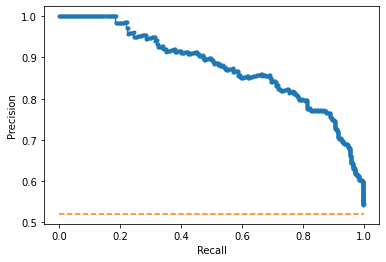

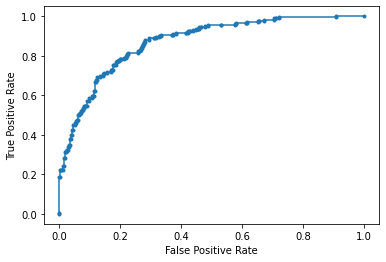

Accuracy: 78.52% Precision: 78.16% Recall: 81.52%
F1: 79.81% AUPRC: 87.71% AUROC: 87.08%
2023-02-07 00:23:23.794763
Fold 8
RCI threshold derived from training set: -1.278800849303568
FIT
2023-02-07 00:23:27.239996
PREDICT
2023-02-07 00:23:33.565254


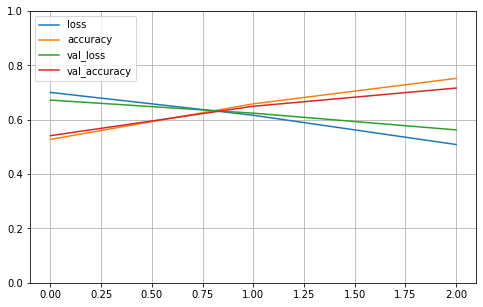

Train set ones/size 2529 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 277 / 582
Range of scores: 0.0018035946 to 0.9710113
Score threshold 0.5
Prediction set ones/size 224 / 582


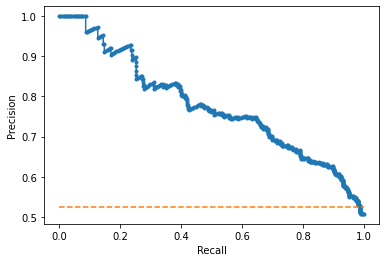

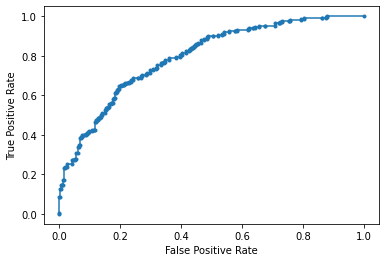

Accuracy: 71.65% Precision: 75.00% Recall: 60.65%
F1: 67.07% AUPRC: 77.73% AUROC: 79.45%
2023-02-07 00:23:34.176831
Fold 9
RCI threshold derived from training set: -1.2968693947910706
FIT
2023-02-07 00:23:36.997800
PREDICT
2023-02-07 00:23:43.242069


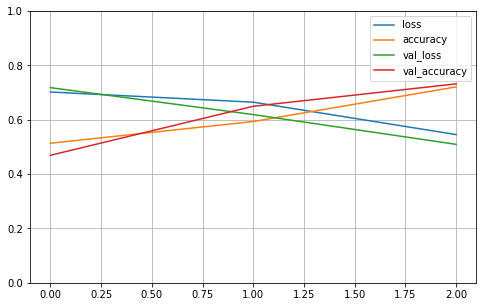

Train set ones/size 2498 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 309 / 582
Range of scores: 0.014056997 to 0.9776038
Score threshold 0.5
Prediction set ones/size 299 / 582


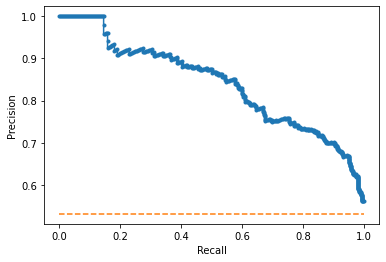

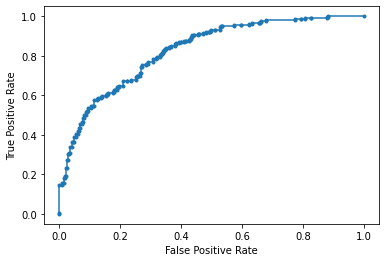

Accuracy: 73.20% Precision: 75.59% Recall: 73.14%
F1: 74.34% AUPRC: 84.08% AUROC: 82.71%
2023-02-07 00:23:43.823334
Fold 10
RCI threshold derived from training set: -1.2907133534439992
FIT
2023-02-07 00:23:46.627301
PREDICT
2023-02-07 00:23:52.610721


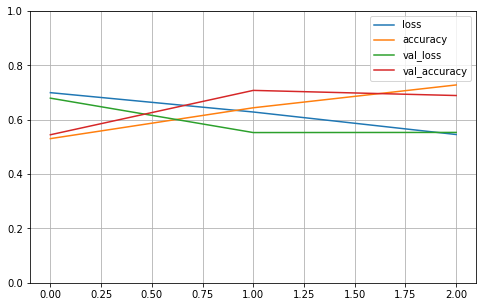

Train set ones/size 2534 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 273 / 582
Range of scores: 0.009073116 to 0.9252303
Score threshold 0.5
Prediction set ones/size 162 / 582


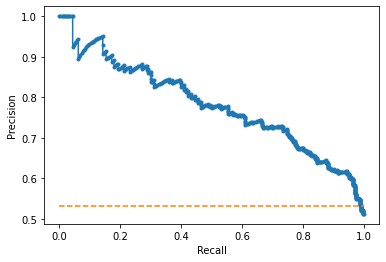

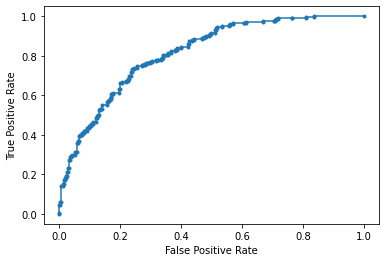

Accuracy: 68.90% Precision: 78.40% Recall: 46.52%
F1: 58.39% AUPRC: 78.22% AUROC: 81.54%
2023-02-07 00:23:53.475660

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.97% +/- 3.04
 precision mean 80.23% +/- 5.33
 recall mean 59.21% +/- 14.71
 F1 mean 66.81% +/- 8.25
 AUPRC mean 81.30% +/- 3.20
 AUROC mean 82.90% +/- 2.10
Finished cell Line 2 HeLa.S3

2023-02-07 00:23:54.905130
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-07 00:24:07.773091
splitting
Fold 1
RCI threshold derived from training set: -1.0839654720302832
FIT
2023-02-07 00:24:10.359086
PREDICT
2023-02-07 00:24:18.360945


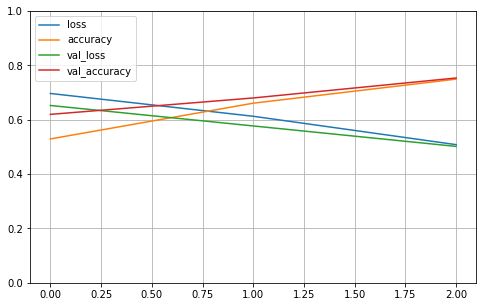

Train set ones/size 3643 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 415 / 844
Range of scores: 0.0003832706 to 0.9926938
Score threshold 0.5
Prediction set ones/size 449 / 844


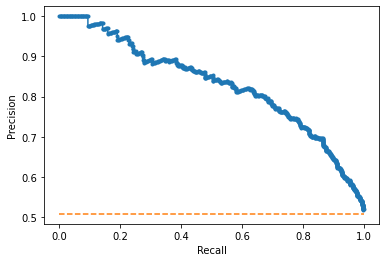

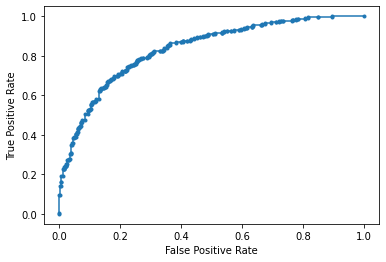

Accuracy: 75.36% Precision: 73.05% Recall: 79.04%
F1: 75.93% AUPRC: 83.06% AUROC: 83.42%
2023-02-07 00:24:19.204025
Fold 2
RCI threshold derived from training set: -1.0801516686556945
FIT
2023-02-07 00:24:23.177829
PREDICT
2023-02-07 00:24:34.450113


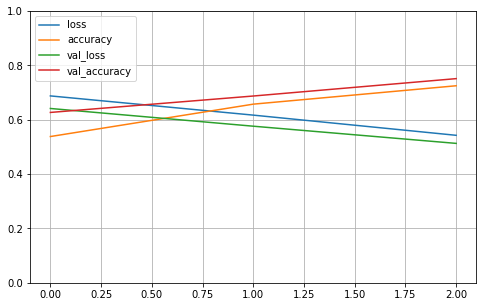

Train set ones/size 3642 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 400 / 844
Range of scores: 0.0065319864 to 0.96915555
Score threshold 0.5
Prediction set ones/size 358 / 844


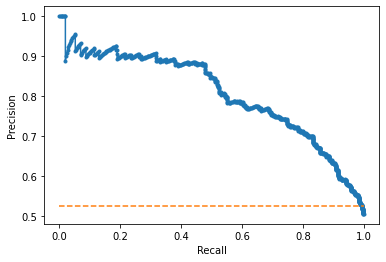

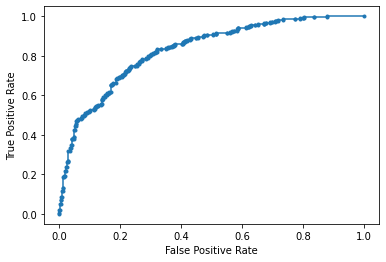

Accuracy: 75.12% Precision: 76.54% Recall: 68.50%
F1: 72.30% AUPRC: 80.67% AUROC: 83.01%
2023-02-07 00:24:35.107957
Fold 3
RCI threshold derived from training set: -1.0755342854325212
FIT
2023-02-07 00:24:38.596465
PREDICT
2023-02-07 00:24:49.857361


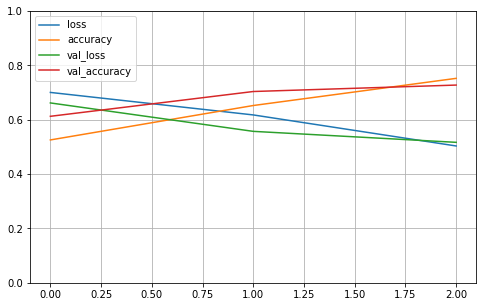

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 386 / 844
Range of scores: 0.0040179165 to 0.9791734
Score threshold 0.5
Prediction set ones/size 324 / 844


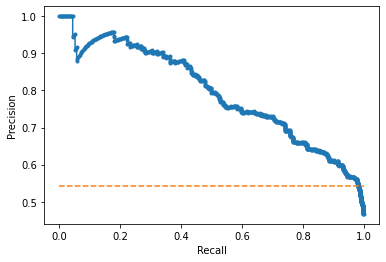

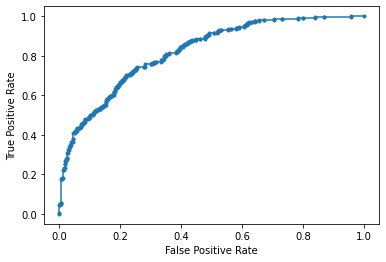

Accuracy: 72.75% Precision: 74.07% Recall: 62.18%
F1: 67.61% AUPRC: 79.46% AUROC: 82.09%
2023-02-07 00:24:50.534609
Fold 4
RCI threshold derived from training set: -1.07985061436208
FIT
2023-02-07 00:24:53.993876
PREDICT
2023-02-07 00:25:05.263453


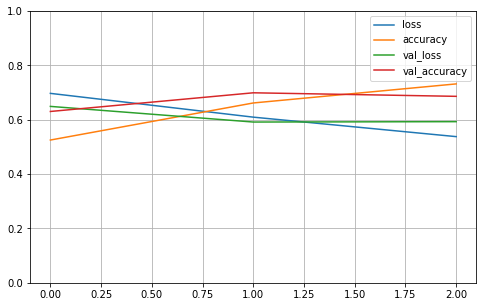

Train set ones/size 3646 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 396 / 844
Range of scores: 0.030965433 to 0.98708236
Score threshold 0.5
Prediction set ones/size 573 / 844


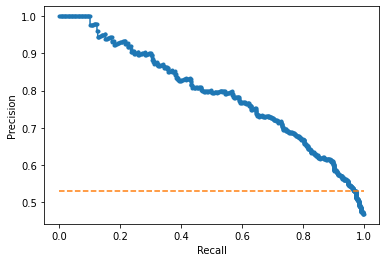

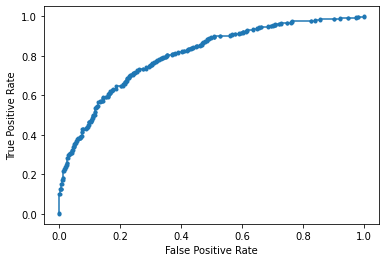

Accuracy: 68.60% Precision: 61.43% Recall: 88.89%
F1: 72.65% AUPRC: 79.33% AUROC: 80.44%
2023-02-07 00:25:05.927793
Fold 5
RCI threshold derived from training set: -1.0818529347004608
FIT
2023-02-07 00:25:09.430718
PREDICT
2023-02-07 00:25:17.933847


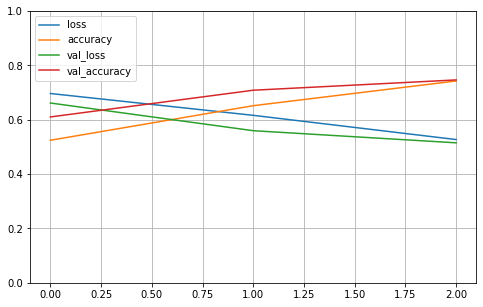

Train set ones/size 3631 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 418 / 844
Range of scores: 0.011628795 to 0.9859343
Score threshold 0.5
Prediction set ones/size 440 / 844


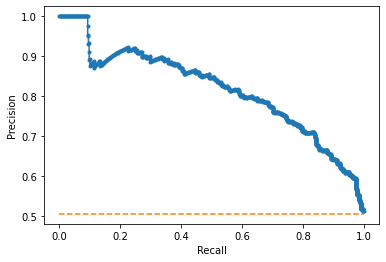

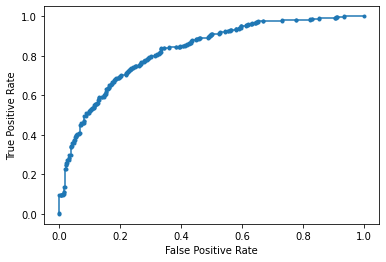

Accuracy: 74.64% Precision: 73.18% Recall: 77.03%
F1: 75.06% AUPRC: 81.73% AUROC: 82.62%
2023-02-07 00:25:18.623022
Fold 6
RCI threshold derived from training set: -1.0809142119407504
FIT
2023-02-07 00:25:22.089469
PREDICT
2023-02-07 00:25:30.513470


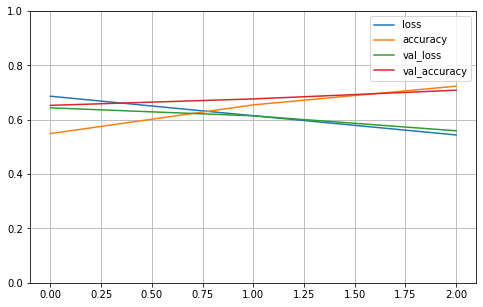

Train set ones/size 3622 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 420 / 844
Range of scores: 0.012554676 to 0.98357624
Score threshold 0.5
Prediction set ones/size 474 / 844


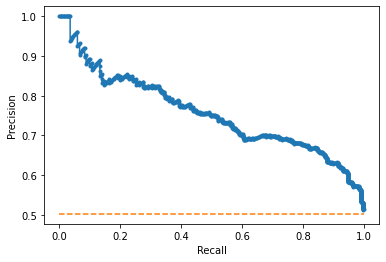

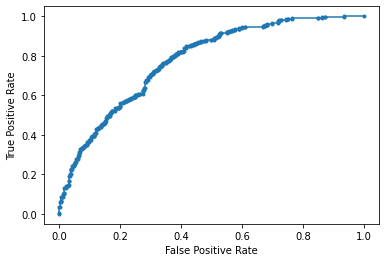

Accuracy: 70.85% Precision: 68.35% Recall: 77.14%
F1: 72.48% AUPRC: 75.68% AUROC: 77.78%
2023-02-07 00:25:31.141140
Fold 7
RCI threshold derived from training set: -1.0826895800434497
FIT
2023-02-07 00:25:34.653360
PREDICT
2023-02-07 00:25:43.087732


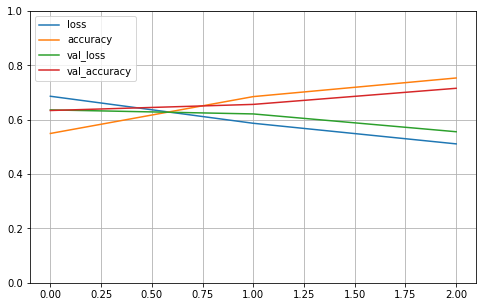

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 393 / 844
Range of scores: 0.0044842702 to 0.9701384
Score threshold 0.5
Prediction set ones/size 319 / 844


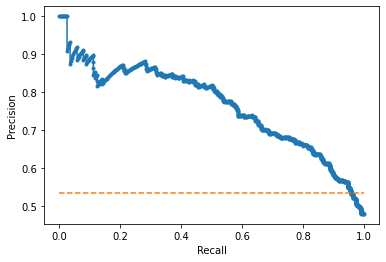

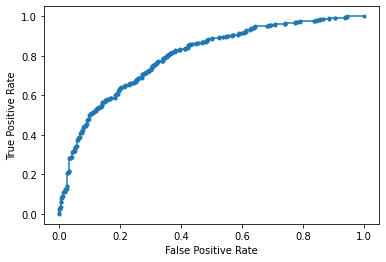

Accuracy: 71.56% Precision: 73.98% Recall: 60.05%
F1: 66.29% AUPRC: 76.52% AUROC: 79.74%
2023-02-07 00:25:43.762998
Fold 8
RCI threshold derived from training set: -1.0882789068571428
FIT
2023-02-07 00:25:47.265998
PREDICT
2023-02-07 00:25:58.535750


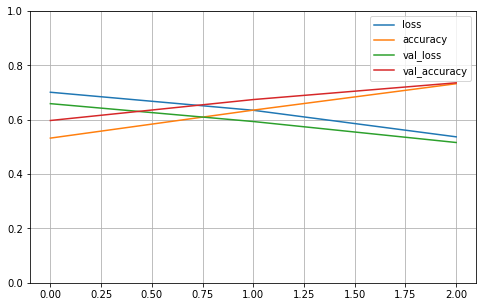

Train set ones/size 3649 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 409 / 844
Range of scores: 0.007912691 to 0.973767
Score threshold 0.5
Prediction set ones/size 334 / 844


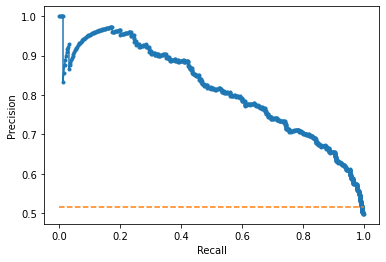

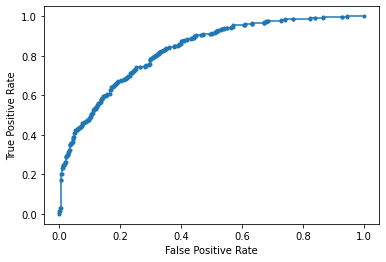

Accuracy: 73.58% Precision: 77.84% Recall: 63.57%
F1: 69.99% AUPRC: 81.50% AUROC: 82.83%
2023-02-07 00:25:59.201020
Fold 9
RCI threshold derived from training set: -1.0822446985661618
FIT
2023-02-07 00:26:02.692366
PREDICT
2023-02-07 00:26:14.099228


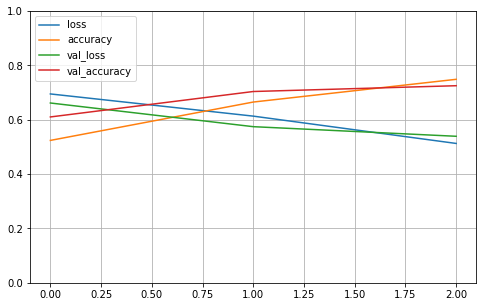

Train set ones/size 3641 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 408 / 844
Range of scores: 0.0030748348 to 0.98733807
Score threshold 0.5
Prediction set ones/size 280 / 844


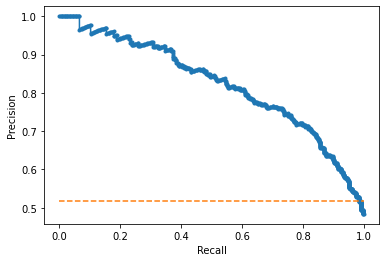

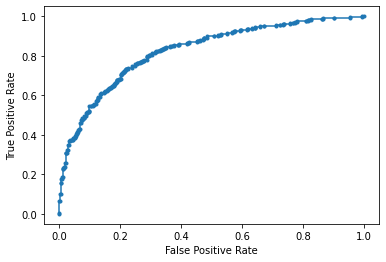

Accuracy: 72.51% Precision: 81.43% Recall: 55.88%
F1: 66.28% AUPRC: 82.31% AUROC: 82.56%
2023-02-07 00:26:14.768447
Fold 10
RCI threshold derived from training set: -1.0828875017048445
FIT
2023-02-07 00:26:19.311345
PREDICT
2023-02-07 00:26:30.813411


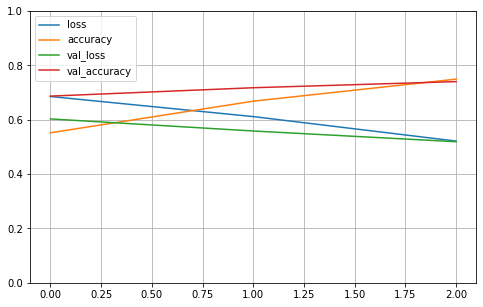

Train set ones/size 3650 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 408 / 843
Range of scores: 0.009668627 to 0.97584575
Score threshold 0.5
Prediction set ones/size 331 / 843


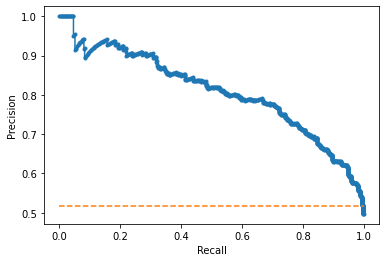

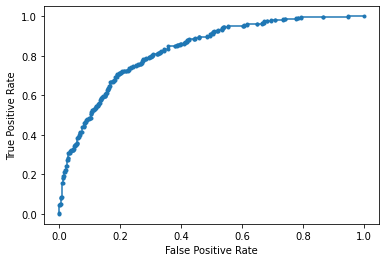

Accuracy: 74.02% Precision: 78.55% Recall: 63.73%
F1: 70.37% AUPRC: 81.01% AUROC: 82.91%
2023-02-07 00:26:31.676720

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.90% +/- 2.12
 precision mean 73.84% +/- 5.66
 recall mean 69.60% +/- 10.43
 F1 mean 70.89% +/- 3.41
 AUPRC mean 80.13% +/- 2.42
 AUROC mean 81.74% +/- 1.82
Finished cell Line 3 HepG2

2023-02-07 00:26:33.187038
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-07 00:26:42.765727
splitting
Fold 1
RCI threshold derived from training set: -0.2837299268113891
FIT
2023-02-07 00:26:45.876160
PREDICT
2023-02-07 00:26:57.206513


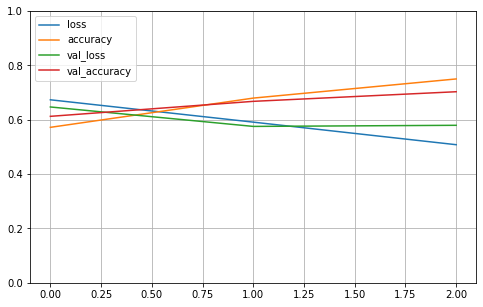

Train set ones/size 3056 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 341 / 707
Range of scores: 0.01869237 to 0.9958111
Score threshold 0.5
Prediction set ones/size 483 / 707


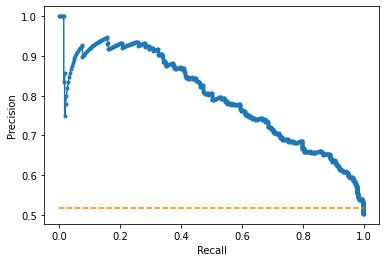

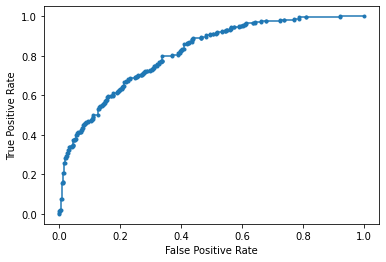

Accuracy: 70.30% Precision: 63.56% Recall: 90.03%
F1: 74.51% AUPRC: 79.46% AUROC: 81.36%
2023-02-07 00:26:58.118500
Fold 2
RCI threshold derived from training set: -0.2753148000880919
FIT
2023-02-07 00:27:01.372568
PREDICT
2023-02-07 00:27:08.270921


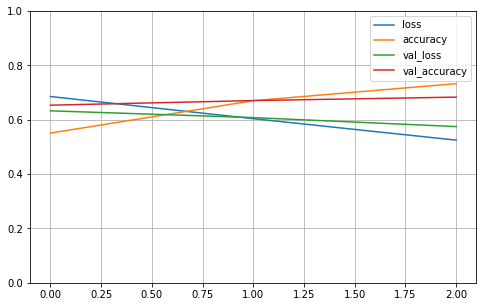

Train set ones/size 3063 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 327 / 707
Range of scores: 0.0153375985 to 0.9919286
Score threshold 0.5
Prediction set ones/size 393 / 707


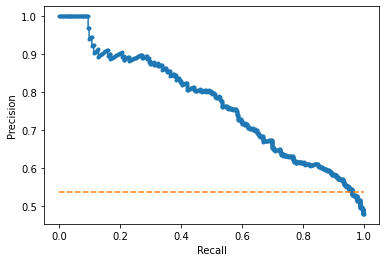

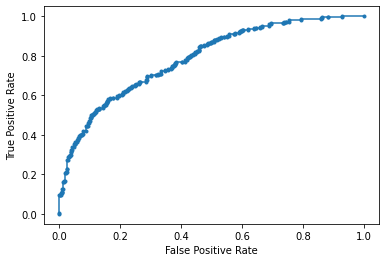

Accuracy: 68.32% Precision: 63.10% Recall: 75.84%
F1: 68.89% AUPRC: 76.98% AUROC: 78.74%
2023-02-07 00:27:08.888609
Fold 3
RCI threshold derived from training set: -0.2789730485228881
FIT
2023-02-07 00:27:12.812715
PREDICT
2023-02-07 00:27:19.737299


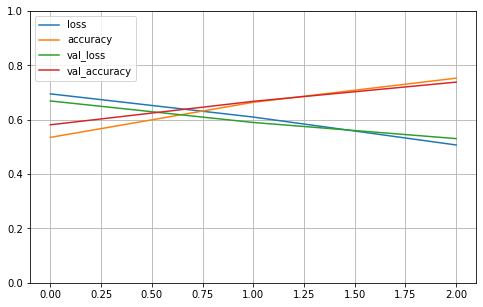

Train set ones/size 3051 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 340 / 707
Range of scores: 0.002610267 to 0.9943089
Score threshold 0.5
Prediction set ones/size 461 / 707


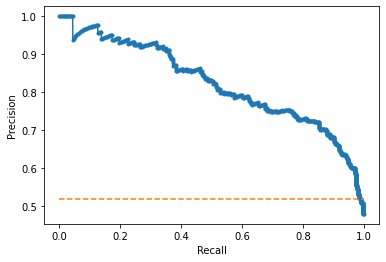

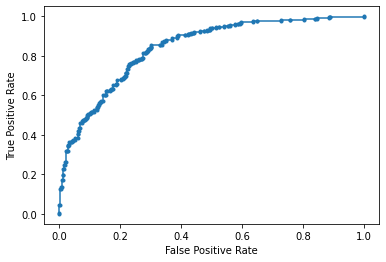

Accuracy: 73.83% Precision: 66.81% Recall: 90.59%
F1: 76.90% AUPRC: 82.44% AUROC: 84.06%
2023-02-07 00:27:20.405664
Fold 4
RCI threshold derived from training set: -0.2888440364338524
FIT
2023-02-07 00:27:24.815839
PREDICT
2023-02-07 00:27:36.109740


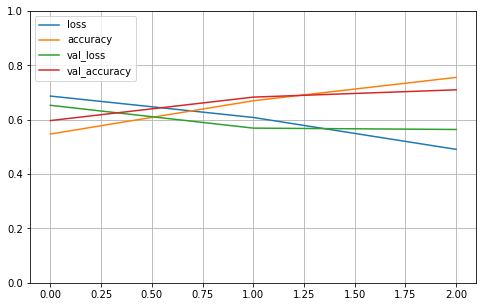

Train set ones/size 3042 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 358 / 707
Range of scores: 0.0018686214 to 0.9922908
Score threshold 0.5
Prediction set ones/size 303 / 707


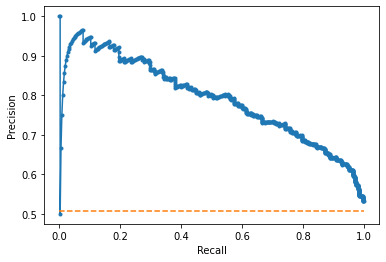

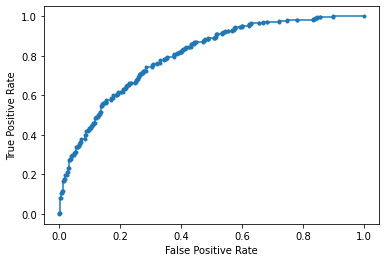

Accuracy: 71.00% Precision: 75.25% Recall: 63.69%
F1: 68.99% AUPRC: 79.09% AUROC: 80.14%
2023-02-07 00:27:36.987375
Fold 5
RCI threshold derived from training set: -0.2832924759452658
FIT
2023-02-07 00:27:40.222461
PREDICT
2023-02-07 00:27:47.139304


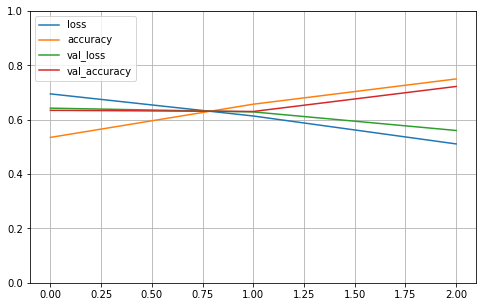

Train set ones/size 3058 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 339 / 706
Range of scores: 0.0029188485 to 0.9786952
Score threshold 0.5
Prediction set ones/size 263 / 706


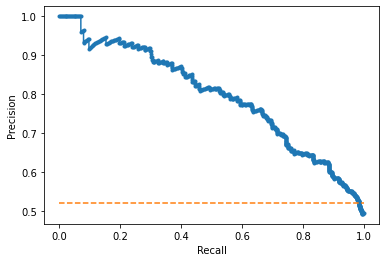

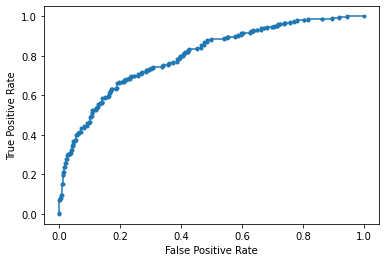

Accuracy: 72.24% Precision: 77.19% Recall: 59.88%
F1: 67.44% AUPRC: 79.61% AUROC: 79.94%
2023-02-07 00:27:47.777733
Fold 6
RCI threshold derived from training set: -0.28163197472161056
FIT
2023-02-07 00:27:51.672960
PREDICT
2023-02-07 00:28:02.851240


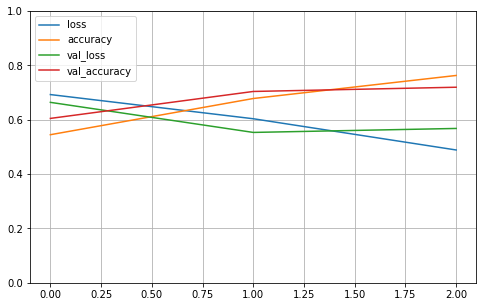

Train set ones/size 3057 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 340 / 706
Range of scores: 0.0010365477 to 0.9917864
Score threshold 0.5
Prediction set ones/size 246 / 706


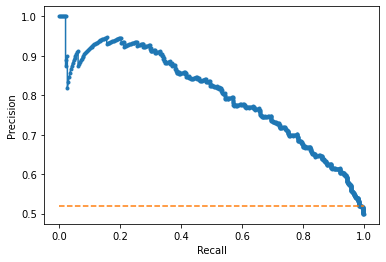

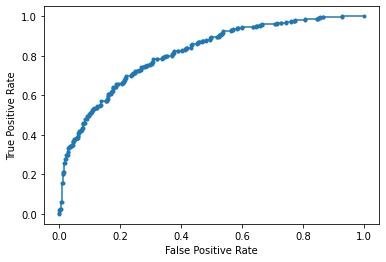

Accuracy: 71.95% Precision: 78.86% Recall: 57.06%
F1: 66.21% AUPRC: 79.91% AUROC: 81.34%
2023-02-07 00:28:03.545034
Fold 7
RCI threshold derived from training set: -0.28862815410978293
FIT
2023-02-07 00:28:06.662978
PREDICT
2023-02-07 00:28:17.875037


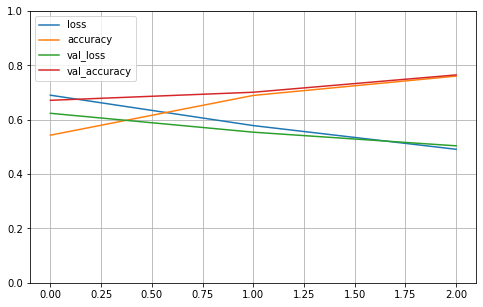

Train set ones/size 3046 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 354 / 706
Range of scores: 0.0040947865 to 0.9965507
Score threshold 0.5
Prediction set ones/size 404 / 706


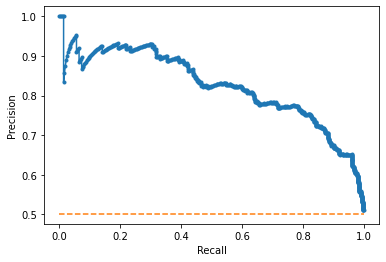

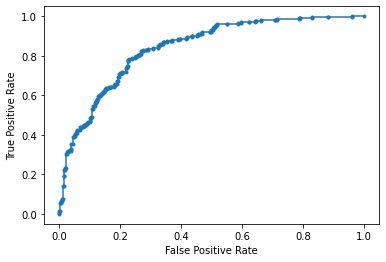

Accuracy: 76.49% Precision: 73.27% Recall: 83.62%
F1: 78.10% AUPRC: 82.46% AUROC: 84.18%
2023-02-07 00:28:18.564456
Fold 8
RCI threshold derived from training set: -0.28006548551116706
FIT
2023-02-07 00:28:21.687572
PREDICT
2023-02-07 00:28:32.897603


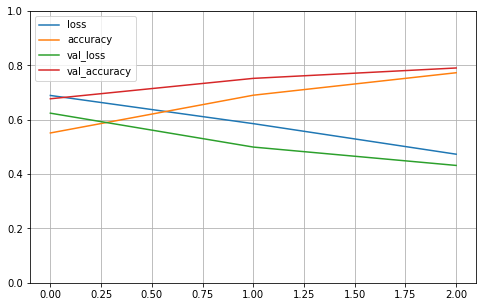

Train set ones/size 3072 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 320 / 706
Range of scores: 0.00605485 to 0.996276
Score threshold 0.5
Prediction set ones/size 328 / 706


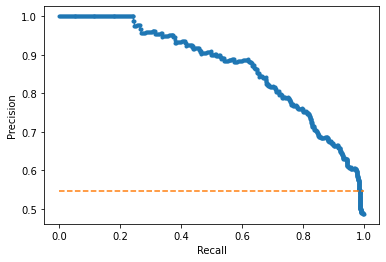

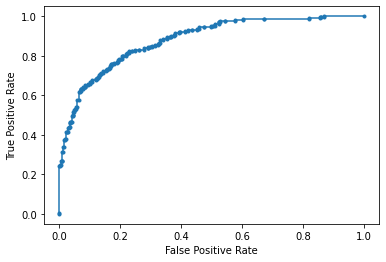

Accuracy: 79.04% Precision: 76.22% Recall: 78.12%
F1: 77.16% AUPRC: 86.91% AUROC: 88.06%
2023-02-07 00:28:33.535655
Fold 9
RCI threshold derived from training set: -0.28685858487889276
FIT
2023-02-07 00:28:36.707651
PREDICT
2023-02-07 00:28:47.889417


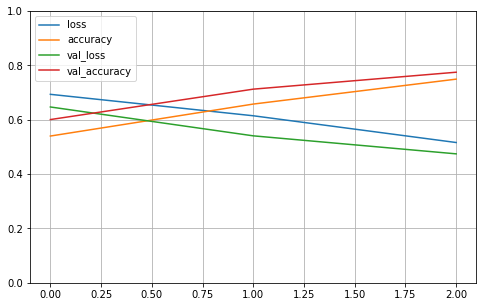

Train set ones/size 3067 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 333 / 706
Range of scores: 0.0063608424 to 0.98474336
Score threshold 0.5
Prediction set ones/size 328 / 706


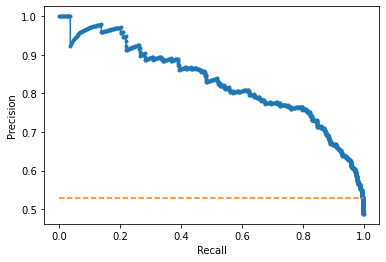

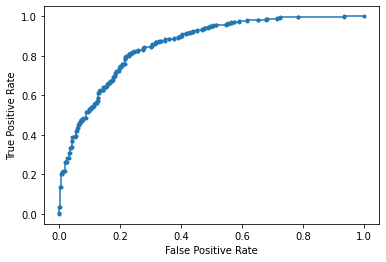

Accuracy: 77.48% Precision: 76.52% Recall: 75.38%
F1: 75.95% AUPRC: 83.10% AUROC: 85.57%
2023-02-07 00:28:48.550453
Fold 10
RCI threshold derived from training set: -0.28572198597986787
FIT
2023-02-07 00:28:51.658077
PREDICT
2023-02-07 00:28:59.069873


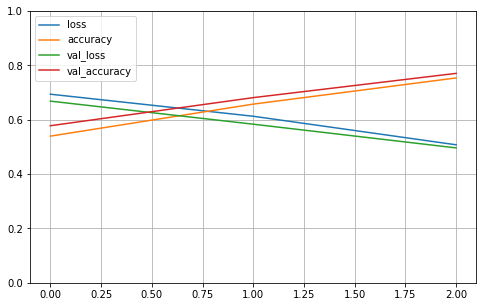

Train set ones/size 3053 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 344 / 706
Range of scores: 0.0049630716 to 0.99228257
Score threshold 0.5
Prediction set ones/size 340 / 706


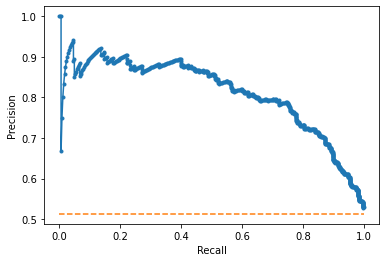

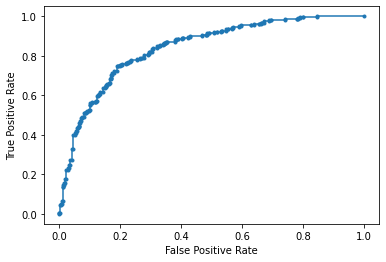

Accuracy: 77.05% Precision: 76.76% Recall: 75.87%
F1: 76.32% AUPRC: 81.20% AUROC: 84.06%
2023-02-07 00:28:59.702310

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.77% +/- 3.57
 precision mean 72.75% +/- 5.95
 recall mean 75.01% +/- 11.70
 F1 mean 73.05% +/- 4.60
 AUPRC mean 81.12% +/- 2.76
 AUROC mean 82.75% +/- 2.91
Finished cell Line 4 HT1080

2023-02-07 00:29:01.051731
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-07 00:29:16.189305
splitting
Fold 1
RCI threshold derived from training set: -0.9598692552699883
FIT
2023-02-07 00:29:18.656399
PREDICT
2023-02-07 00:29:28.237615


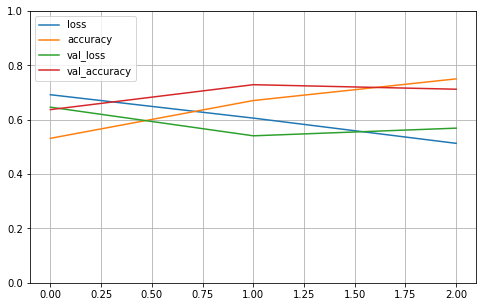

Train set ones/size 4431 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 505 / 959
Range of scores: 0.0012068196 to 0.98325056
Score threshold 0.5
Prediction set ones/size 319 / 959


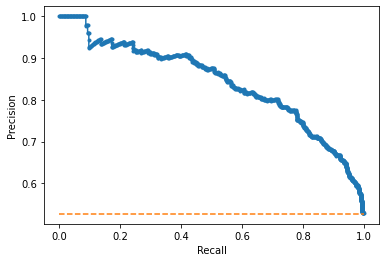

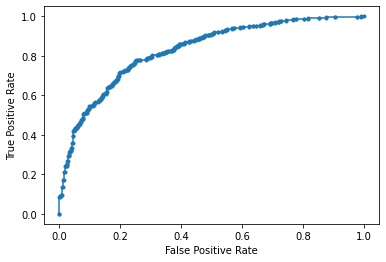

Accuracy: 71.22% Precision: 85.89% Recall: 54.26%
F1: 66.50% AUPRC: 84.13% AUROC: 82.95%
2023-02-07 00:29:28.890743
Fold 2
RCI threshold derived from training set: -0.9636234434704518
FIT
2023-02-07 00:29:32.987351
PREDICT
2023-02-07 00:29:44.710059


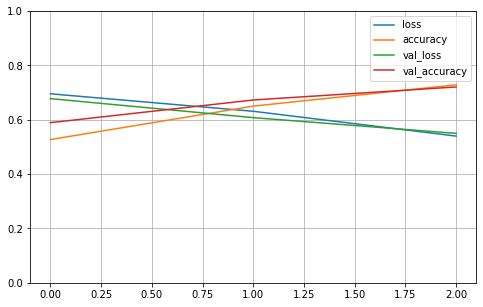

Train set ones/size 4424 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 512 / 959
Range of scores: 0.012530876 to 0.983977
Score threshold 0.5
Prediction set ones/size 530 / 959


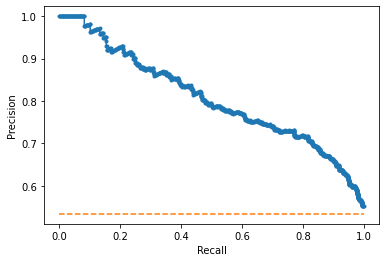

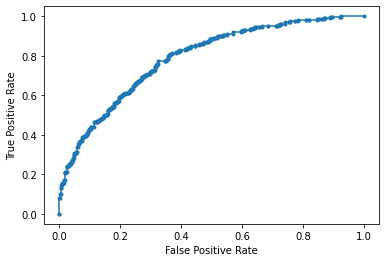

Accuracy: 72.05% Precision: 73.02% Recall: 75.59%
F1: 74.28% AUPRC: 80.74% AUROC: 78.84%
2023-02-07 00:29:45.392718
Fold 3
RCI threshold derived from training set: -0.9593738715434531
FIT
2023-02-07 00:29:50.129313
PREDICT
2023-02-07 00:29:59.252746


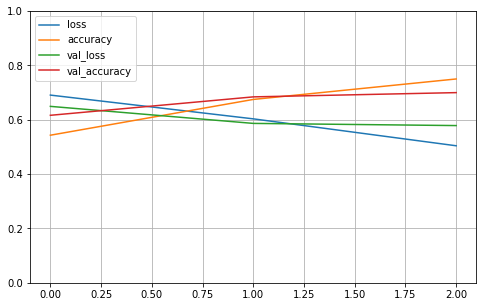

Train set ones/size 4440 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 496 / 959
Range of scores: 0.003911952 to 0.970675
Score threshold 0.5
Prediction set ones/size 384 / 959


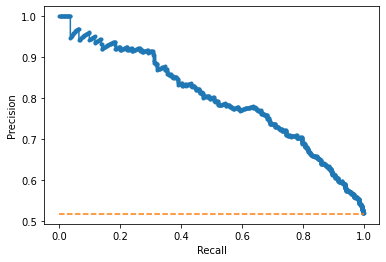

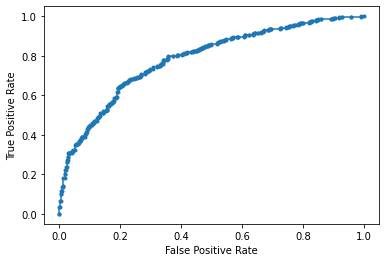

Accuracy: 69.97% Precision: 77.08% Recall: 59.68%
F1: 67.27% AUPRC: 80.01% AUROC: 78.50%
2023-02-07 00:30:00.182833
Fold 4
RCI threshold derived from training set: -0.9491514312294321
FIT
2023-02-07 00:30:04.126286
PREDICT
2023-02-07 00:30:15.454865


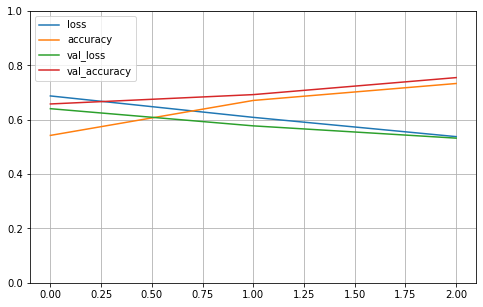

Train set ones/size 4419 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 457 / 959
Range of scores: 0.02027243 to 0.9490065
Score threshold 0.5
Prediction set ones/size 372 / 959


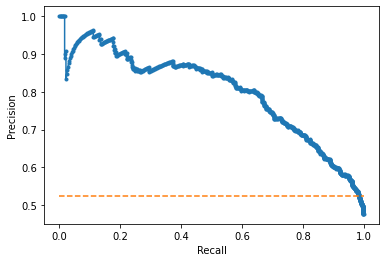

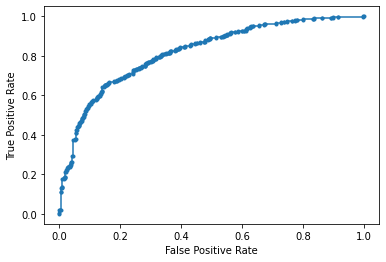

Accuracy: 75.50% Precision: 79.84% Recall: 64.99%
F1: 71.65% AUPRC: 80.12% AUROC: 81.90%
2023-02-07 00:30:16.125408
Fold 5
RCI threshold derived from training set: -0.96778603597219
FIT
2023-02-07 00:30:19.938765
PREDICT
2023-02-07 00:30:31.293033


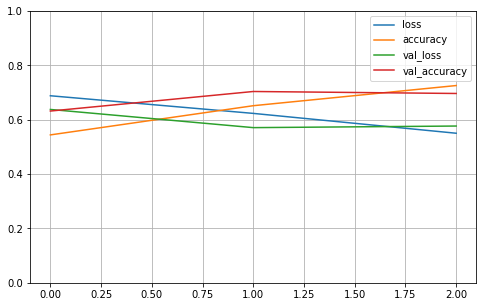

Train set ones/size 4423 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 528 / 959
Range of scores: 0.004202122 to 0.97015196
Score threshold 0.5
Prediction set ones/size 321 / 959


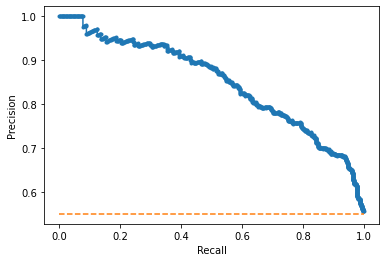

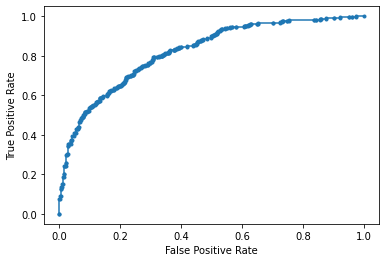

Accuracy: 69.66% Precision: 86.92% Recall: 52.84%
F1: 65.72% AUPRC: 84.98% AUROC: 82.13%
2023-02-07 00:30:31.960325
Fold 6
RCI threshold derived from training set: -0.9634300983429895
FIT
2023-02-07 00:30:35.783553
PREDICT
2023-02-07 00:30:45.336839


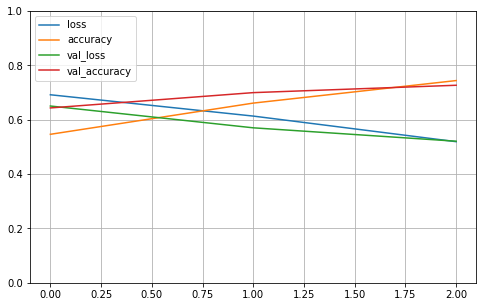

Train set ones/size 4450 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.0064033843 to 0.97834617
Score threshold 0.5
Prediction set ones/size 370 / 959


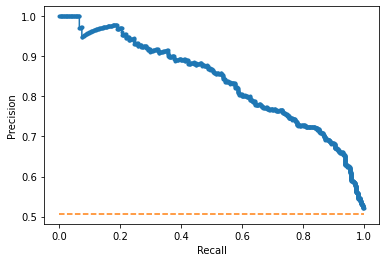

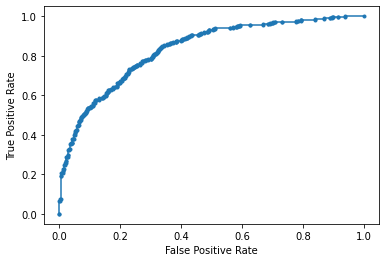

Accuracy: 72.68% Precision: 80.27% Recall: 61.11%
F1: 69.39% AUPRC: 83.77% AUROC: 83.33%
2023-02-07 00:30:46.021108
Fold 7
RCI threshold derived from training set: -0.9433161291993047
FIT
2023-02-07 00:30:49.829212
PREDICT
2023-02-07 00:31:01.234687


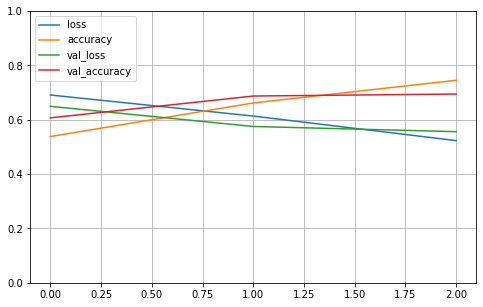

Train set ones/size 4382 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 460 / 959
Range of scores: 0.0031242992 to 0.99264175
Score threshold 0.5
Prediction set ones/size 619 / 959


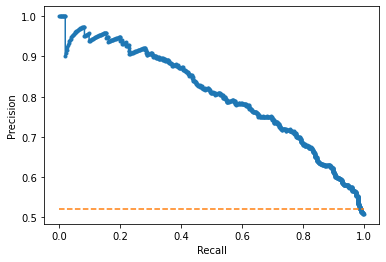

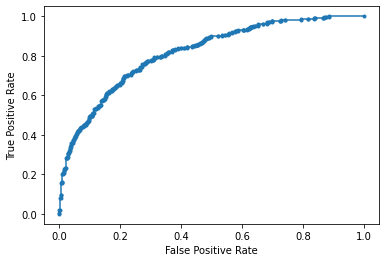

Accuracy: 69.45% Precision: 63.49% Recall: 85.43%
F1: 72.85% AUPRC: 80.49% AUROC: 81.63%
2023-02-07 00:31:01.901020
Fold 8
RCI threshold derived from training set: -0.951527679225956
FIT
2023-02-07 00:31:06.977331
PREDICT
2023-02-07 00:31:18.441477


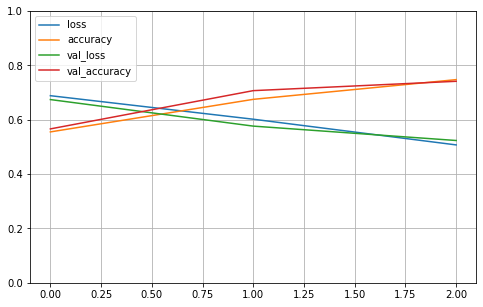

Train set ones/size 4391 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.0018889451 to 0.9803618
Score threshold 0.5
Prediction set ones/size 442 / 959


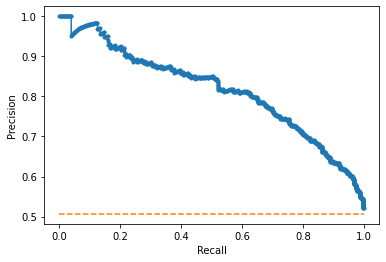

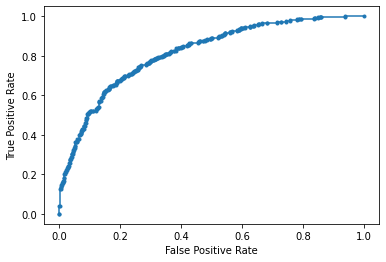

Accuracy: 74.14% Precision: 76.92% Recall: 69.96%
F1: 73.28% AUPRC: 81.70% AUROC: 81.63%
2023-02-07 00:31:19.345016
Fold 9
RCI threshold derived from training set: -0.9602096008389339
FIT
2023-02-07 00:31:23.318898
PREDICT
2023-02-07 00:31:34.663504


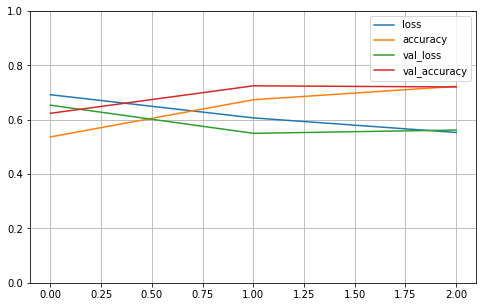

Train set ones/size 4434 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 502 / 959
Range of scores: 0.0019860647 to 0.96956795
Score threshold 0.5
Prediction set ones/size 374 / 959


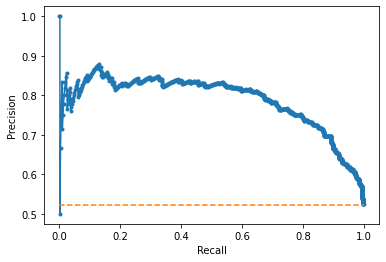

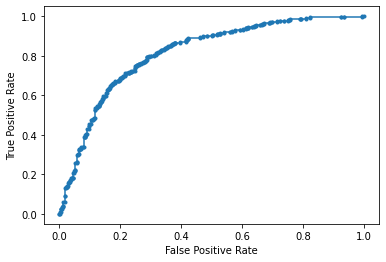

Accuracy: 72.05% Precision: 81.28% Recall: 60.56%
F1: 69.41% AUPRC: 78.79% AUROC: 81.31%
2023-02-07 00:31:35.401332
Fold 10
RCI threshold derived from training set: -0.9577084034526707
FIT
2023-02-07 00:31:39.249199
PREDICT
2023-02-07 00:31:50.581712


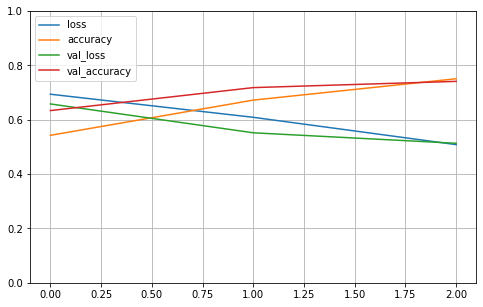

Train set ones/size 4456 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 477 / 958
Range of scores: 0.011699161 to 0.9897434
Score threshold 0.5
Prediction set ones/size 455 / 958


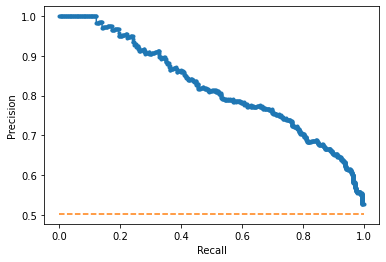

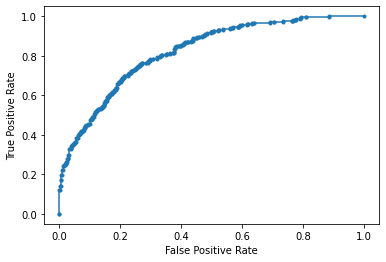

Accuracy: 74.11% Precision: 75.16% Recall: 71.70%
F1: 73.39% AUPRC: 82.14% AUROC: 82.17%
2023-02-07 00:31:51.255640

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.08% +/- 2.07
 precision mean 77.99% +/- 6.72
 recall mean 65.61% +/- 10.12
 F1 mean 70.37% +/- 3.14
 AUPRC mean 81.69% +/- 2.04
 AUROC mean 81.44% +/- 1.58
Finished cell Line 5 HUVEC

2023-02-07 00:31:52.669218
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-07 00:32:09.764672
splitting
Fold 1
RCI threshold derived from training set: -1.1349753646536942
FIT
2023-02-07 00:32:14.237039
PREDICT
2023-02-07 00:32:25.748136


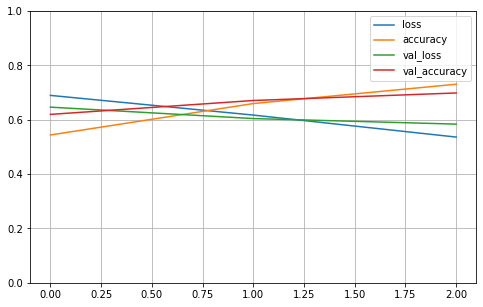

Train set ones/size 5288 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 631 / 1154
Range of scores: 0.0035346362 to 0.9787998
Score threshold 0.5
Prediction set ones/size 427 / 1154


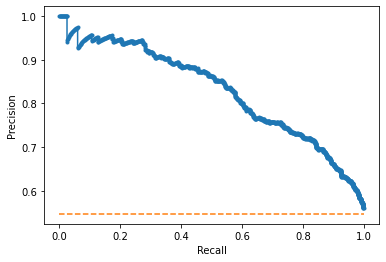

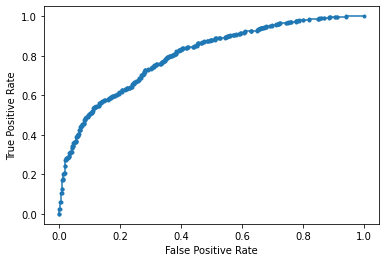

Accuracy: 69.84% Precision: 83.14% Recall: 56.26%
F1: 67.11% AUPRC: 82.97% AUROC: 80.13%
2023-02-07 00:32:26.865605
Fold 2
RCI threshold derived from training set: -1.1299156250621327
FIT
2023-02-07 00:32:31.247527
PREDICT
2023-02-07 00:32:42.786360


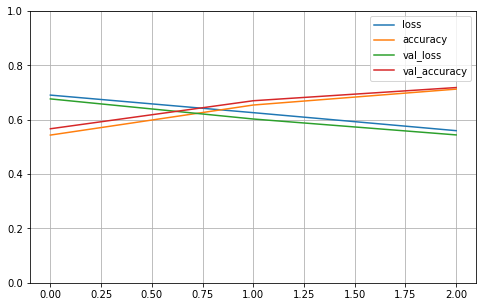

Train set ones/size 5322 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 597 / 1154
Range of scores: 0.010823884 to 0.99106836
Score threshold 0.5
Prediction set ones/size 502 / 1154


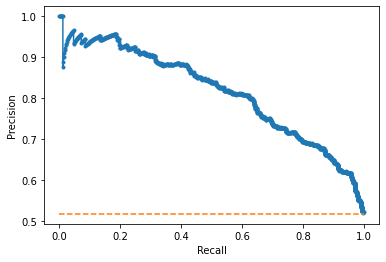

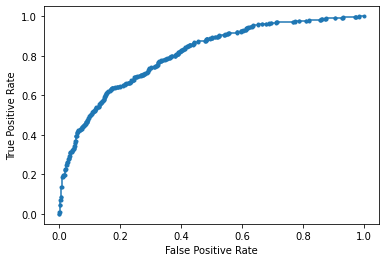

Accuracy: 71.84% Precision: 77.09% Recall: 64.82%
F1: 70.43% AUPRC: 81.49% AUROC: 80.64%
2023-02-07 00:32:43.725887
Fold 3
RCI threshold derived from training set: -1.1188958279423948
FIT
2023-02-07 00:32:48.057598
PREDICT
2023-02-07 00:32:59.446091


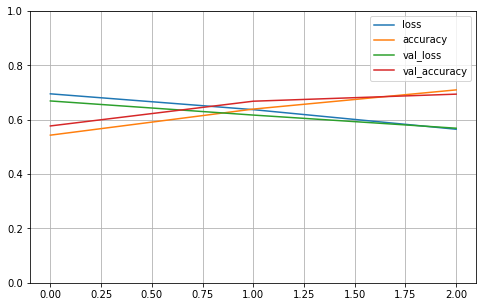

Train set ones/size 5316 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 579 / 1154
Range of scores: 0.021196155 to 0.9726962
Score threshold 0.5
Prediction set ones/size 668 / 1154


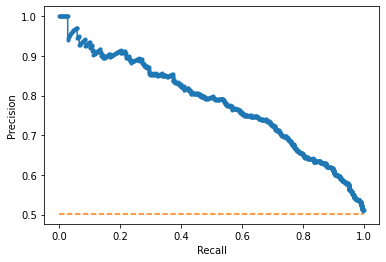

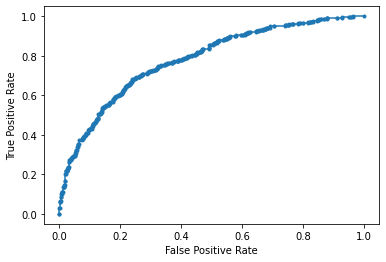

Accuracy: 69.41% Precision: 66.92% Recall: 77.20%
F1: 71.69% AUPRC: 78.17% AUROC: 78.08%
2023-02-07 00:33:00.368719
Fold 4
RCI threshold derived from training set: -1.1232048012686637
FIT
2023-02-07 00:33:05.685967
PREDICT
2023-02-07 00:33:17.348907


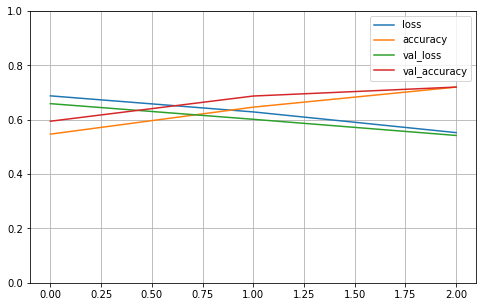

Train set ones/size 5318 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 596 / 1154
Range of scores: 0.007629332 to 0.9928681
Score threshold 0.5
Prediction set ones/size 639 / 1154


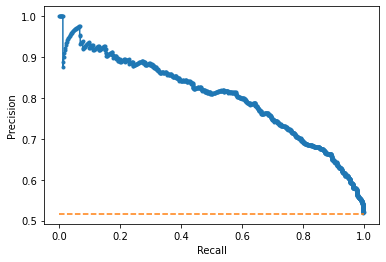

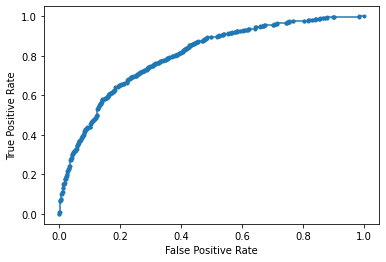

Accuracy: 72.01% Precision: 71.36% Recall: 76.51%
F1: 73.85% AUPRC: 80.25% AUROC: 80.15%
2023-02-07 00:33:18.514735
Fold 5
RCI threshold derived from training set: -1.118375560225412
FIT
2023-02-07 00:33:22.985863
PREDICT
2023-02-07 00:33:34.522492


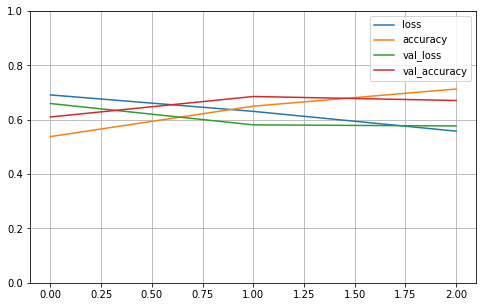

Train set ones/size 5335 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 560 / 1154
Range of scores: 0.018420434 to 0.9891194
Score threshold 0.5
Prediction set ones/size 788 / 1154


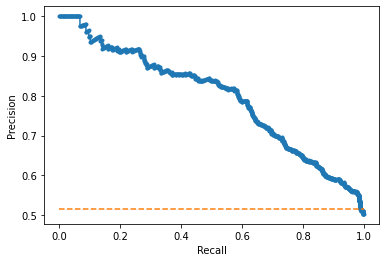

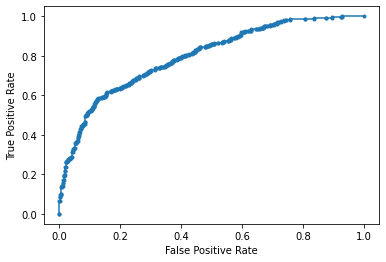

Accuracy: 67.07% Precision: 61.42% Recall: 86.43%
F1: 71.81% AUPRC: 79.54% AUROC: 79.69%
2023-02-07 00:33:35.457229
Fold 6
RCI threshold derived from training set: -1.1163208856453477
FIT
2023-02-07 00:33:39.827691
PREDICT
2023-02-07 00:33:51.369133


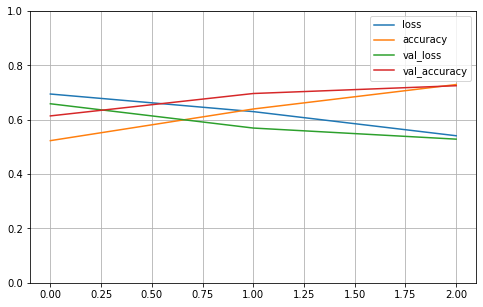

Train set ones/size 5321 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 573 / 1153
Range of scores: 0.0064197634 to 0.9836985
Score threshold 0.5
Prediction set ones/size 456 / 1153


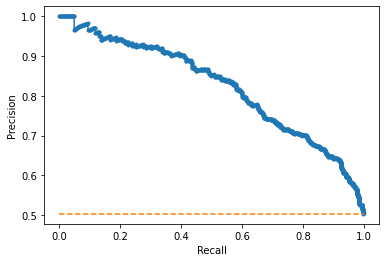

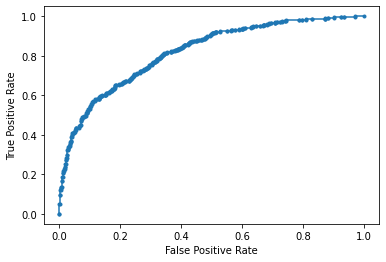

Accuracy: 72.51% Precision: 78.07% Recall: 62.13%
F1: 69.19% AUPRC: 82.34% AUROC: 82.00%
2023-02-07 00:33:52.292997
Fold 7
RCI threshold derived from training set: -1.1271018489664804
FIT
2023-02-07 00:33:57.013315
PREDICT
2023-02-07 00:34:08.700509


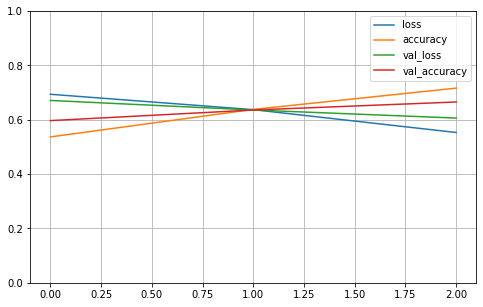

Train set ones/size 5323 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.011114265 to 0.9946385
Score threshold 0.5
Prediction set ones/size 745 / 1153


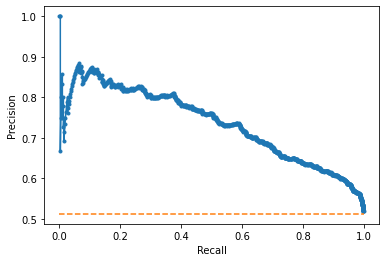

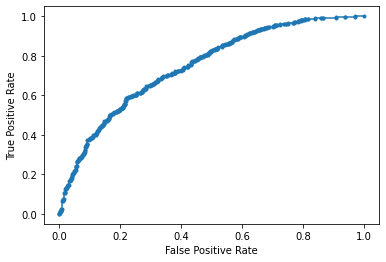

Accuracy: 66.52% Precision: 63.76% Recall: 80.37%
F1: 71.11% AUPRC: 73.58% AUROC: 74.83%
2023-02-07 00:34:09.475089
Fold 8
RCI threshold derived from training set: -1.1243382103515702
FIT
2023-02-07 00:34:14.535371
PREDICT
2023-02-07 00:34:26.010241


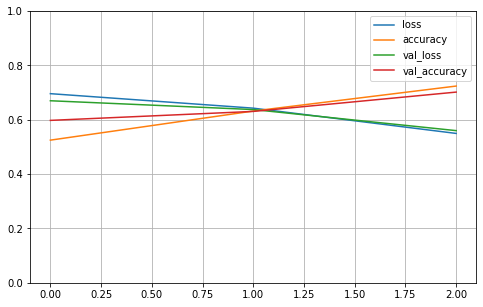

Train set ones/size 5314 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 600 / 1153
Range of scores: 0.01169947 to 0.98795253
Score threshold 0.5
Prediction set ones/size 606 / 1153


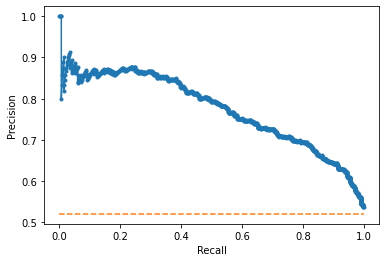

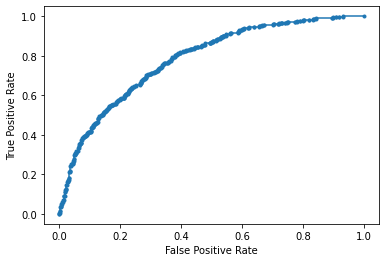

Accuracy: 70.16% Precision: 71.12% Recall: 71.83%
F1: 71.48% AUPRC: 77.54% AUROC: 78.26%
2023-02-07 00:34:26.751994
Fold 9
RCI threshold derived from training set: -1.1209396478010016
FIT
2023-02-07 00:34:31.153301
PREDICT
2023-02-07 00:34:42.620556


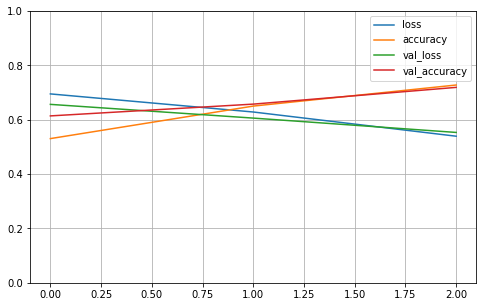

Train set ones/size 5305 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.004049231 to 0.97545445
Score threshold 0.5
Prediction set ones/size 489 / 1153


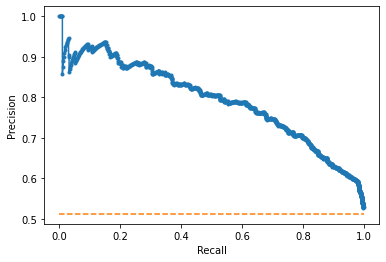

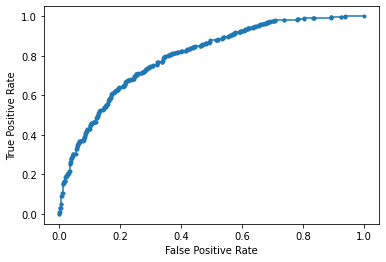

Accuracy: 71.90% Precision: 77.30% Recall: 63.96%
F1: 70.00% AUPRC: 79.33% AUROC: 79.86%
2023-02-07 00:34:43.561844
Fold 10
RCI threshold derived from training set: -1.1235682388817185
FIT
2023-02-07 00:34:47.915002
PREDICT
2023-02-07 00:34:59.557759


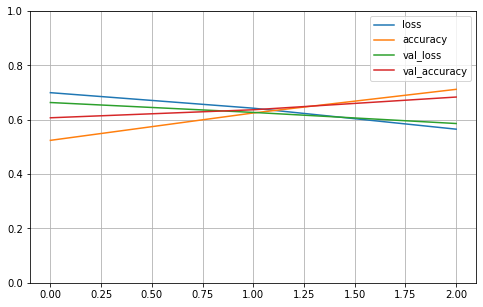

Train set ones/size 5325 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 589 / 1153
Range of scores: 0.004852121 to 0.98162353
Score threshold 0.5
Prediction set ones/size 490 / 1153


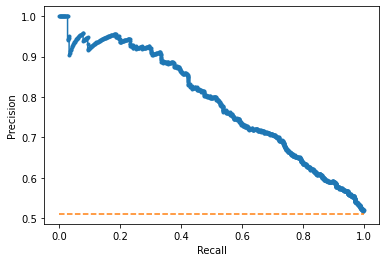

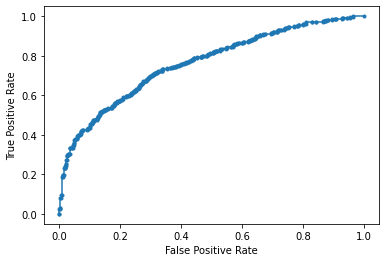

Accuracy: 68.34% Precision: 72.86% Recall: 60.61%
F1: 66.17% AUPRC: 78.69% AUROC: 76.36%
2023-02-07 00:35:00.298990

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.96% +/- 2.14
 precision mean 72.30% +/- 6.84
 recall mean 70.01% +/- 9.87
 F1 mean 70.28% +/- 2.29
 AUPRC mean 79.39% +/- 2.70
 AUROC mean 79.00% +/- 2.14
Finished cell Line 6 MCF.7

2023-02-07 00:35:01.762958
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-07 00:35:10.872704
splitting
Fold 1
RCI threshold derived from training set: -1.3083752442899723
FIT
2023-02-07 00:35:12.339868
PREDICT
2023-02-07 00:35:18.241896


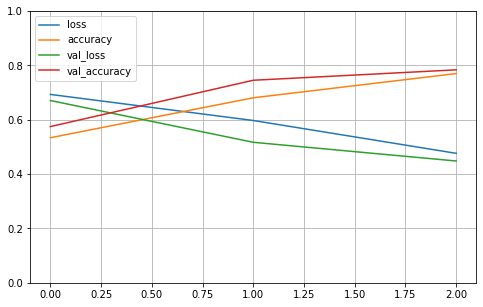

Train set ones/size 2408 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 267 / 522
Range of scores: 0.00928649 to 0.9980312
Score threshold 0.5
Prediction set ones/size 278 / 522


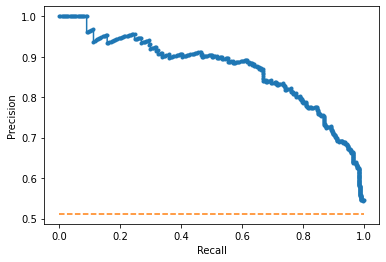

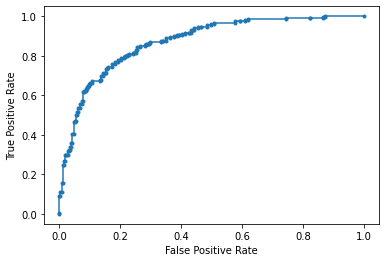

Accuracy: 78.35% Precision: 77.70% Recall: 80.90%
F1: 79.27% AUPRC: 86.94% AUROC: 87.19%
2023-02-07 00:35:19.200848
Fold 2
RCI threshold derived from training set: -1.297517116314669
FIT
2023-02-07 00:35:21.856744
PREDICT
2023-02-07 00:35:27.872080


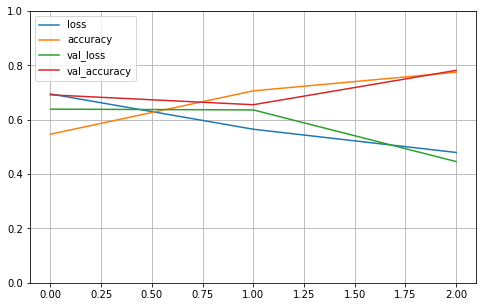

Train set ones/size 2421 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 254 / 522
Range of scores: 0.005347596 to 0.9860957
Score threshold 0.5
Prediction set ones/size 222 / 522


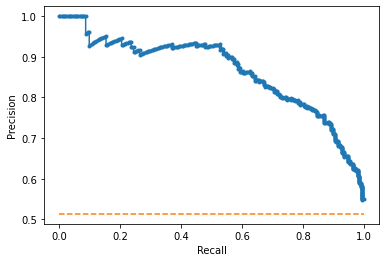

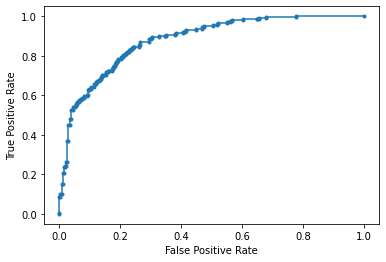

Accuracy: 78.16% Precision: 81.53% Recall: 71.26%
F1: 76.05% AUPRC: 86.57% AUROC: 87.95%
2023-02-07 00:35:28.513978
Fold 3
RCI threshold derived from training set: -1.3034471971535022
FIT
2023-02-07 00:35:32.279938
PREDICT
2023-02-07 00:35:38.329391


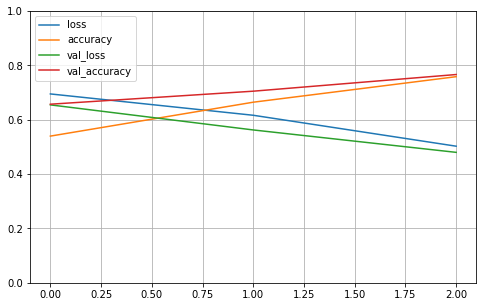

Train set ones/size 2413 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 262 / 522
Range of scores: 0.02604758 to 0.99904877
Score threshold 0.5
Prediction set ones/size 300 / 522


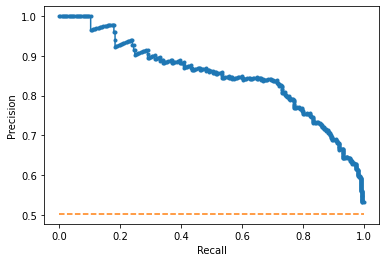

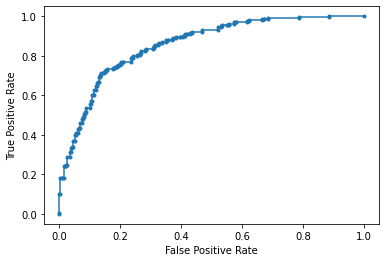

Accuracy: 76.63% Precision: 73.33% Recall: 83.97%
F1: 78.29% AUPRC: 85.01% AUROC: 85.73%
2023-02-07 00:35:39.016852
Fold 4
RCI threshold derived from training set: -1.2912956771833086
FIT
2023-02-07 00:35:41.670035
PREDICT
2023-02-07 00:35:47.866270


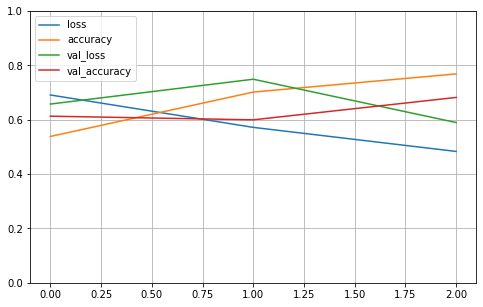

Train set ones/size 2418 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 255 / 522
Range of scores: 0.019669479 to 0.99997807
Score threshold 0.5
Prediction set ones/size 383 / 522


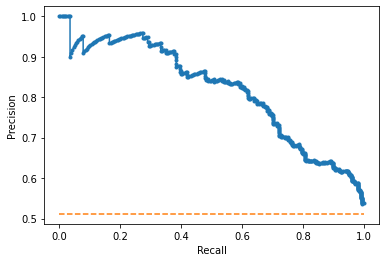

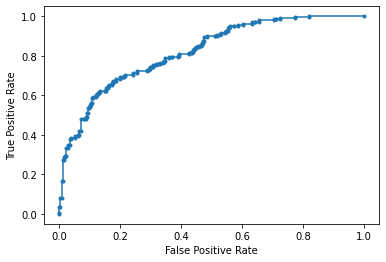

Accuracy: 68.20% Precision: 61.62% Recall: 92.55%
F1: 73.98% AUPRC: 81.80% AUROC: 82.27%
2023-02-07 00:35:48.518098
Fold 5
RCI threshold derived from training set: -1.3037518440344902
FIT
2023-02-07 00:35:51.165790
PREDICT
2023-02-07 00:35:56.993396


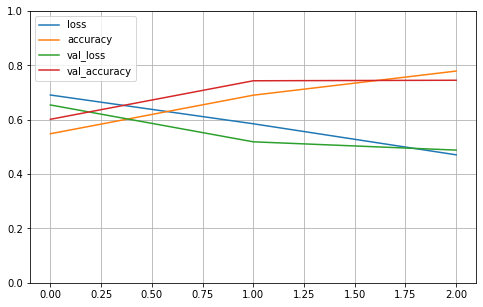

Train set ones/size 2409 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 266 / 522
Range of scores: 0.0069698356 to 0.9980357
Score threshold 0.5
Prediction set ones/size 317 / 522


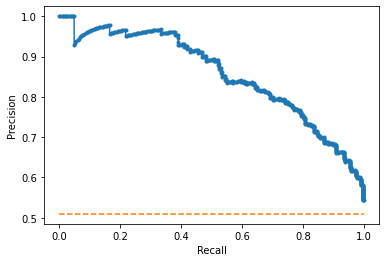

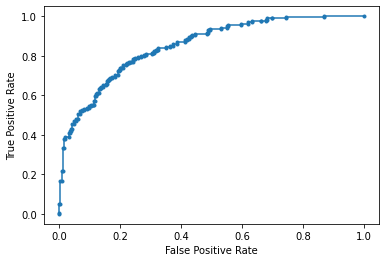

Accuracy: 74.52% Precision: 70.98% Recall: 84.59%
F1: 77.19% AUPRC: 85.72% AUROC: 85.12%
2023-02-07 00:35:57.934791
Fold 6
RCI threshold derived from training set: -1.3049483705556737
FIT
2023-02-07 00:36:00.746692
PREDICT
2023-02-07 00:36:06.412471


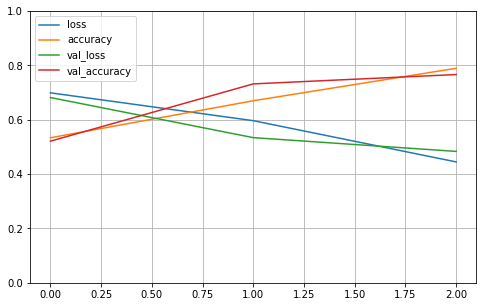

Train set ones/size 2414 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 261 / 522
Range of scores: 0.0027883481 to 0.99225086
Score threshold 0.5
Prediction set ones/size 193 / 522


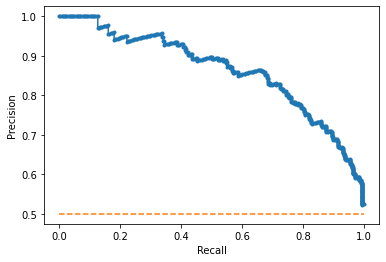

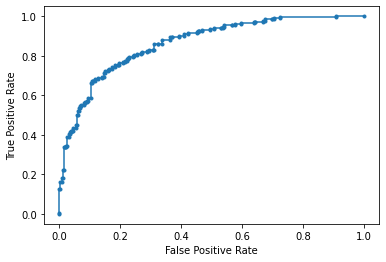

Accuracy: 76.63% Precision: 86.01% Recall: 63.60%
F1: 73.13% AUPRC: 86.47% AUROC: 86.46%
2023-02-07 00:36:07.128982
Fold 7
RCI threshold derived from training set: -1.3032546083947198
FIT
2023-02-07 00:36:10.486179
PREDICT
2023-02-07 00:36:16.579811


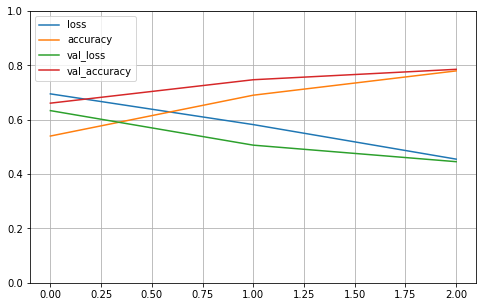

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.0046166945 to 0.99549955
Score threshold 0.5
Prediction set ones/size 301 / 522


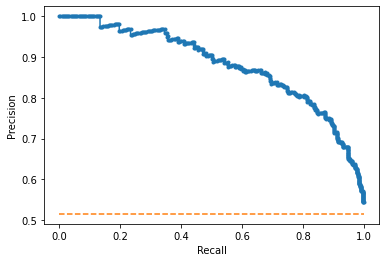

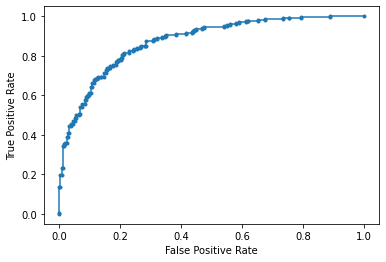

Accuracy: 78.54% Precision: 76.08% Recall: 85.13%
F1: 80.35% AUPRC: 88.17% AUROC: 87.48%
2023-02-07 00:36:17.292162
Fold 8
RCI threshold derived from training set: -1.3093740925122417
FIT
2023-02-07 00:36:19.997887
PREDICT
2023-02-07 00:36:26.017960


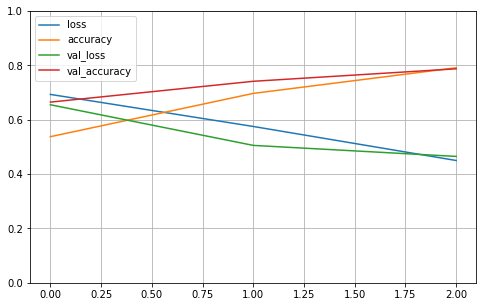

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.0031199523 to 0.99747485
Score threshold 0.5
Prediction set ones/size 254 / 522


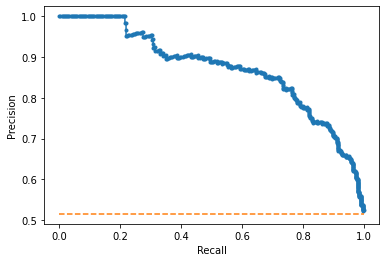

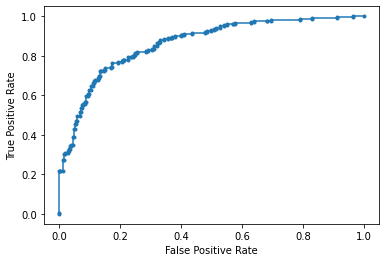

Accuracy: 78.74% Precision: 81.10% Recall: 76.58%
F1: 78.78% AUPRC: 87.17% AUROC: 86.30%
2023-02-07 00:36:26.736235
Fold 9
RCI threshold derived from training set: -1.3158440667511175
FIT
2023-02-07 00:36:29.422685
PREDICT
2023-02-07 00:36:35.037391


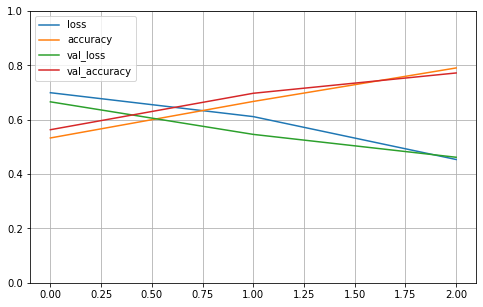

Train set ones/size 2387 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 289 / 522
Range of scores: 0.0036698773 to 0.9951952
Score threshold 0.5
Prediction set ones/size 308 / 522


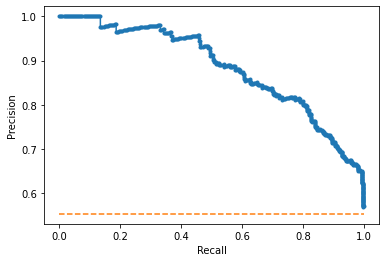

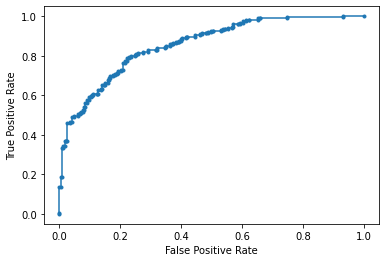

Accuracy: 77.20% Precision: 77.60% Recall: 82.70%
F1: 80.07% AUPRC: 88.46% AUROC: 85.74%
2023-02-07 00:36:35.821239
Fold 10
RCI threshold derived from training set: -1.312804497835249
FIT
2023-02-07 00:36:39.259213
PREDICT
2023-02-07 00:36:44.908472


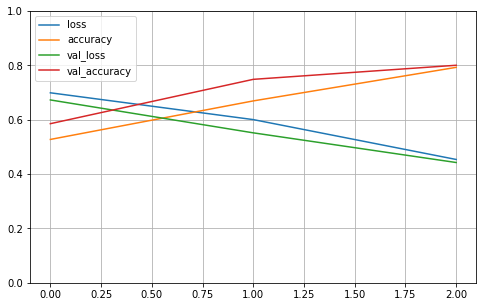

Train set ones/size 2392 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 283 / 521
Range of scores: 0.010274288 to 0.9963444
Score threshold 0.5
Prediction set ones/size 283 / 521


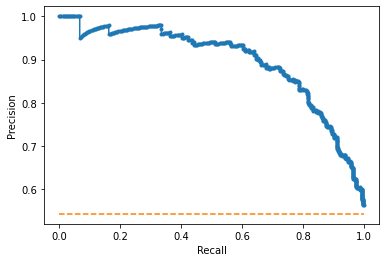

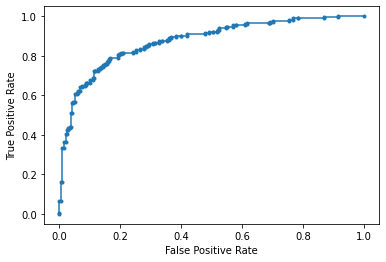

Accuracy: 80.04% Precision: 81.63% Recall: 81.63%
F1: 81.63% AUPRC: 89.67% AUROC: 87.61%
2023-02-07 00:36:45.629812

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.70% +/- 3.35
 precision mean 76.76% +/- 6.89
 recall mean 80.29% +/- 8.08
 F1 mean 77.87% +/- 2.78
 AUPRC mean 86.60% +/- 2.16
 AUROC mean 86.19% +/- 1.66
Finished cell Line 7 NCI.H460

2023-02-07 00:36:46.972229
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-07 00:37:00.085642
splitting
Fold 1
RCI threshold derived from training set: -0.653079659387811
FIT
2023-02-07 00:37:02.342968
PREDICT
2023-02-07 00:37:10.780646


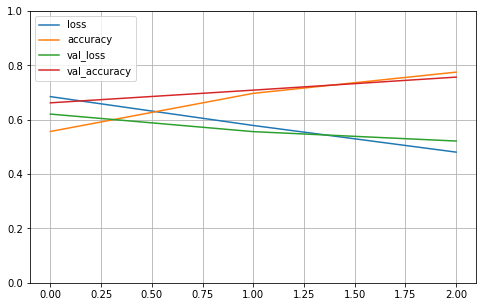

Train set ones/size 3732 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 432 / 814
Range of scores: 0.0011716294 to 0.9972504
Score threshold 0.5
Prediction set ones/size 528 / 814


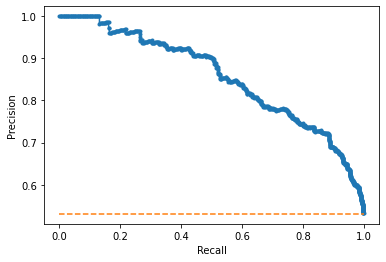

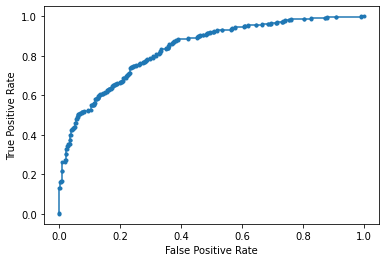

Accuracy: 75.68% Precision: 72.16% Recall: 88.19%
F1: 79.38% AUPRC: 85.62% AUROC: 83.53%
2023-02-07 00:37:11.478837
Fold 2
RCI threshold derived from training set: -0.6412958734216999
FIT
2023-02-07 00:37:15.035869
PREDICT
2023-02-07 00:37:26.577528


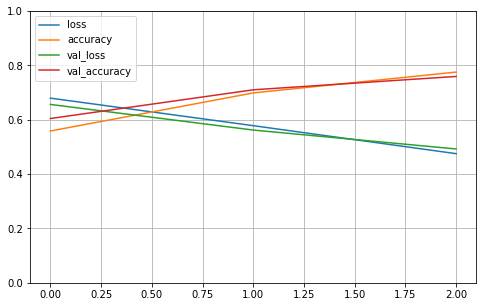

Train set ones/size 3723 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 417 / 814
Range of scores: 0.0030129177 to 0.9977627
Score threshold 0.5
Prediction set ones/size 441 / 814


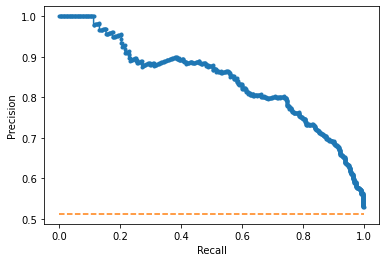

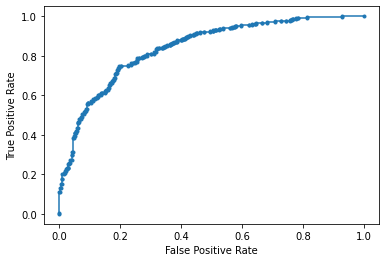

Accuracy: 75.92% Precision: 75.06% Recall: 79.38%
F1: 77.16% AUPRC: 84.26% AUROC: 84.09%
2023-02-07 00:37:27.279621
Fold 3
RCI threshold derived from training set: -0.6430724309195246
FIT
2023-02-07 00:37:32.118125
PREDICT
2023-02-07 00:37:43.501993


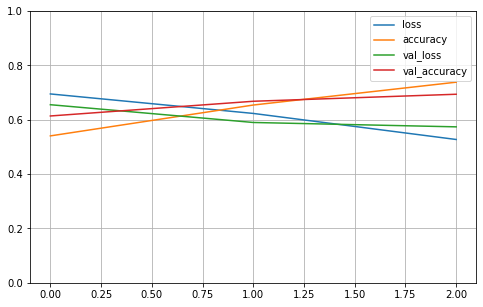

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 409 / 813
Range of scores: 0.003203575 to 0.98737633
Score threshold 0.5
Prediction set ones/size 236 / 813


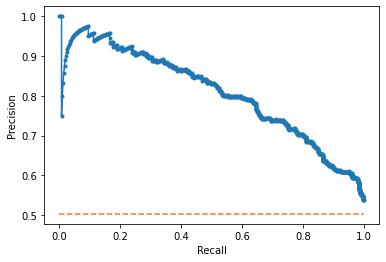

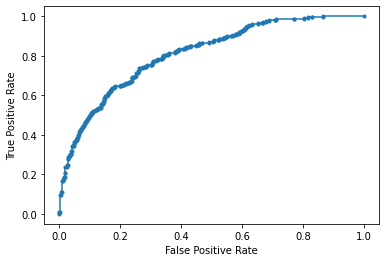

Accuracy: 69.37% Precision: 83.90% Recall: 48.41%
F1: 61.40% AUPRC: 80.78% AUROC: 81.07%
2023-02-07 00:37:44.667962
Fold 4
RCI threshold derived from training set: -0.6520008468916518
FIT
2023-02-07 00:37:48.306339
PREDICT
2023-02-07 00:37:59.597967


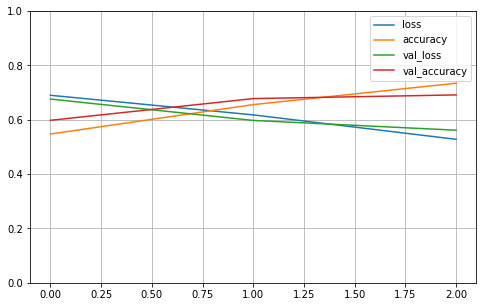

Train set ones/size 3748 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 415 / 813
Range of scores: 0.0061884956 to 0.94461894
Score threshold 0.5
Prediction set ones/size 258 / 813


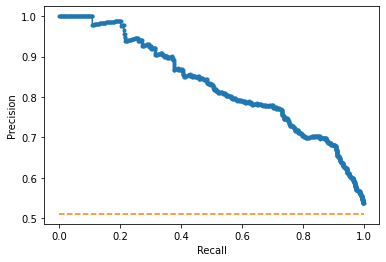

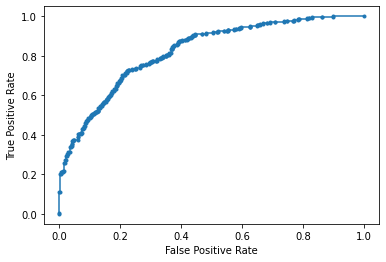

Accuracy: 69.13% Precision: 81.78% Recall: 50.84%
F1: 62.70% AUPRC: 83.12% AUROC: 82.27%
2023-02-07 00:38:00.326702
Fold 5
RCI threshold derived from training set: -0.6458179012979914
FIT
2023-02-07 00:38:03.827596
PREDICT
2023-02-07 00:38:12.131967


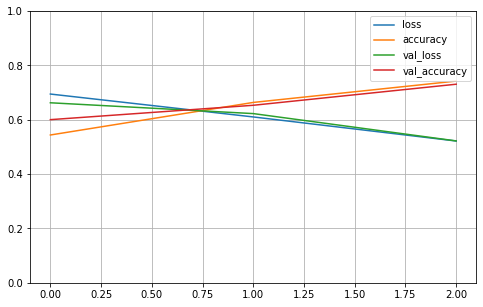

Train set ones/size 3752 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 406 / 813
Range of scores: 0.010420934 to 0.97546357
Score threshold 0.5
Prediction set ones/size 365 / 813


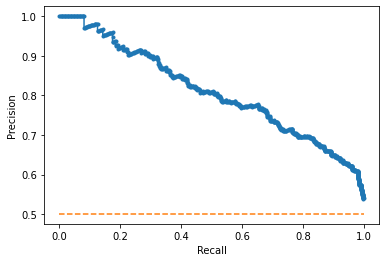

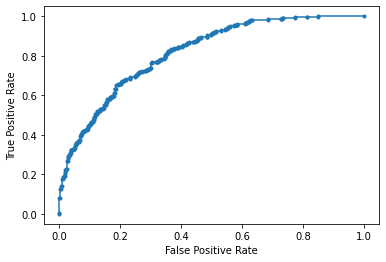

Accuracy: 73.06% Precision: 75.62% Recall: 67.98%
F1: 71.60% AUPRC: 81.12% AUROC: 81.67%
2023-02-07 00:38:12.845780
Fold 6
RCI threshold derived from training set: -0.6456534287470966
FIT
2023-02-07 00:38:16.390759
PREDICT
2023-02-07 00:38:27.686840


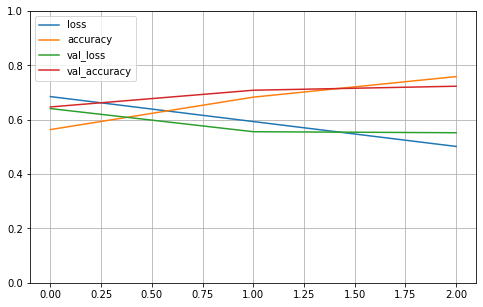

Train set ones/size 3736 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 422 / 813
Range of scores: 0.013441192 to 0.99454194
Score threshold 0.5
Prediction set ones/size 541 / 813


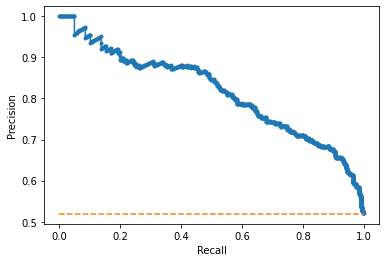

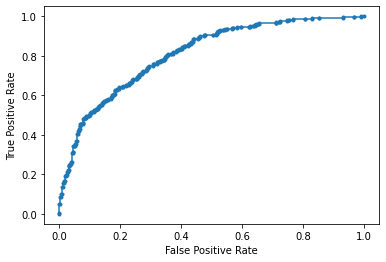

Accuracy: 72.32% Precision: 68.21% Recall: 87.44%
F1: 76.64% AUPRC: 81.58% AUROC: 81.07%
2023-02-07 00:38:28.419975
Fold 7
RCI threshold derived from training set: -0.662971660841645
FIT
2023-02-07 00:38:31.954567
PREDICT
2023-02-07 00:38:40.324630


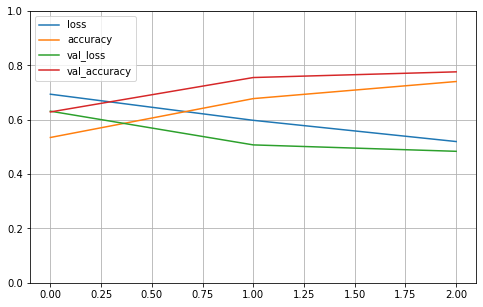

Train set ones/size 3729 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 439 / 813
Range of scores: 0.006506504 to 0.9875729
Score threshold 0.5
Prediction set ones/size 529 / 813


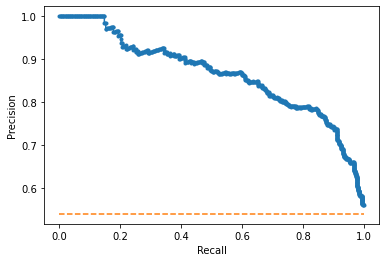

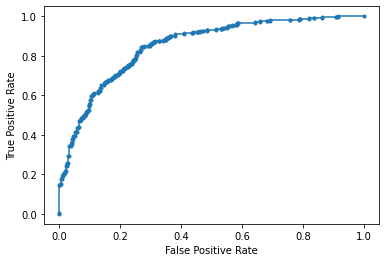

Accuracy: 77.61% Precision: 74.29% Recall: 89.52%
F1: 81.20% AUPRC: 86.54% AUROC: 85.19%
2023-02-07 00:38:41.046148
Fold 8
RCI threshold derived from training set: -0.6438629646946304
FIT
2023-02-07 00:38:44.626273
PREDICT
2023-02-07 00:38:55.968897


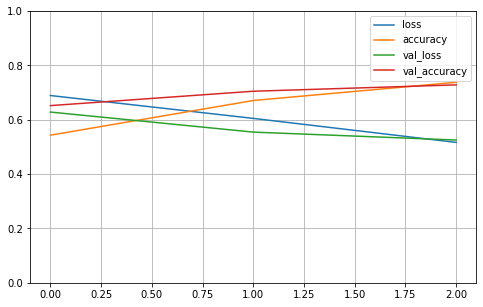

Train set ones/size 3737 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 405 / 813
Range of scores: 0.0020554976 to 0.97810227
Score threshold 0.5
Prediction set ones/size 366 / 813


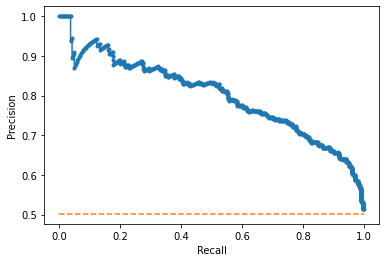

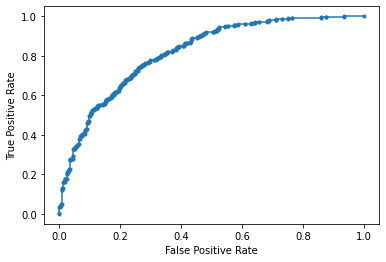

Accuracy: 72.82% Precision: 75.14% Recall: 67.90%
F1: 71.34% AUPRC: 80.07% AUROC: 81.79%
2023-02-07 00:38:56.664328
Fold 9
RCI threshold derived from training set: -0.6443524139226671
FIT
2023-02-07 00:39:00.167023
PREDICT
2023-02-07 00:39:11.478172


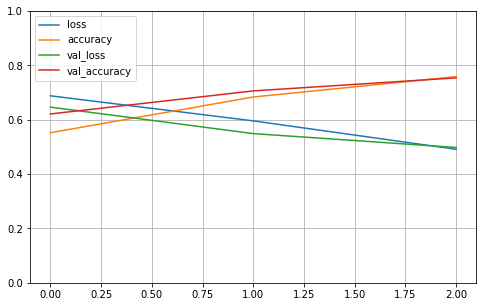

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 411 / 813
Range of scores: 0.0022499422 to 0.99522436
Score threshold 0.5
Prediction set ones/size 433 / 813


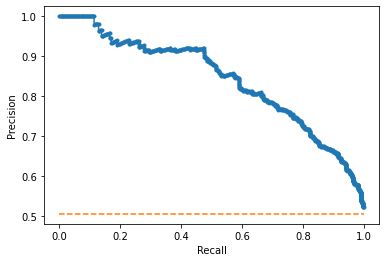

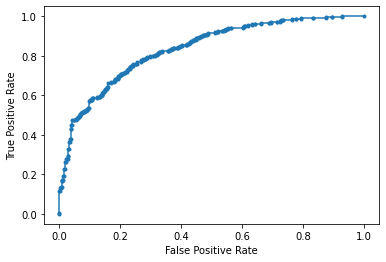

Accuracy: 75.40% Precision: 74.36% Recall: 78.35%
F1: 76.30% AUPRC: 84.27% AUROC: 83.59%
2023-02-07 00:39:12.211906
Fold 10
RCI threshold derived from training set: -0.6487705280639432
FIT
2023-02-07 00:39:16.104806
PREDICT
2023-02-07 00:39:27.748679


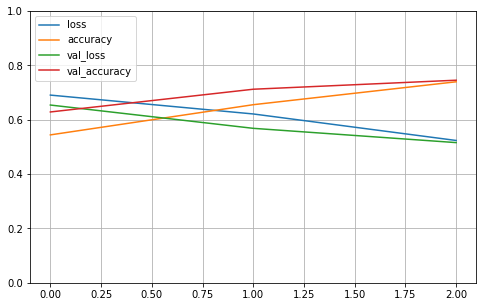

Train set ones/size 3759 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 399 / 813
Range of scores: 0.015318692 to 0.9835401
Score threshold 0.5
Prediction set ones/size 350 / 813


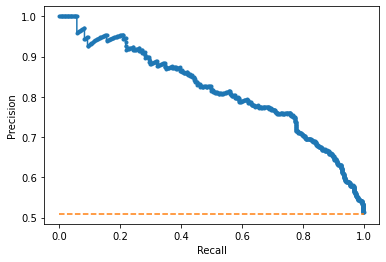

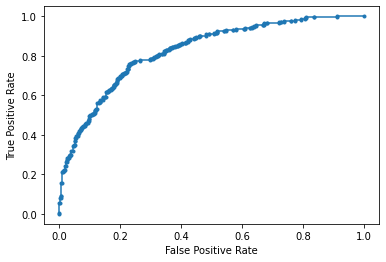

Accuracy: 74.54% Precision: 77.43% Recall: 67.92%
F1: 72.36% AUPRC: 81.63% AUROC: 82.50%
2023-02-07 00:39:28.470198

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.59% +/- 2.80
 precision mean 75.79% +/- 4.48
 recall mean 72.59% +/- 14.73
 F1 mean 73.01% +/- 6.63
 AUPRC mean 82.90% +/- 2.20
 AUROC mean 82.68% +/- 1.38
Finished cell Line 8 NHEK

2023-02-07 00:39:29.899600
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-07 00:39:38.212291
splitting
Fold 1
RCI threshold derived from training set: -1.6097299827669693
FIT
2023-02-07 00:39:39.634435
PREDICT
2023-02-07 00:39:45.507824


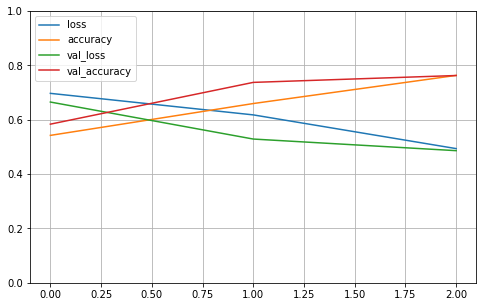

Train set ones/size 2434 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 260 / 514
Range of scores: 0.0011251903 to 0.99393916
Score threshold 0.5
Prediction set ones/size 244 / 514


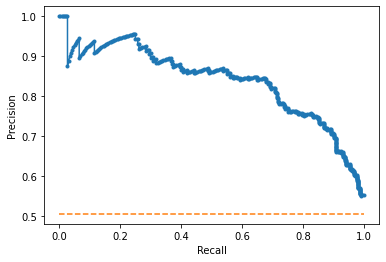

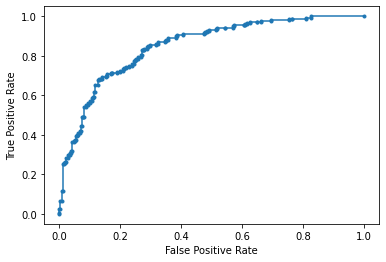

Accuracy: 76.26% Precision: 78.28% Recall: 73.46%
F1: 75.79% AUPRC: 83.94% AUROC: 85.00%
2023-02-07 00:39:46.250593
Fold 2
RCI threshold derived from training set: -1.6072797641763945
FIT
2023-02-07 00:39:48.931882
PREDICT
2023-02-07 00:39:54.357006


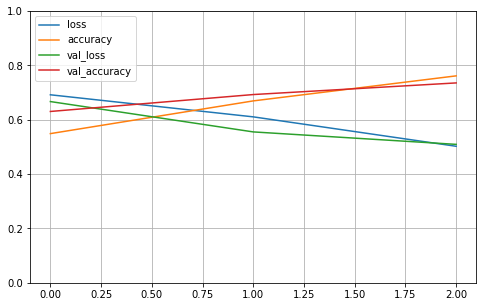

Train set ones/size 2414 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 279 / 514
Range of scores: 0.003532276 to 0.9906611
Score threshold 0.5
Prediction set ones/size 309 / 514


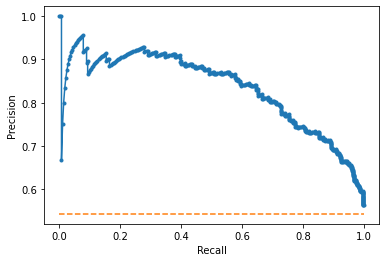

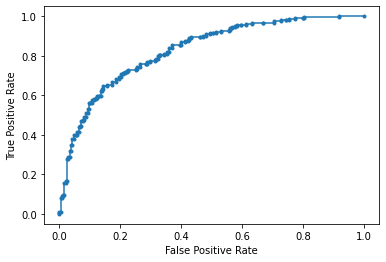

Accuracy: 73.54% Precision: 73.14% Recall: 81.00%
F1: 76.87% AUPRC: 83.41% AUROC: 82.87%
2023-02-07 00:39:55.067537
Fold 3
RCI threshold derived from training set: -1.6086752521141374
FIT
2023-02-07 00:39:58.647604
PREDICT
2023-02-07 00:40:04.671538


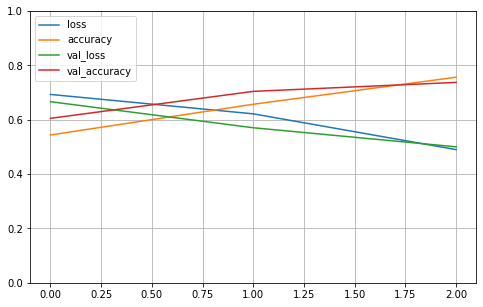

Train set ones/size 2427 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 266 / 514
Range of scores: 0.003744328 to 0.9912703
Score threshold 0.5
Prediction set ones/size 259 / 514


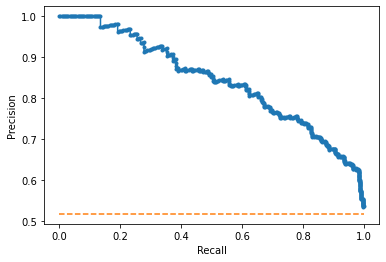

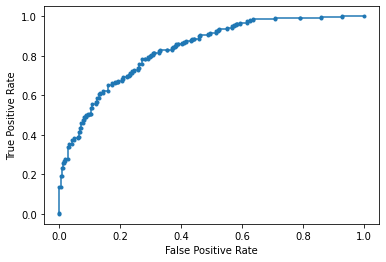

Accuracy: 73.74% Precision: 75.29% Recall: 73.31%
F1: 74.29% AUPRC: 84.41% AUROC: 83.42%
2023-02-07 00:40:05.332408
Fold 4
RCI threshold derived from training set: -1.6067064599610894
FIT
2023-02-07 00:40:08.036248
PREDICT
2023-02-07 00:40:14.323553


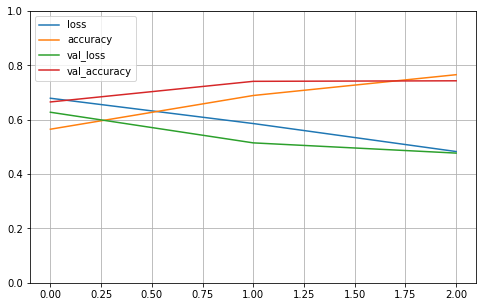

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 265 / 514
Range of scores: 0.0023786293 to 0.9878713
Score threshold 0.5
Prediction set ones/size 255 / 514


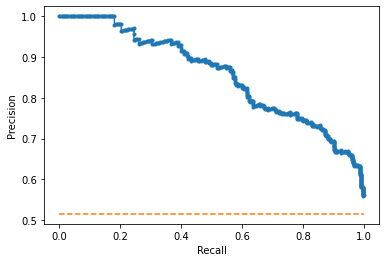

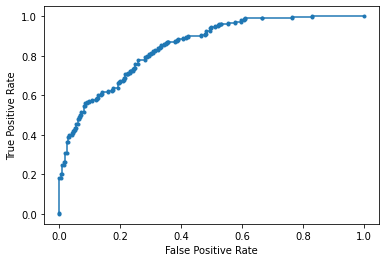

Accuracy: 74.32% Precision: 76.08% Recall: 73.21%
F1: 74.62% AUPRC: 85.69% AUROC: 84.79%
2023-02-07 00:40:14.993779
Fold 5
RCI threshold derived from training set: -1.6148654526329445
FIT
2023-02-07 00:40:17.726607
PREDICT
2023-02-07 00:40:23.326130


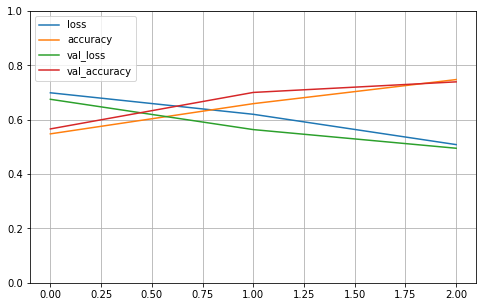

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 275 / 514
Range of scores: 0.009863529 to 0.99615735
Score threshold 0.5
Prediction set ones/size 291 / 514


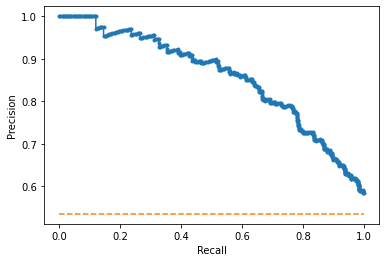

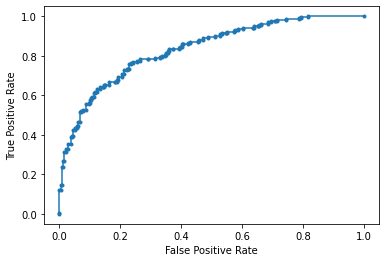

Accuracy: 73.93% Precision: 74.23% Recall: 78.55%
F1: 76.33% AUPRC: 85.78% AUROC: 83.41%
2023-02-07 00:40:24.279047
Fold 6
RCI threshold derived from training set: -1.6097505674102894
FIT
2023-02-07 00:40:27.120172
PREDICT
2023-02-07 00:40:32.509216


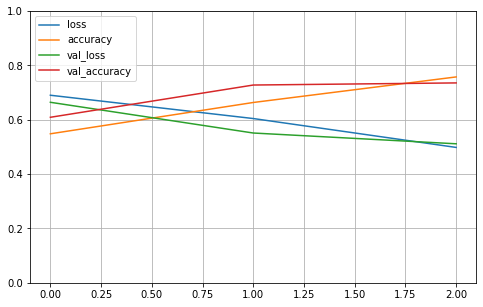

Train set ones/size 2424 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 270 / 514
Range of scores: 0.0063607492 to 0.99681985
Score threshold 0.5
Prediction set ones/size 308 / 514


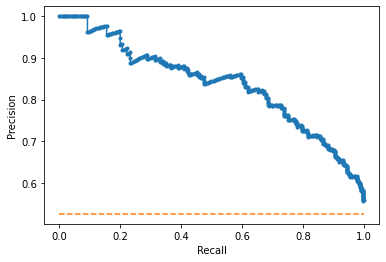

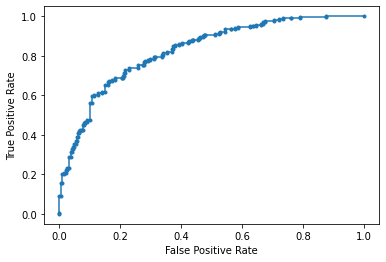

Accuracy: 73.54% Precision: 71.75% Recall: 81.85%
F1: 76.47% AUPRC: 83.81% AUROC: 82.82%
2023-02-07 00:40:33.189252
Fold 7
RCI threshold derived from training set: -1.625522115170774
FIT
2023-02-07 00:40:36.381840
PREDICT
2023-02-07 00:40:42.703533


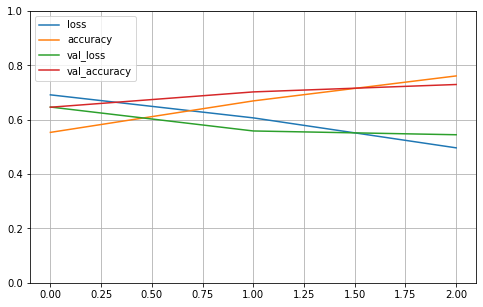

Train set ones/size 2421 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 282 / 514
Range of scores: 0.0018212836 to 0.989279
Score threshold 0.5
Prediction set ones/size 253 / 514


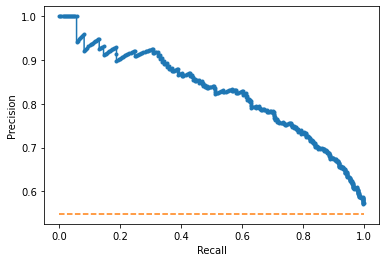

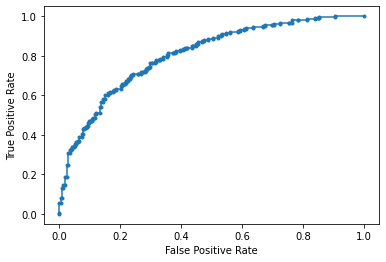

Accuracy: 72.96% Precision: 78.26% Recall: 70.21%
F1: 74.02% AUPRC: 82.78% AUROC: 80.50%
2023-02-07 00:40:43.351153
Fold 8
RCI threshold derived from training set: -1.6139277325940338
FIT
2023-02-07 00:40:46.051242
PREDICT
2023-02-07 00:40:51.871087


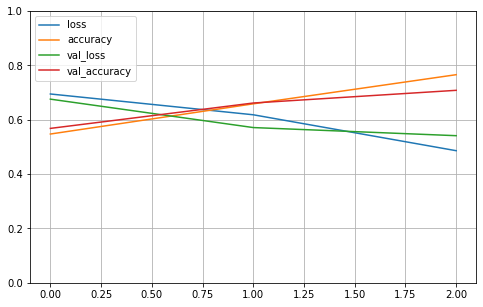

Train set ones/size 2442 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 261 / 514
Range of scores: 0.0037402483 to 0.9886817
Score threshold 0.5
Prediction set ones/size 223 / 514


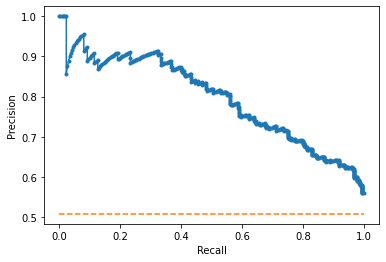

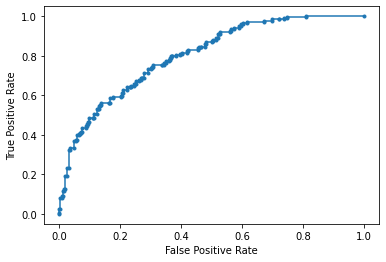

Accuracy: 70.82% Precision: 74.89% Recall: 63.98%
F1: 69.01% AUPRC: 79.67% AUROC: 80.23%
2023-02-07 00:40:52.683457
Fold 9
RCI threshold derived from training set: -1.6240643330393427
FIT
2023-02-07 00:40:55.345954
PREDICT
2023-02-07 00:41:01.358437


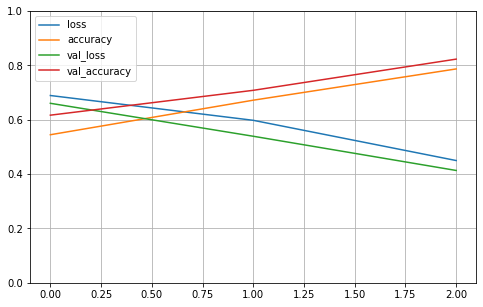

Train set ones/size 2415 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 288 / 514
Range of scores: 0.00039306434 to 0.9963625
Score threshold 0.5
Prediction set ones/size 275 / 514


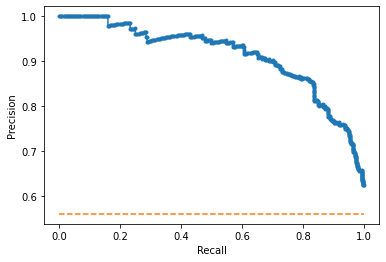

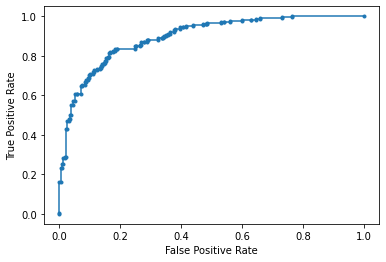

Accuracy: 82.30% Precision: 85.82% Recall: 81.94%
F1: 83.84% AUPRC: 91.36% AUROC: 89.53%
2023-02-07 00:41:02.032688
Fold 10
RCI threshold derived from training set: -1.5917950430134025
FIT
2023-02-07 00:41:05.569838
PREDICT
2023-02-07 00:41:11.584109


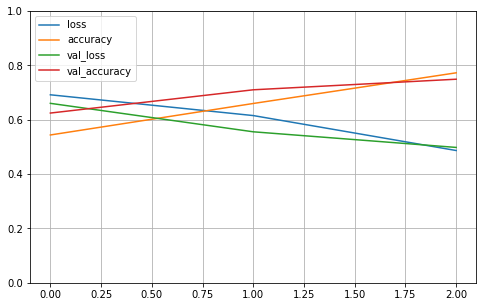

Train set ones/size 2403 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 250 / 514
Range of scores: 0.0035614902 to 0.9952264
Score threshold 0.5
Prediction set ones/size 289 / 514


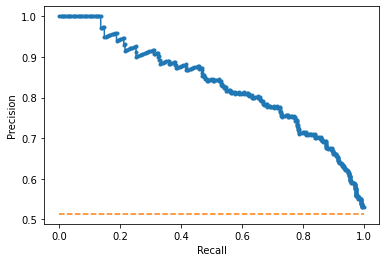

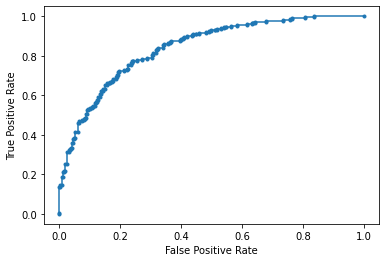

Accuracy: 74.90% Precision: 70.93% Recall: 82.00%
F1: 76.07% AUPRC: 83.21% AUROC: 84.13%
2023-02-07 00:41:12.247717

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.63% +/- 3.03
 precision mean 75.87% +/- 4.26
 recall mean 75.95% +/- 6.11
 F1 mean 75.73% +/- 3.64
 AUPRC mean 84.41% +/- 2.98
 AUROC mean 83.67% +/- 2.60
Finished cell Line 9 SK.MEL.5

2023-02-07 00:41:13.571859
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-07 00:41:23.861584
splitting
Fold 1
RCI threshold derived from training set: -0.6281296777050442
FIT
2023-02-07 00:41:25.422266
PREDICT
2023-02-07 00:41:31.744819


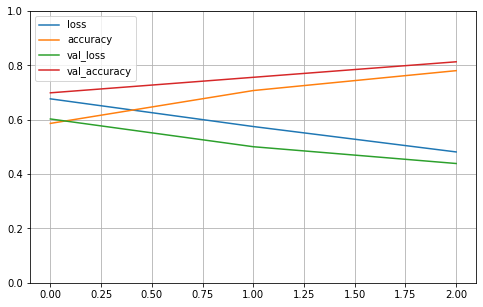

Train set ones/size 2971 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 334 / 578
Range of scores: 0.029495448 to 0.9969079
Score threshold 0.5
Prediction set ones/size 390 / 578


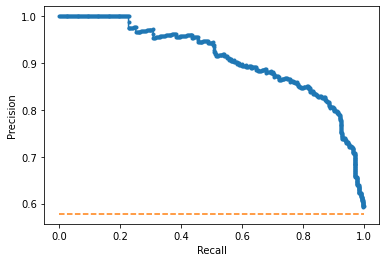

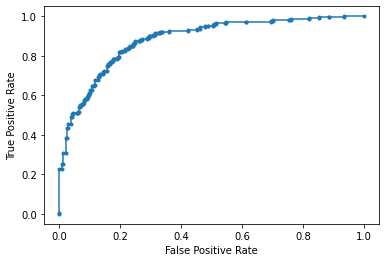

Accuracy: 81.31% Precision: 78.97% Recall: 92.22%
F1: 85.08% AUPRC: 91.00% AUROC: 88.18%
2023-02-07 00:41:32.678724
Fold 2
RCI threshold derived from training set: -0.6153963924797844
FIT
2023-02-07 00:41:35.625342
PREDICT
2023-02-07 00:41:41.687514


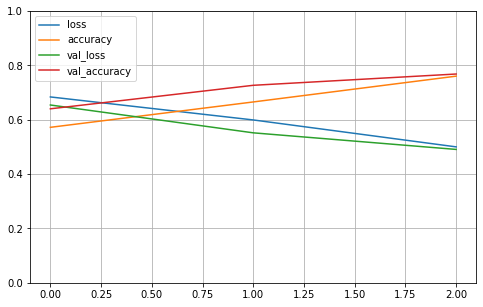

Train set ones/size 2979 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 324 / 578
Range of scores: 0.0070279026 to 0.9965706
Score threshold 0.5
Prediction set ones/size 358 / 578


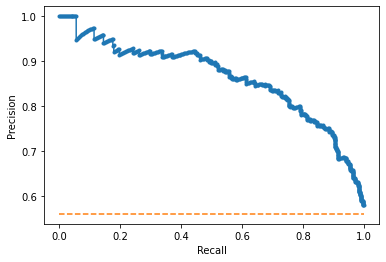

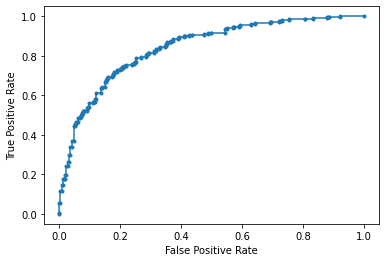

Accuracy: 76.82% Precision: 76.54% Recall: 84.57%
F1: 80.35% AUPRC: 86.38% AUROC: 84.21%
2023-02-07 00:41:42.398539
Fold 3
RCI threshold derived from training set: -0.6143647613782484
FIT
2023-02-07 00:41:46.171618
PREDICT
2023-02-07 00:41:52.236513


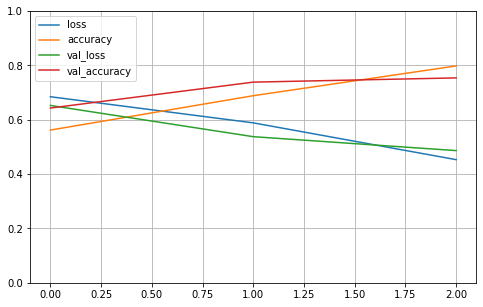

Train set ones/size 2976 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 326 / 577
Range of scores: 0.0036265703 to 0.99908984
Score threshold 0.5
Prediction set ones/size 416 / 577


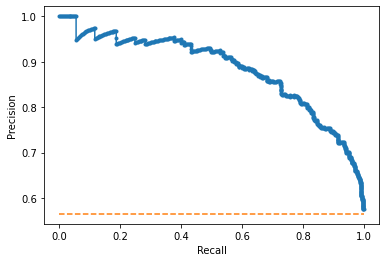

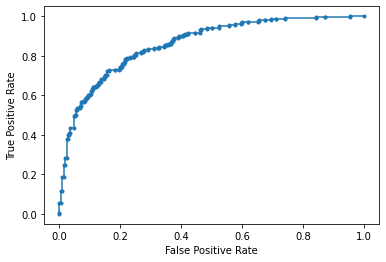

Accuracy: 75.39% Precision: 72.12% Recall: 92.02%
F1: 80.86% AUPRC: 88.41% AUROC: 86.10%
2023-02-07 00:41:52.910020
Fold 4
RCI threshold derived from training set: -0.6185031523464869
FIT
2023-02-07 00:41:55.885712
PREDICT
2023-02-07 00:42:07.483581


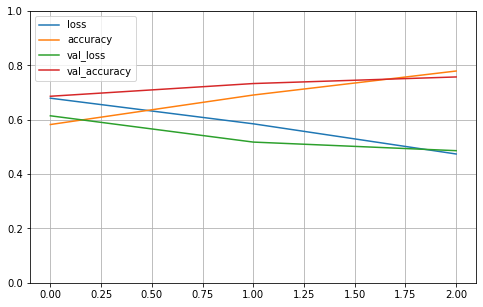

Train set ones/size 2970 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.002721763 to 0.9983399
Score threshold 0.5
Prediction set ones/size 410 / 577


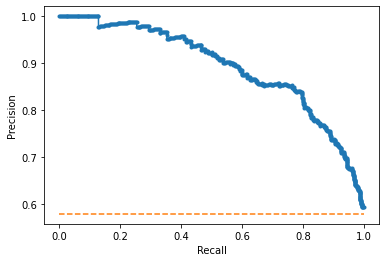

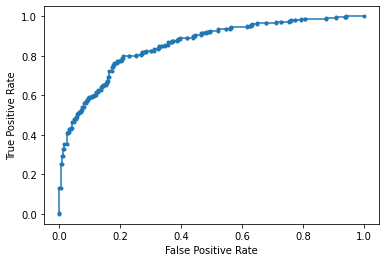

Accuracy: 75.74% Precision: 73.66% Recall: 90.42%
F1: 81.18% AUPRC: 89.37% AUROC: 85.46%
2023-02-07 00:42:08.199121
Fold 5
RCI threshold derived from training set: -0.6135521460789221
FIT
2023-02-07 00:42:12.285395
PREDICT
2023-02-07 00:42:18.401926


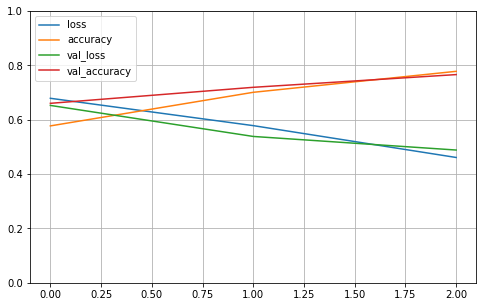

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 314 / 577
Range of scores: 0.0043546516 to 0.99963784
Score threshold 0.5
Prediction set ones/size 383 / 577


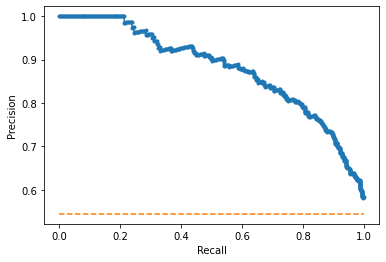

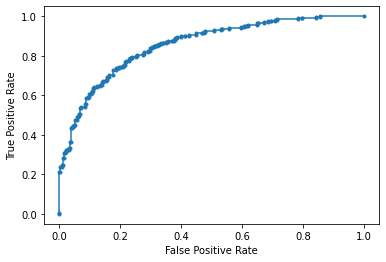

Accuracy: 76.60% Precision: 73.37% Recall: 89.49%
F1: 80.63% AUPRC: 87.97% AUROC: 85.61%
2023-02-07 00:42:19.113463
Fold 6
RCI threshold derived from training set: -0.6120151131145332
FIT
2023-02-07 00:42:21.981108
PREDICT
2023-02-07 00:42:28.445075


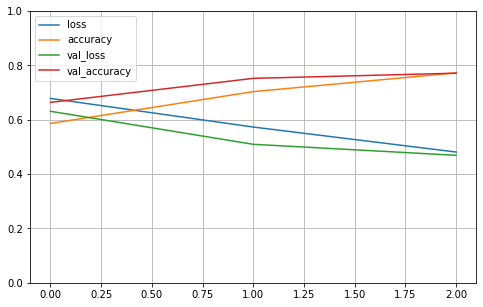

Train set ones/size 2974 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 318 / 577
Range of scores: 0.04041426 to 0.99802303
Score threshold 0.5
Prediction set ones/size 384 / 577


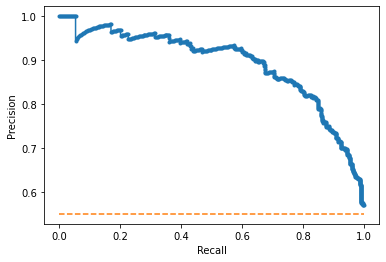

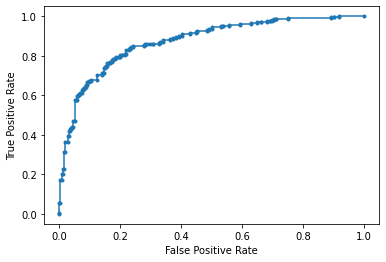

Accuracy: 77.12% Precision: 74.22% Recall: 89.62%
F1: 81.20% AUPRC: 89.30% AUROC: 87.44%
2023-02-07 00:42:29.152347
Fold 7
RCI threshold derived from training set: -0.6226585323926853
FIT
2023-02-07 00:42:32.041608
PREDICT
2023-02-07 00:42:43.200833


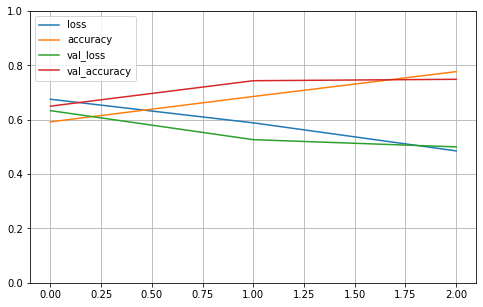

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 327 / 577
Range of scores: 0.0029203477 to 0.99878293
Score threshold 0.5
Prediction set ones/size 442 / 577


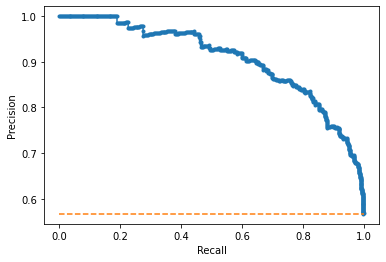

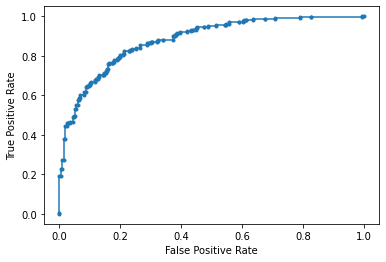

Accuracy: 74.87% Precision: 70.59% Recall: 95.41%
F1: 81.14% AUPRC: 90.69% AUROC: 88.05%
2023-02-07 00:42:43.873271
Fold 8
RCI threshold derived from training set: -0.6264152809682387
FIT
2023-02-07 00:42:46.742398
PREDICT
2023-02-07 00:42:57.916114


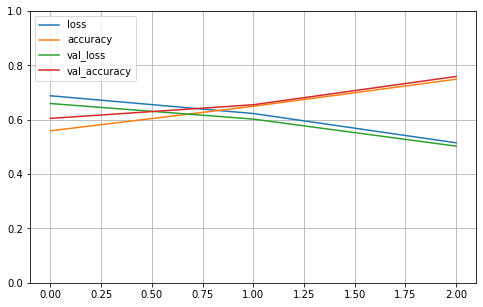

Train set ones/size 2957 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 348 / 577
Range of scores: 0.030306982 to 0.99378777
Score threshold 0.5
Prediction set ones/size 419 / 577


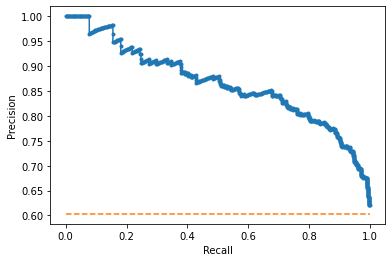

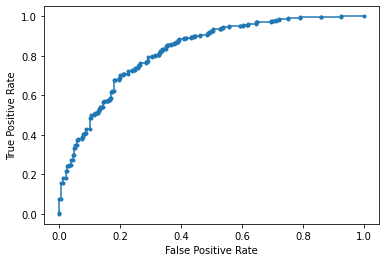

Accuracy: 75.91% Precision: 74.94% Recall: 90.23%
F1: 81.88% AUPRC: 86.53% AUROC: 82.44%
2023-02-07 00:42:58.636418
Fold 9
RCI threshold derived from training set: -0.6273904246448507
FIT
2023-02-07 00:43:01.466482
PREDICT
2023-02-07 00:43:12.655601


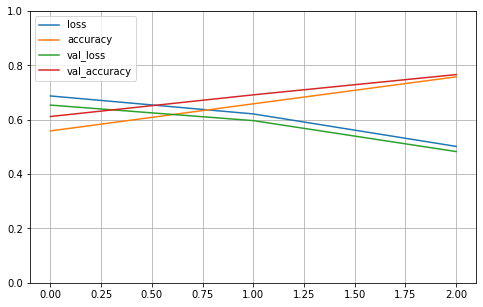

Train set ones/size 2965 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 340 / 577
Range of scores: 0.00036609938 to 0.99726415
Score threshold 0.5
Prediction set ones/size 421 / 577


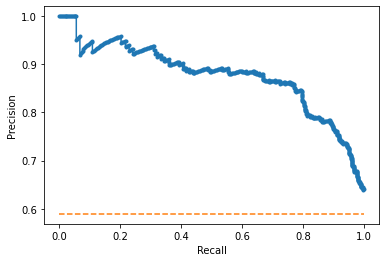

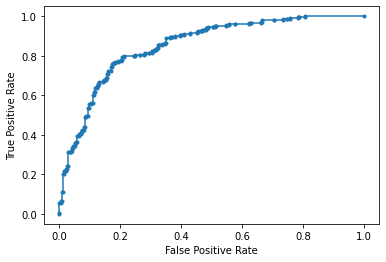

Accuracy: 76.60% Precision: 74.35% Recall: 92.06%
F1: 82.26% AUPRC: 87.73% AUROC: 85.25%
2023-02-07 00:43:13.350435
Fold 10
RCI threshold derived from training set: -0.6130283155322426
FIT
2023-02-07 00:43:16.441346
PREDICT
2023-02-07 00:43:22.813688


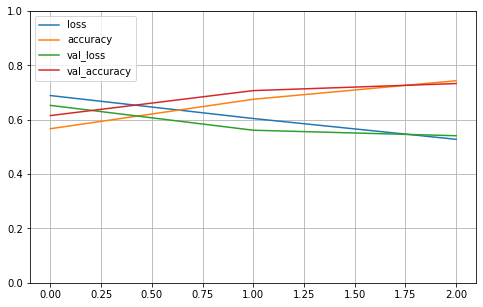

Train set ones/size 2958 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.07146417 to 0.9970145
Score threshold 0.5
Prediction set ones/size 442 / 577


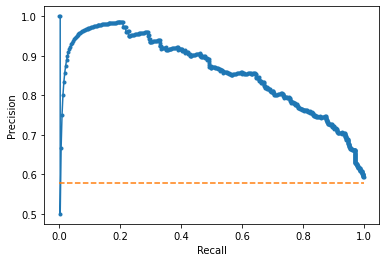

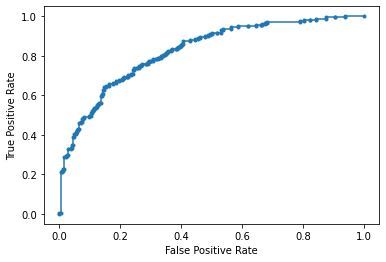

Accuracy: 73.31% Precision: 70.36% Recall: 93.11%
F1: 80.15% AUPRC: 85.85% AUROC: 82.48%
2023-02-07 00:43:23.544710

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.37% +/- 2.07
 precision mean 73.91% +/- 2.61
 recall mean 90.92% +/- 2.87
 F1 mean 81.47% +/- 1.42
 AUPRC mean 88.32% +/- 1.78
 AUROC mean 85.52% +/- 2.06
Finished cell Line 10 SK.N.DZ

2023-02-07 00:43:24.902458
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-07 00:43:41.336054
splitting
Fold 1
RCI threshold derived from training set: -0.9625358854186823
FIT
2023-02-07 00:43:44.680375
PREDICT
2023-02-07 00:43:54.672428


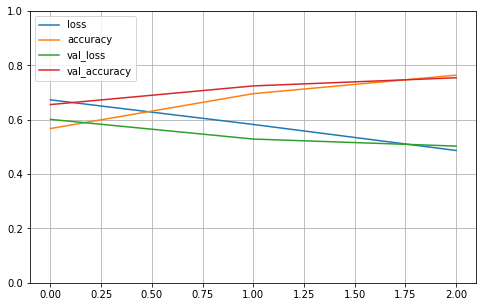

Train set ones/size 4791 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 542 / 1034
Range of scores: 0.003076566 to 0.99717534
Score threshold 0.5
Prediction set ones/size 474 / 1034


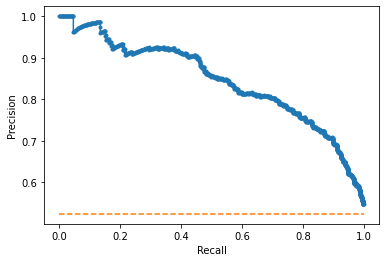

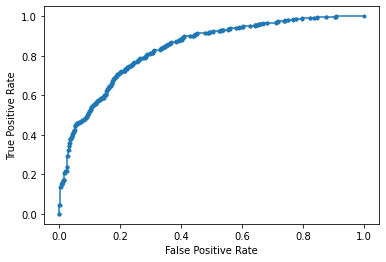

Accuracy: 75.44% Precision: 80.38% Recall: 70.30%
F1: 75.00% AUPRC: 84.58% AUROC: 83.72%
2023-02-07 00:43:55.406331
Fold 2
RCI threshold derived from training set: -0.9590621364119102
FIT
2023-02-07 00:44:00.892865
PREDICT
2023-02-07 00:44:10.716552


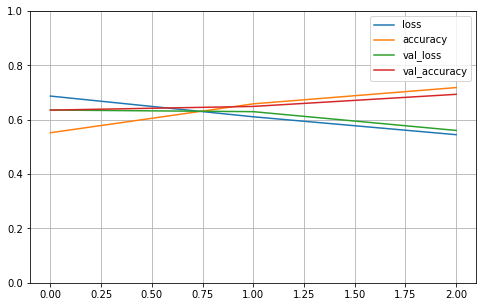

Train set ones/size 4809 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 524 / 1034
Range of scores: 0.008029244 to 0.99617815
Score threshold 0.5
Prediction set ones/size 755 / 1034


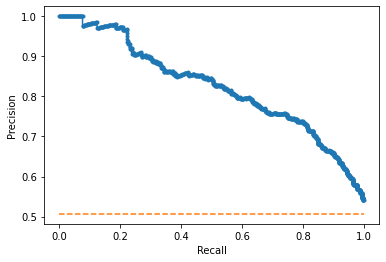

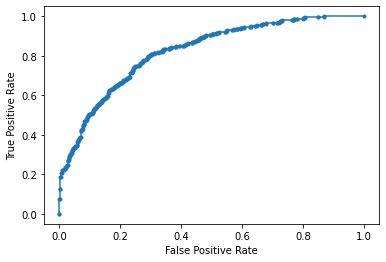

Accuracy: 69.34% Precision: 63.71% Recall: 91.79%
F1: 75.22% AUPRC: 82.53% AUROC: 82.20%
2023-02-07 00:44:11.809787
Fold 3
RCI threshold derived from training set: -0.9621559835676664
FIT
2023-02-07 00:44:17.370174
PREDICT
2023-02-07 00:44:27.155021


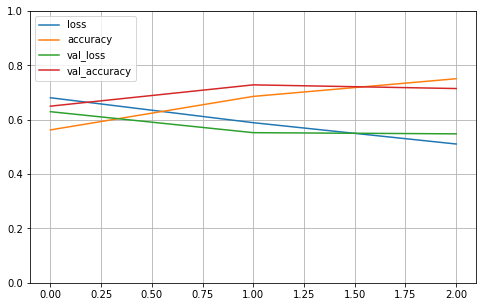

Train set ones/size 4773 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 560 / 1034
Range of scores: 0.010432009 to 0.9968079
Score threshold 0.5
Prediction set ones/size 491 / 1034


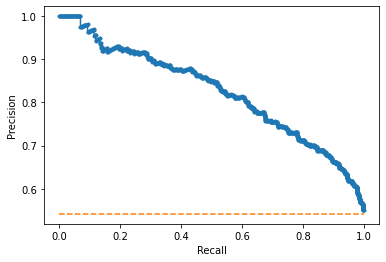

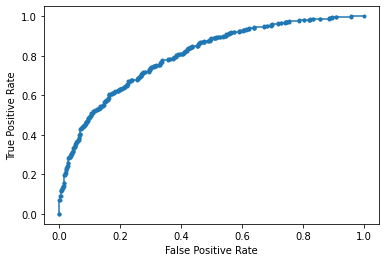

Accuracy: 71.47% Precision: 76.99% Recall: 67.50%
F1: 71.93% AUPRC: 82.49% AUROC: 80.04%
2023-02-07 00:44:28.257720
Fold 4
RCI threshold derived from training set: -0.958191079807589
FIT
2023-02-07 00:44:32.453953
PREDICT
2023-02-07 00:44:42.588606


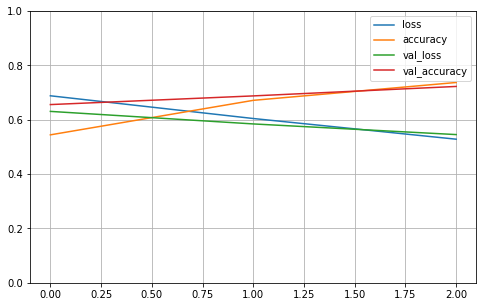

Train set ones/size 4790 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 543 / 1034
Range of scores: 0.0050951946 to 0.98910064
Score threshold 0.5
Prediction set ones/size 472 / 1034


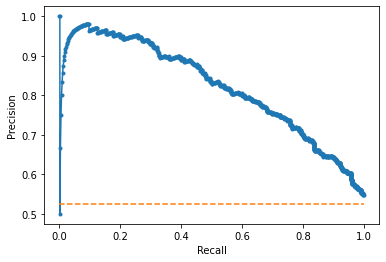

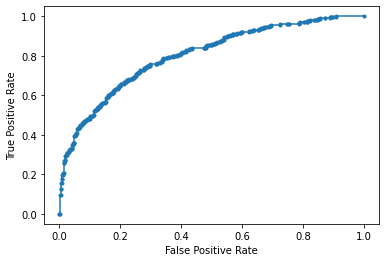

Accuracy: 72.24% Precision: 77.12% Recall: 67.03%
F1: 71.72% AUPRC: 82.09% AUROC: 80.21%
2023-02-07 00:44:43.348190
Fold 5
RCI threshold derived from training set: -0.9628417059926905
FIT
2023-02-07 00:44:48.545026
PREDICT
2023-02-07 00:45:00.149574


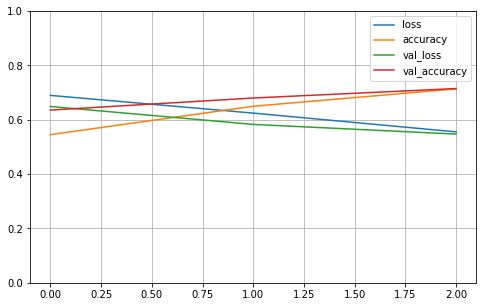

Train set ones/size 4792 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 541 / 1034
Range of scores: 0.01889324 to 0.96264327
Score threshold 0.5
Prediction set ones/size 536 / 1034


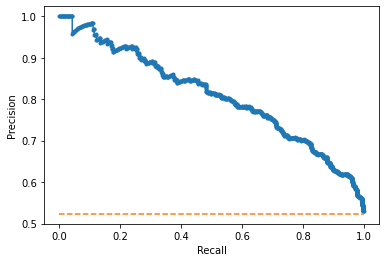

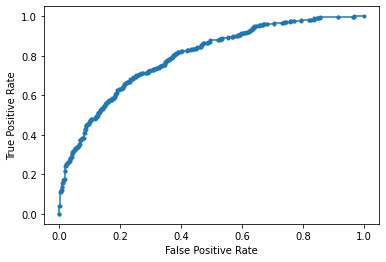

Accuracy: 71.47% Precision: 72.95% Recall: 72.27%
F1: 72.61% AUPRC: 80.95% AUROC: 79.51%
2023-02-07 00:45:00.874615
Fold 6
RCI threshold derived from training set: -0.9595112937514781
FIT
2023-02-07 00:45:04.918432
PREDICT
2023-02-07 00:45:16.602447


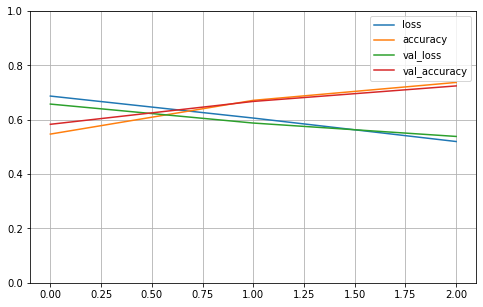

Train set ones/size 4793 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 540 / 1034
Range of scores: 0.004720029 to 0.99667907
Score threshold 0.5
Prediction set ones/size 701 / 1034


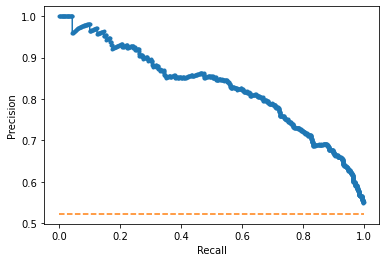

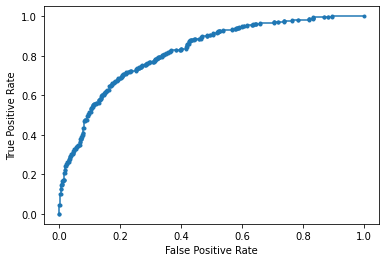

Accuracy: 72.44% Precision: 68.19% Recall: 88.52%
F1: 77.03% AUPRC: 82.81% AUROC: 82.08%
2023-02-07 00:45:17.378385
Fold 7
RCI threshold derived from training set: -0.9601035896538751
FIT
2023-02-07 00:45:23.589226
PREDICT
2023-02-07 00:45:33.630123


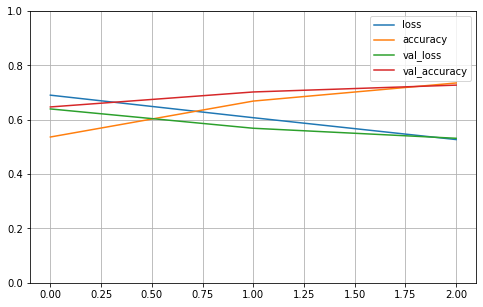

Train set ones/size 4806 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 527 / 1034
Range of scores: 0.0036076012 to 0.9960651
Score threshold 0.5
Prediction set ones/size 499 / 1034


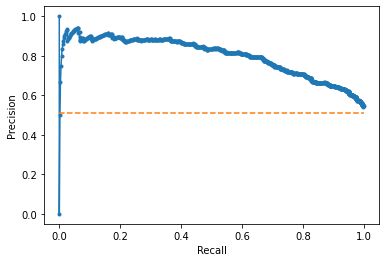

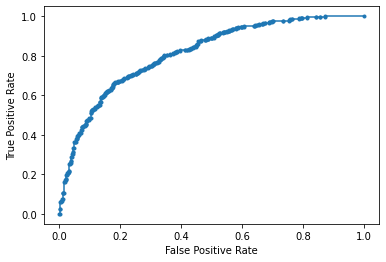

Accuracy: 72.73% Precision: 74.55% Recall: 70.59%
F1: 72.51% AUPRC: 79.98% AUROC: 81.26%
2023-02-07 00:45:34.734140
Fold 8
RCI threshold derived from training set: -0.9442116707889081
FIT
2023-02-07 00:45:39.022180
PREDICT
2023-02-07 00:45:48.884838


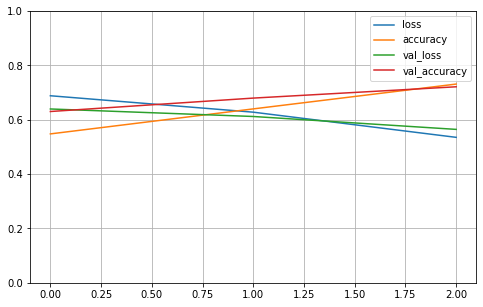

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 517 / 1033
Range of scores: 0.003623937 to 0.9862744
Score threshold 0.5
Prediction set ones/size 591 / 1033


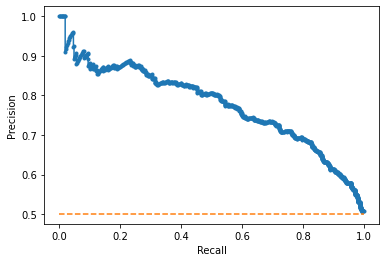

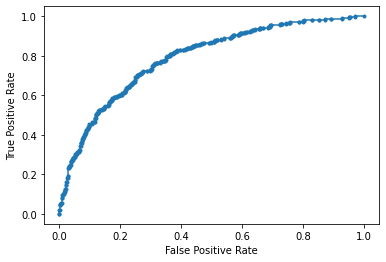

Accuracy: 72.12% Precision: 69.37% Recall: 79.30%
F1: 74.01% AUPRC: 77.71% AUROC: 78.88%
2023-02-07 00:45:49.965447
Fold 9
RCI threshold derived from training set: -0.9603716917605332
FIT
2023-02-07 00:45:54.071577
PREDICT
2023-02-07 00:46:04.821644


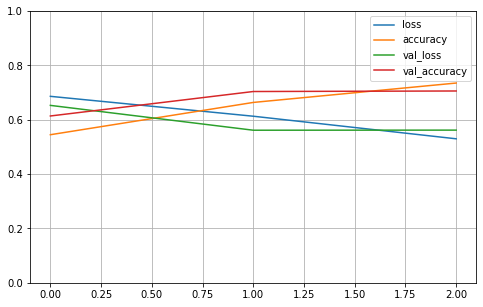

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 534 / 1033
Range of scores: 0.0073285066 to 0.97938067
Score threshold 0.5
Prediction set ones/size 380 / 1033


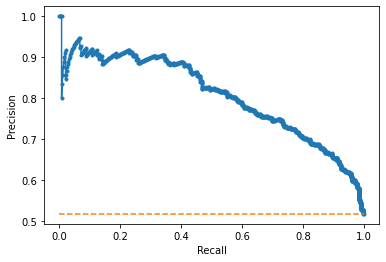

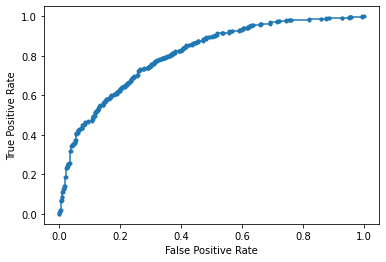

Accuracy: 70.57% Precision: 80.26% Recall: 57.12%
F1: 66.74% AUPRC: 80.59% AUROC: 80.72%
2023-02-07 00:46:05.589484
Fold 10
RCI threshold derived from training set: -0.9432120966089854
FIT
2023-02-07 00:46:09.673313
PREDICT
2023-02-07 00:46:19.726855


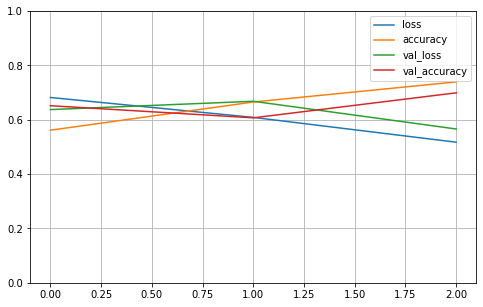

Train set ones/size 4814 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 502 / 1033
Range of scores: 0.00065461645 to 0.9819724
Score threshold 0.5
Prediction set ones/size 403 / 1033


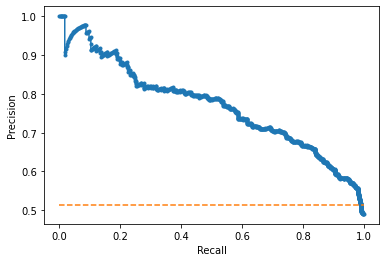

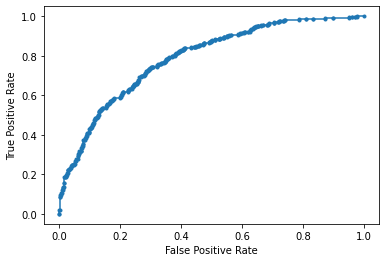

Accuracy: 69.89% Precision: 73.70% Recall: 59.16%
F1: 65.64% AUPRC: 77.08% AUROC: 78.87%
2023-02-07 00:46:20.448977

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.77% +/- 1.71
 precision mean 73.72% +/- 5.38
 recall mean 72.36% +/- 11.32
 F1 mean 72.24% +/- 3.61
 AUPRC mean 81.08% +/- 2.34
 AUROC mean 80.75% +/- 1.58
Finished cell Line 11 SK.N.SH

2023-02-07 00:46:21.908959
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-07 00:46:39.213844
splitting
Fold 1
RCI threshold derived from training set: -0.7917608026152975
FIT
2023-02-07 00:46:42.669022
PREDICT
2023-02-07 00:46:52.134792


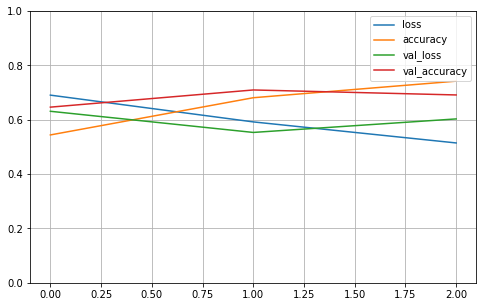

Train set ones/size 4450 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 528 / 981
Range of scores: 0.001845967 to 0.991581
Score threshold 0.5
Prediction set ones/size 281 / 981


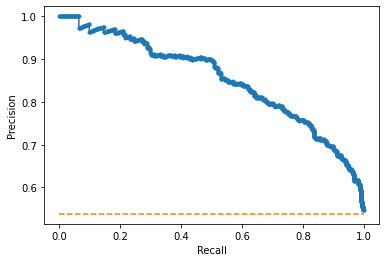

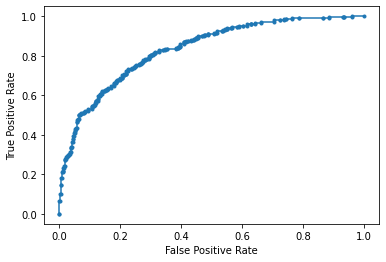

Accuracy: 69.11% Precision: 90.04% Recall: 47.92%
F1: 62.55% AUPRC: 85.26% AUROC: 83.31%
2023-02-07 00:46:52.879367
Fold 2
RCI threshold derived from training set: -0.7848096078186968
FIT
2023-02-07 00:46:58.197137
PREDICT
2023-02-07 00:47:07.415660


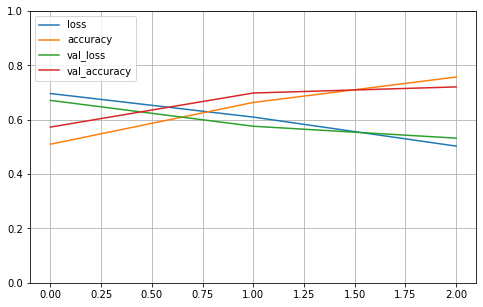

Train set ones/size 4476 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 496 / 981
Range of scores: 0.0012803406 to 0.9977392
Score threshold 0.5
Prediction set ones/size 384 / 981


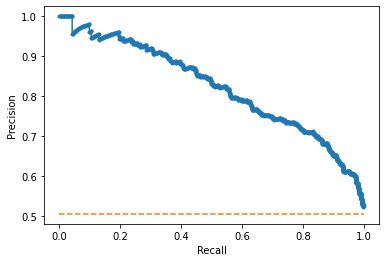

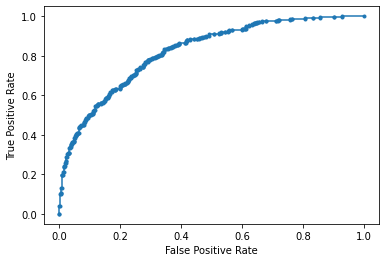

Accuracy: 72.07% Precision: 78.91% Recall: 61.09%
F1: 68.86% AUPRC: 82.38% AUROC: 82.16%
2023-02-07 00:47:08.579354
Fold 3
RCI threshold derived from training set: -0.7932426588759207
FIT
2023-02-07 00:47:14.335850
PREDICT
2023-02-07 00:47:23.629217


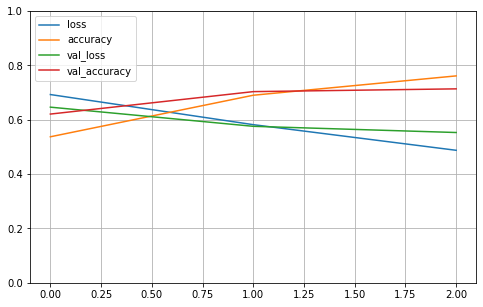

Train set ones/size 4464 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 514 / 981
Range of scores: 0.0025570772 to 0.9908731
Score threshold 0.5
Prediction set ones/size 331 / 981


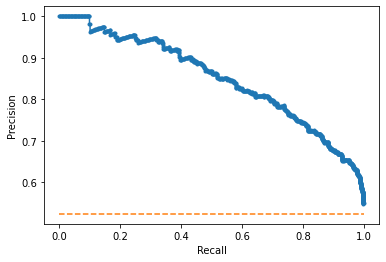

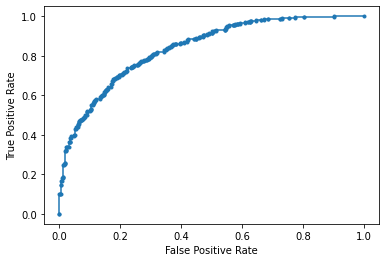

Accuracy: 71.36% Precision: 85.20% Recall: 54.86%
F1: 66.75% AUPRC: 85.05% AUROC: 83.88%
2023-02-07 00:47:24.788502
Fold 4
RCI threshold derived from training set: -0.7787853194719547
FIT
2023-02-07 00:47:28.901166
PREDICT
2023-02-07 00:47:38.416001


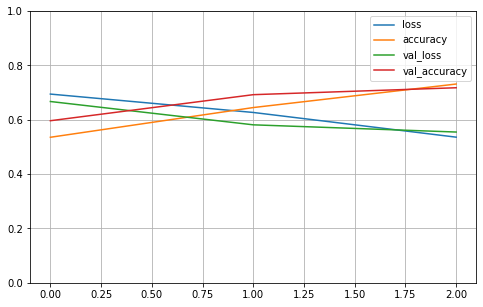

Train set ones/size 4487 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 475 / 981
Range of scores: 0.007929628 to 0.99193466
Score threshold 0.5
Prediction set ones/size 320 / 981


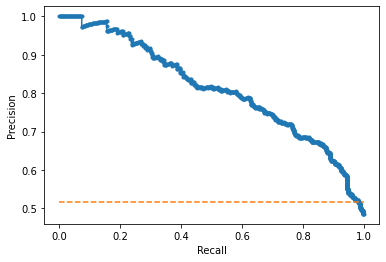

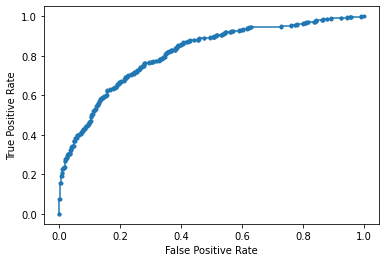

Accuracy: 71.76% Precision: 80.94% Recall: 54.53%
F1: 65.16% AUPRC: 81.19% AUROC: 81.27%
2023-02-07 00:47:39.590083
Fold 5
RCI threshold derived from training set: -0.7845497024022663
FIT
2023-02-07 00:47:43.567336
PREDICT
2023-02-07 00:47:53.800063


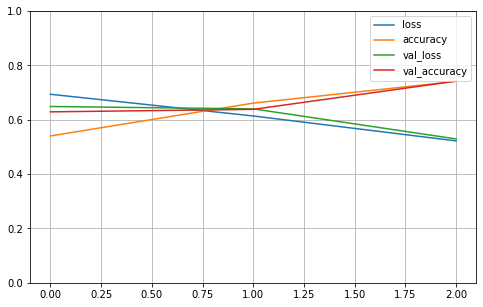

Train set ones/size 4472 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 500 / 981
Range of scores: 0.0041063824 to 0.99737036
Score threshold 0.5
Prediction set ones/size 397 / 981


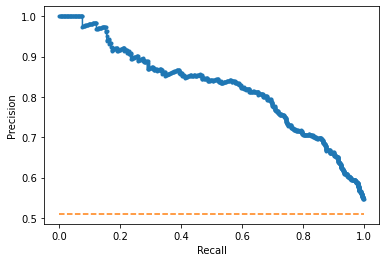

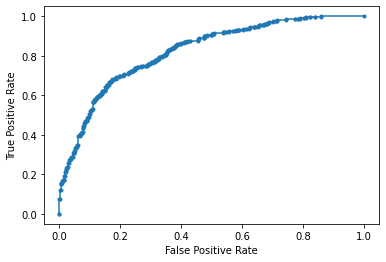

Accuracy: 74.21% Precision: 81.11% Recall: 64.40%
F1: 71.79% AUPRC: 82.42% AUROC: 82.27%
2023-02-07 00:47:54.608222
Fold 6
RCI threshold derived from training set: -0.791977157883286
FIT
2023-02-07 00:47:58.558341
PREDICT
2023-02-07 00:48:08.349806


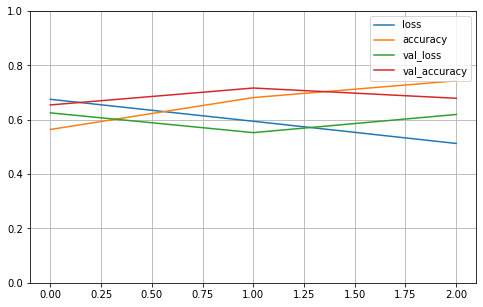

Train set ones/size 4463 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 515 / 981
Range of scores: 0.0047787176 to 0.99003744
Score threshold 0.5
Prediction set ones/size 258 / 981


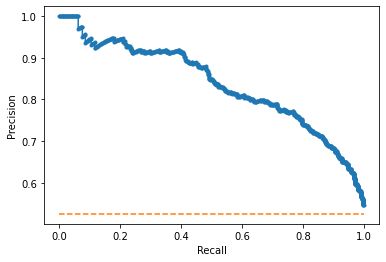

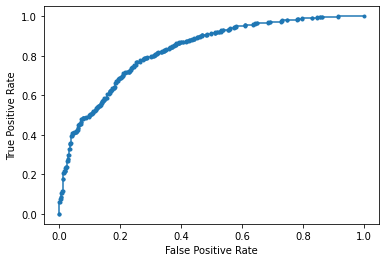

Accuracy: 67.89% Precision: 88.76% Recall: 44.47%
F1: 59.25% AUPRC: 83.76% AUROC: 82.93%
2023-02-07 00:48:09.072513
Fold 7
RCI threshold derived from training set: -0.7820942513777476
FIT
2023-02-07 00:48:12.994580
PREDICT
2023-02-07 00:48:24.433553


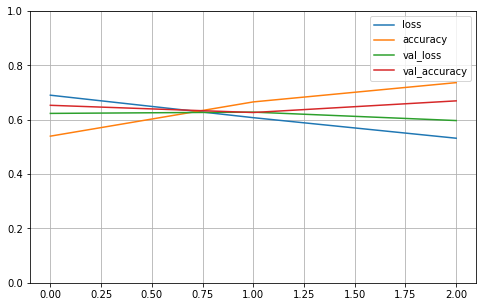

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 477 / 980
Range of scores: 0.022317018 to 0.9961843
Score threshold 0.5
Prediction set ones/size 689 / 980


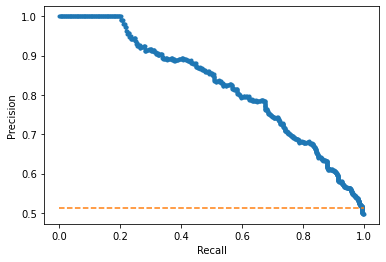

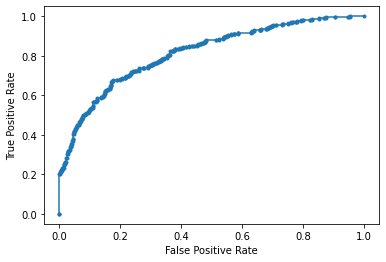

Accuracy: 66.94% Precision: 61.10% Recall: 88.26%
F1: 72.21% AUPRC: 82.36% AUROC: 81.49%
2023-02-07 00:48:25.201109
Fold 8
RCI threshold derived from training set: -0.7733633923476094
FIT
2023-02-07 00:48:29.155002
PREDICT
2023-02-07 00:48:40.831124


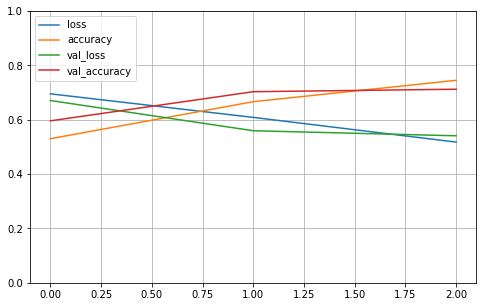

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 459 / 980
Range of scores: 0.00378355 to 0.9925816
Score threshold 0.5
Prediction set ones/size 343 / 980


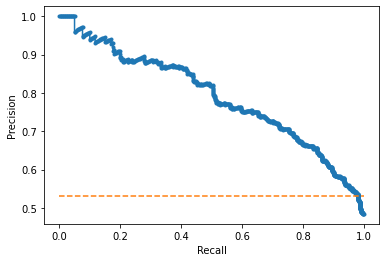

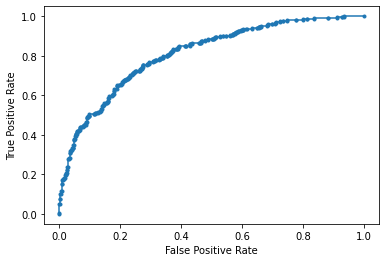

Accuracy: 71.22% Precision: 75.80% Recall: 56.64%
F1: 64.84% AUPRC: 79.11% AUROC: 80.97%
2023-02-07 00:48:41.603400
Fold 9
RCI threshold derived from training set: -0.7889935849399501
FIT
2023-02-07 00:48:47.000345
PREDICT
2023-02-07 00:48:56.471599


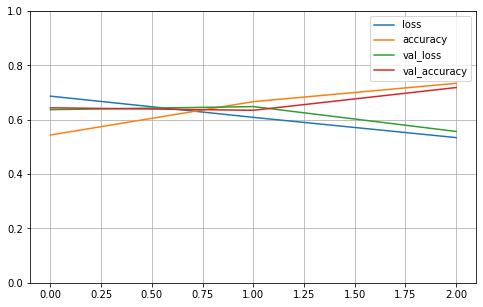

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 502 / 980
Range of scores: 0.014045735 to 0.99337184
Score threshold 0.5
Prediction set ones/size 634 / 980


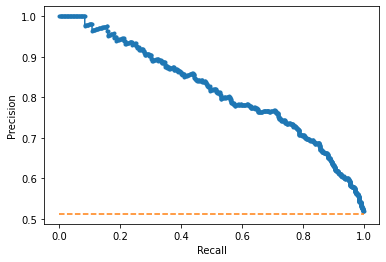

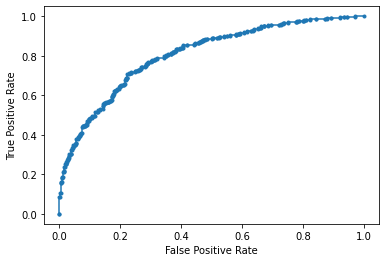

Accuracy: 71.84% Precision: 67.82% Recall: 85.66%
F1: 75.70% AUPRC: 81.80% AUROC: 80.63%
2023-02-07 00:48:57.754459
Fold 10
RCI threshold derived from training set: -0.7912181729707681
FIT
2023-02-07 00:49:03.173240
PREDICT
2023-02-07 00:49:14.586436


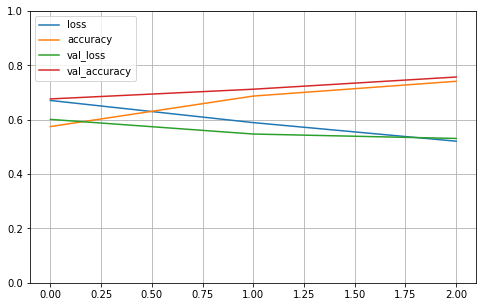

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 506 / 980
Range of scores: 0.0116177015 to 0.9947753
Score threshold 0.5
Prediction set ones/size 422 / 980


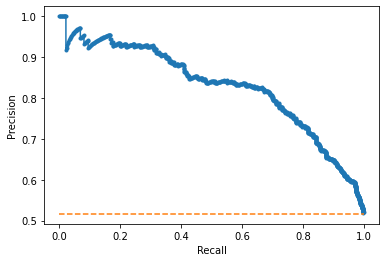

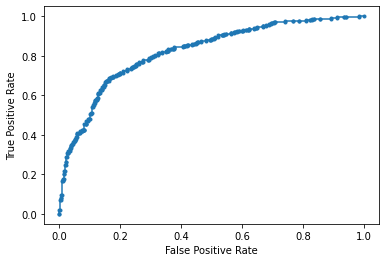

Accuracy: 75.71% Precision: 81.75% Recall: 68.18%
F1: 74.35% AUPRC: 82.91% AUROC: 82.22%
2023-02-07 00:49:15.334361

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.21% +/- 2.68
 precision mean 79.14% +/- 8.98
 recall mean 62.60% +/- 14.65
 F1 mean 68.15% +/- 5.36
 AUPRC mean 82.62% +/- 1.81
 AUROC mean 82.11% +/- 1.05
Finished cell Line 12 GM12878

2023-02-07 00:49:16.788242
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-07 00:49:26.452968
splitting
Fold 1
RCI threshold derived from training set: -0.6713087291342756
FIT
2023-02-07 00:49:28.887627
PREDICT
2023-02-07 00:49:35.681579


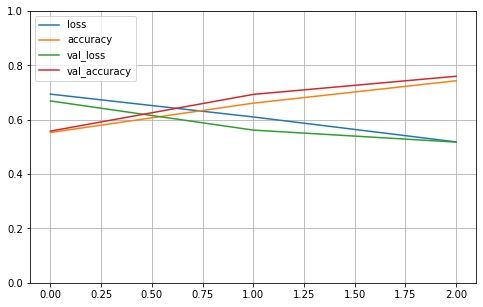

Train set ones/size 3179 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 339 / 629
Range of scores: 0.0070992145 to 0.98803884
Score threshold 0.5
Prediction set ones/size 336 / 629


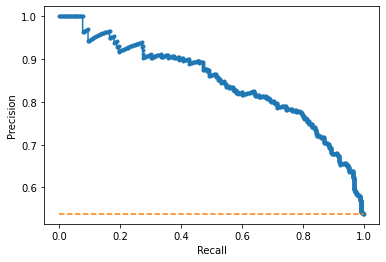

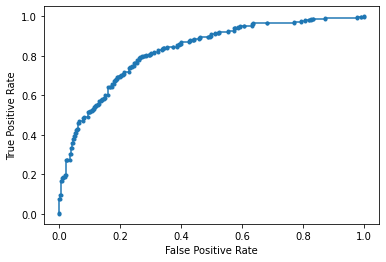

Accuracy: 75.99% Precision: 77.98% Recall: 77.29%
F1: 77.63% AUPRC: 84.55% AUROC: 82.74%
2023-02-07 00:49:36.377020
Fold 2
RCI threshold derived from training set: -0.6737843573215548
FIT
2023-02-07 00:49:40.404833
PREDICT
2023-02-07 00:49:46.861785


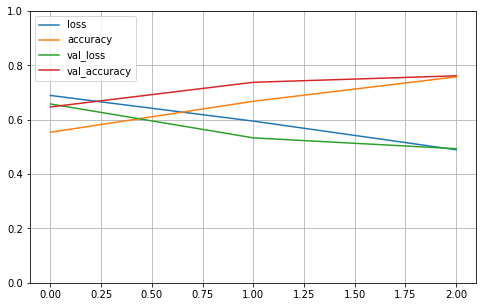

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.0055638296 to 0.9984402
Score threshold 0.5
Prediction set ones/size 376 / 629


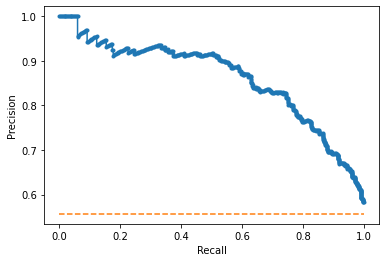

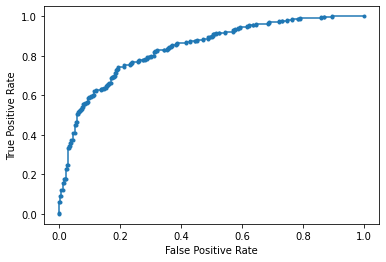

Accuracy: 76.15% Precision: 76.60% Recall: 82.29%
F1: 79.34% AUPRC: 86.17% AUROC: 83.80%
2023-02-07 00:49:47.550436
Fold 3
RCI threshold derived from training set: -0.6784838250318022
FIT
2023-02-07 00:49:50.532699
PREDICT
2023-02-07 00:50:01.789352


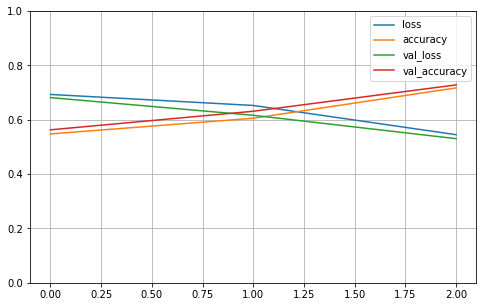

Train set ones/size 3212 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.013814268 to 0.98972404
Score threshold 0.5
Prediction set ones/size 359 / 629


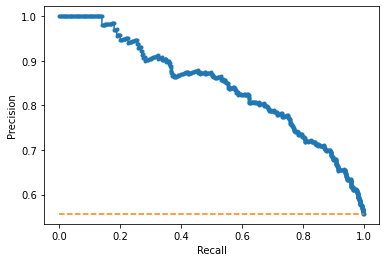

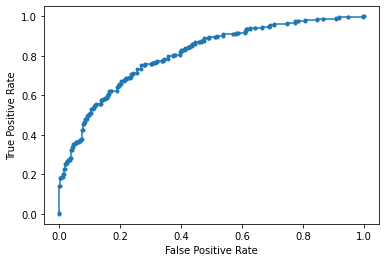

Accuracy: 72.81% Precision: 74.93% Recall: 76.86%
F1: 75.88% AUPRC: 84.41% AUROC: 80.78%
2023-02-07 00:50:02.515943
Fold 4
RCI threshold derived from training set: -0.6876066247208481
FIT
2023-02-07 00:50:06.033833
PREDICT
2023-02-07 00:50:17.553105


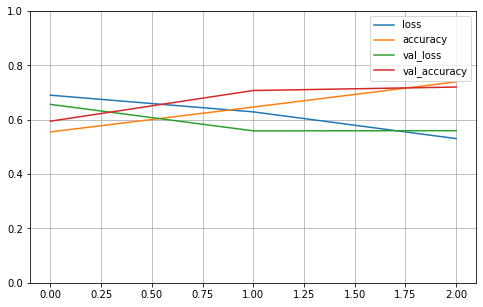

Train set ones/size 3192 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 372 / 629
Range of scores: 0.023520576 to 0.99860674
Score threshold 0.5
Prediction set ones/size 512 / 629


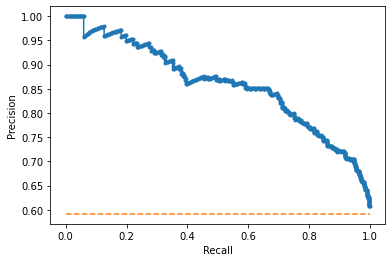

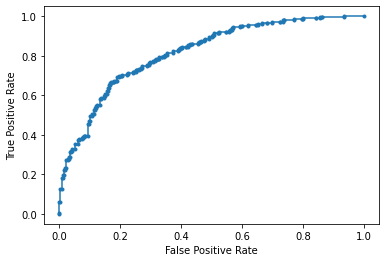

Accuracy: 72.02% Precision: 69.14% Recall: 95.16%
F1: 80.09% AUPRC: 85.98% AUROC: 81.67%
2023-02-07 00:50:18.259447
Fold 5
RCI threshold derived from training set: -0.6696898698833923
FIT
2023-02-07 00:50:21.993651
PREDICT
2023-02-07 00:50:33.189983


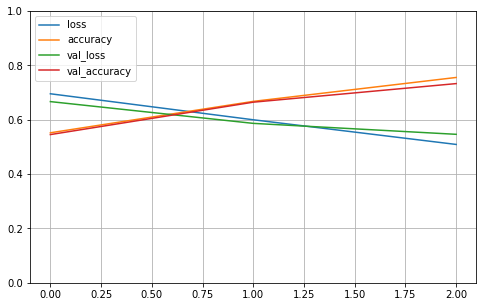

Train set ones/size 3174 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 343 / 629
Range of scores: 0.01964005 to 0.99784195
Score threshold 0.5
Prediction set ones/size 437 / 629


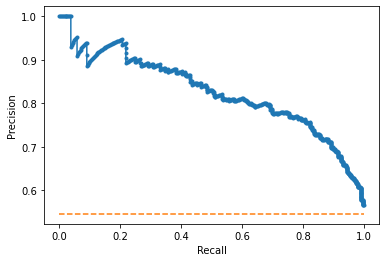

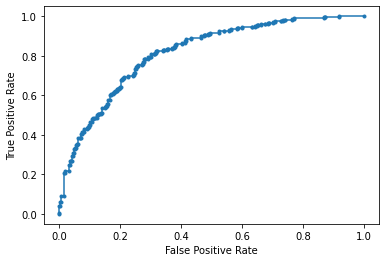

Accuracy: 73.29% Precision: 70.02% Recall: 89.21%
F1: 78.46% AUPRC: 82.64% AUROC: 81.56%
2023-02-07 00:50:33.941001
Fold 6
RCI threshold derived from training set: -0.6754036411201414
FIT
2023-02-07 00:50:36.967955
PREDICT
2023-02-07 00:50:43.345839


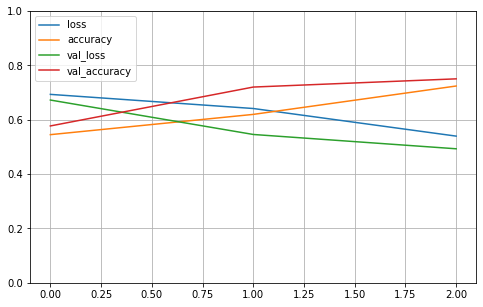

Train set ones/size 3187 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 363 / 629
Range of scores: 0.008520627 to 0.98690236
Score threshold 0.5
Prediction set ones/size 328 / 629


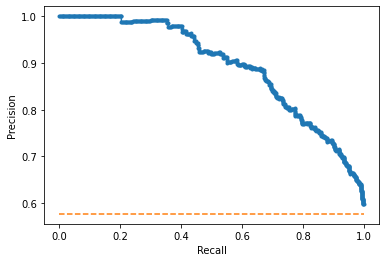

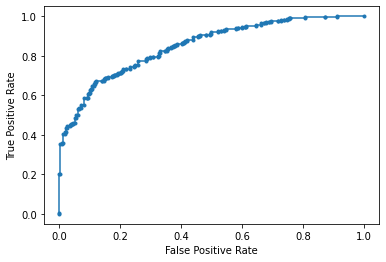

Accuracy: 75.04% Precision: 81.40% Recall: 73.55%
F1: 77.28% AUPRC: 89.46% AUROC: 84.98%
2023-02-07 00:50:44.396958
Fold 7
RCI threshold derived from training set: -0.6775167190000001
FIT
2023-02-07 00:50:49.098829
PREDICT
2023-02-07 00:50:55.543904


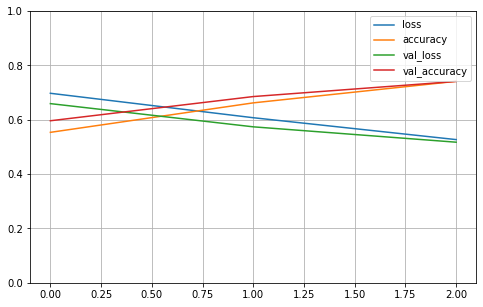

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.013433556 to 0.9954483
Score threshold 0.5
Prediction set ones/size 423 / 629


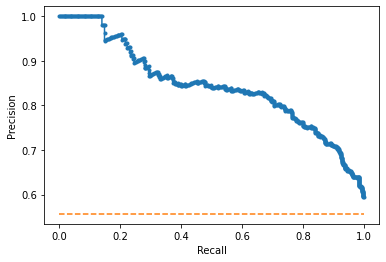

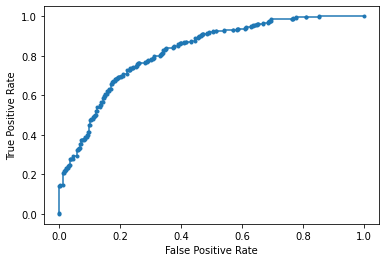

Accuracy: 74.09% Precision: 72.10% Recall: 87.14%
F1: 78.91% AUPRC: 84.39% AUROC: 82.17%
2023-02-07 00:50:56.231146
Fold 8
RCI threshold derived from training set: -0.6808395354416962
FIT
2023-02-07 00:50:59.226583
PREDICT
2023-02-07 00:51:06.150180


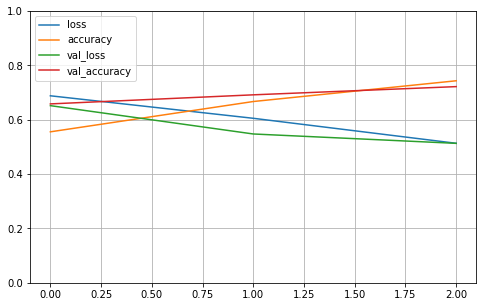

Train set ones/size 3198 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 364 / 629
Range of scores: 0.047130577 to 0.99350846
Score threshold 0.5
Prediction set ones/size 443 / 629


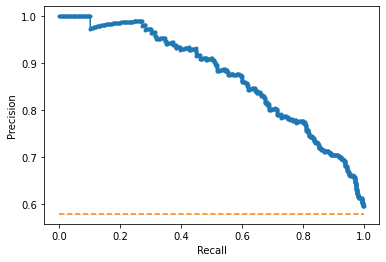

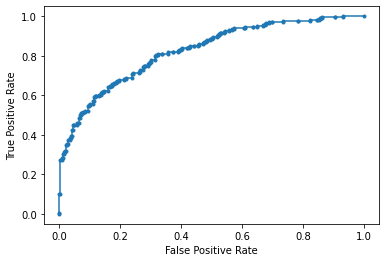

Accuracy: 72.18% Precision: 71.33% Recall: 86.81%
F1: 78.31% AUPRC: 87.35% AUROC: 82.51%
2023-02-07 00:51:06.836606
Fold 9
RCI threshold derived from training set: -0.6768322222844524
FIT
2023-02-07 00:51:09.869825
PREDICT
2023-02-07 00:51:21.203767


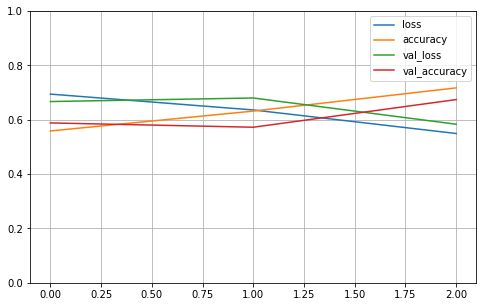

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.054974627 to 0.9971571
Score threshold 0.5
Prediction set ones/size 529 / 629


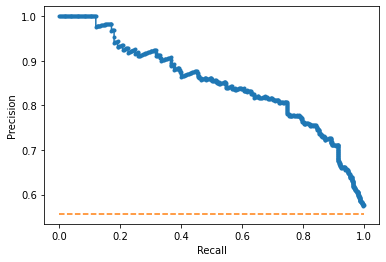

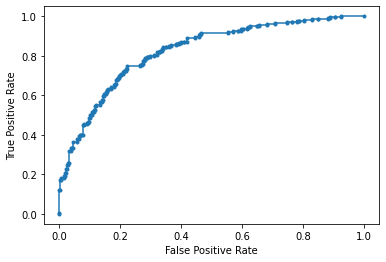

Accuracy: 67.41% Precision: 63.71% Recall: 96.29%
F1: 76.68% AUPRC: 85.11% AUROC: 82.39%
2023-02-07 00:51:22.075005
Fold 10
RCI threshold derived from training set: -0.6857367733633634
FIT
2023-02-07 00:51:25.055375
PREDICT
2023-02-07 00:51:32.092021


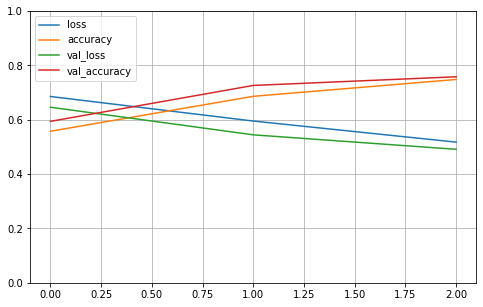

Train set ones/size 3197 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 365 / 628
Range of scores: 0.012939078 to 0.9940976
Score threshold 0.5
Prediction set ones/size 383 / 628


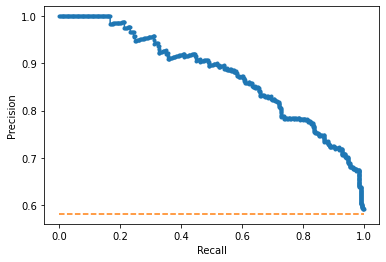

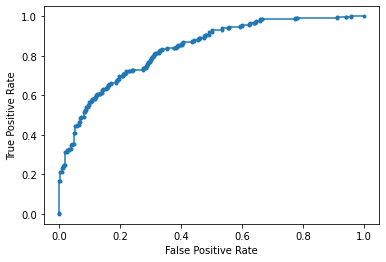

Accuracy: 75.80% Precision: 77.81% Recall: 81.64%
F1: 79.68% AUPRC: 87.64% AUROC: 83.53%
2023-02-07 00:51:32.834645

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.48% +/- 2.64
 precision mean 73.50% +/- 5.23
 recall mean 84.62% +/- 7.68
 F1 mean 78.23% +/- 1.35
 AUPRC mean 85.77% +/- 1.98
 AUROC mean 82.61% +/- 1.22
Finished cell Line 13 K562

2023-02-07 00:51:34.210654
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-07 00:51:38.068239
splitting
Fold 1
RCI threshold derived from training set: -0.7940587397297298
FIT
2023-02-07 00:51:38.873797
PREDICT
2023-02-07 00:51:42.528822


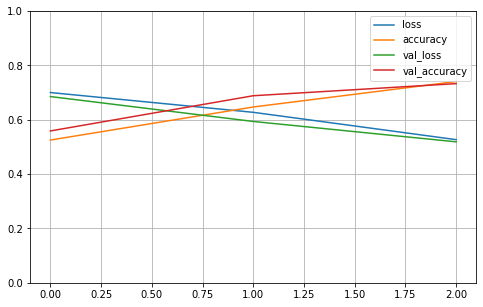

Train set ones/size 1095 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 110 / 247
Range of scores: 0.016576093 to 0.9442812
Score threshold 0.5
Prediction set ones/size 126 / 247


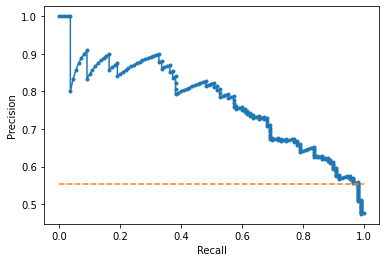

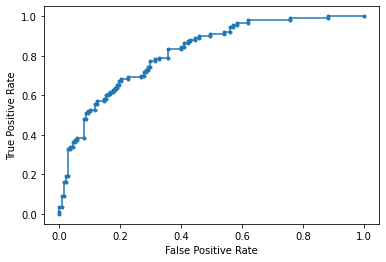

Accuracy: 73.28% Precision: 67.46% Recall: 77.27%
F1: 72.03% AUPRC: 76.98% AUROC: 81.83%
2023-02-07 00:51:43.512578
Fold 2
RCI threshold derived from training set: -0.792873576036036
FIT
2023-02-07 00:51:45.665515
PREDICT
2023-02-07 00:51:48.837478


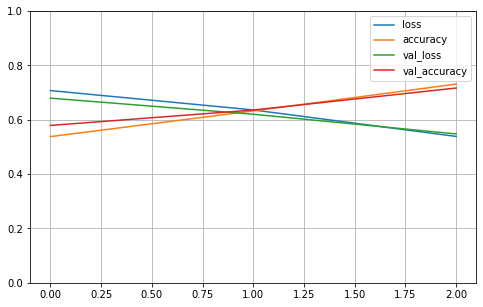

Train set ones/size 1085 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 120 / 247
Range of scores: 0.006471177 to 0.9760292
Score threshold 0.5
Prediction set ones/size 86 / 247


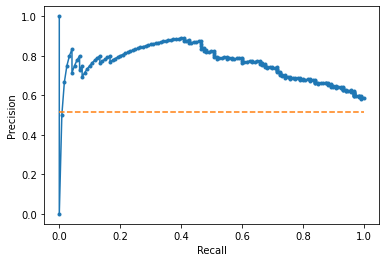

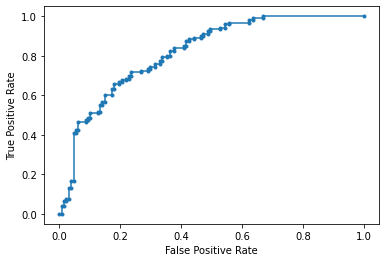

Accuracy: 71.66% Precision: 79.07% Recall: 56.67%
F1: 66.02% AUPRC: 75.78% AUROC: 81.84%
2023-02-07 00:51:49.556657
Fold 3
RCI threshold derived from training set: -0.8008805327927928
FIT
2023-02-07 00:51:51.521167
PREDICT
2023-02-07 00:51:54.637183


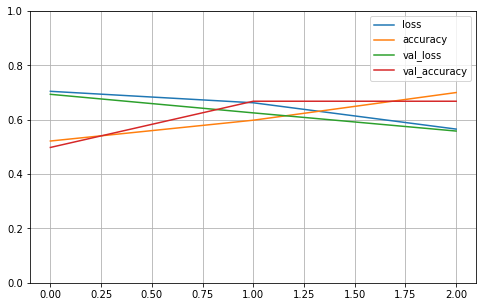

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 118 / 247
Range of scores: 0.0046377564 to 0.9261071
Score threshold 0.5
Prediction set ones/size 80 / 247


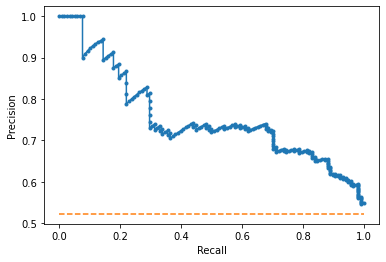

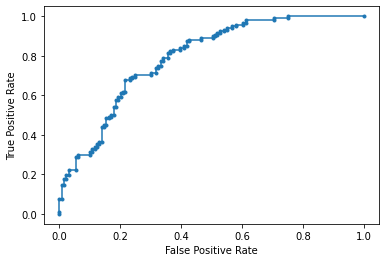

Accuracy: 66.80% Precision: 72.50% Recall: 49.15%
F1: 58.59% AUPRC: 75.51% AUROC: 79.22%
2023-02-07 00:51:55.569963
Fold 4
RCI threshold derived from training set: -0.8059054895045044
FIT
2023-02-07 00:51:58.424808
PREDICT
2023-02-07 00:52:02.202440


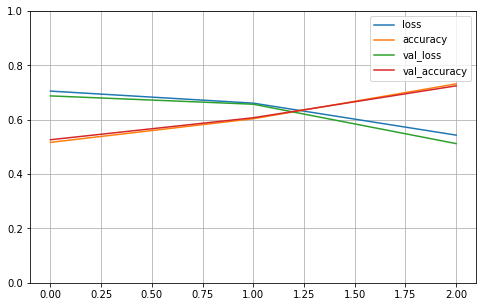

Train set ones/size 1083 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 124 / 247
Range of scores: 0.0009117342 to 0.96272045
Score threshold 0.5
Prediction set ones/size 142 / 247


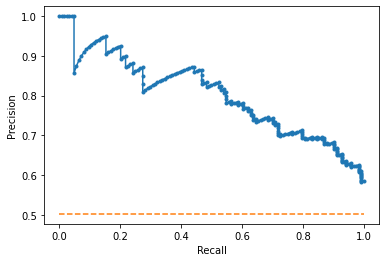

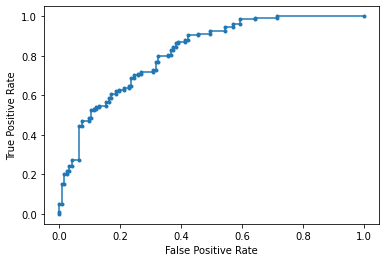

Accuracy: 72.47% Precision: 69.72% Recall: 79.84%
F1: 74.44% AUPRC: 80.15% AUROC: 81.79%
2023-02-07 00:52:02.813616
Fold 5
RCI threshold derived from training set: -0.786263587027027
FIT
2023-02-07 00:52:05.428781
PREDICT
2023-02-07 00:52:10.079754


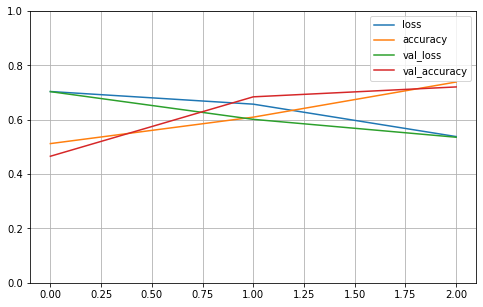

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 117 / 247
Range of scores: 0.0021445989 to 0.9442238
Score threshold 0.5
Prediction set ones/size 120 / 247


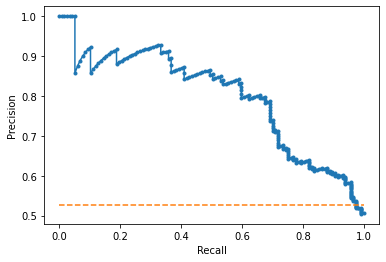

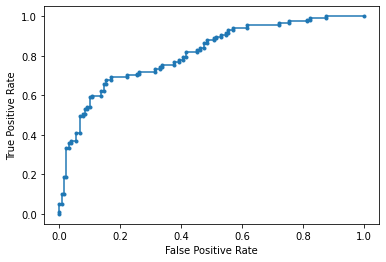

Accuracy: 72.06% Precision: 70.00% Recall: 71.79%
F1: 70.89% AUPRC: 79.79% AUROC: 81.18%
2023-02-07 00:52:12.176543
Fold 6
RCI threshold derived from training set: -0.8023878546846847
FIT
2023-02-07 00:52:14.707386
PREDICT
2023-02-07 00:52:17.748255


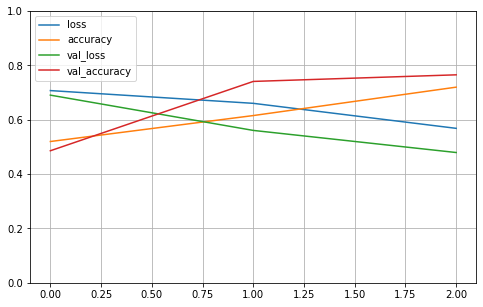

Train set ones/size 1089 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 116 / 247
Range of scores: 0.018624835 to 0.98194826
Score threshold 0.5
Prediction set ones/size 130 / 247


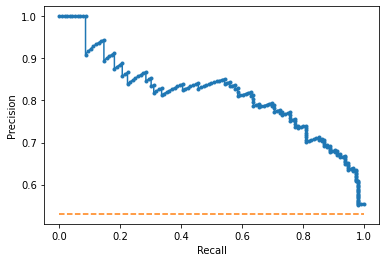

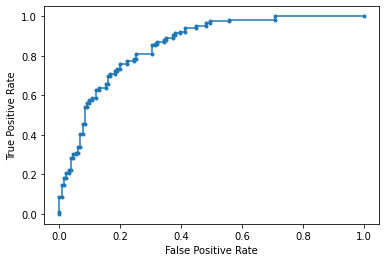

Accuracy: 76.52% Precision: 72.31% Recall: 81.03%
F1: 76.42% AUPRC: 81.57% AUROC: 85.45%
2023-02-07 00:52:18.410058
Fold 7
RCI threshold derived from training set: -0.8069793445045045
FIT
2023-02-07 00:52:20.346421
PREDICT
2023-02-07 00:52:23.649801


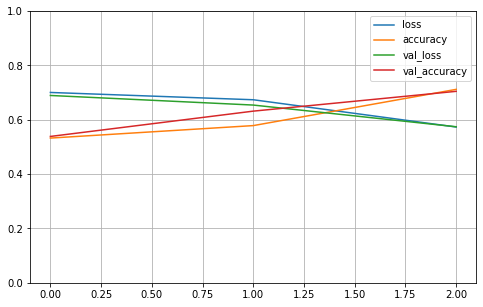

Train set ones/size 1080 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 127 / 247
Range of scores: 0.0017789733 to 0.975827
Score threshold 0.5
Prediction set ones/size 128 / 247


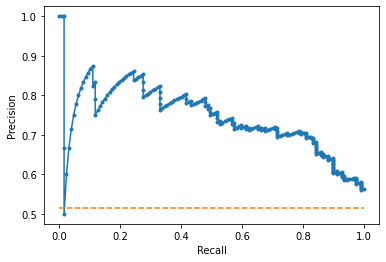

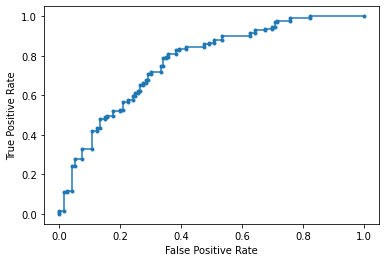

Accuracy: 70.45% Precision: 71.09% Recall: 71.65%
F1: 71.37% AUPRC: 74.25% AUROC: 76.92%
2023-02-07 00:52:24.341258
Fold 8
RCI threshold derived from training set: -0.8009138882485366
FIT
2023-02-07 00:52:26.851840
PREDICT
2023-02-07 00:52:30.233186


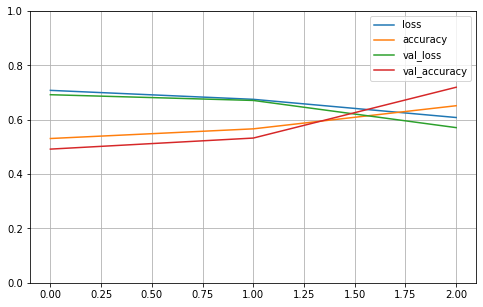

Train set ones/size 1081 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 124 / 246
Range of scores: 0.011813433 to 0.96781856
Score threshold 0.5
Prediction set ones/size 97 / 246


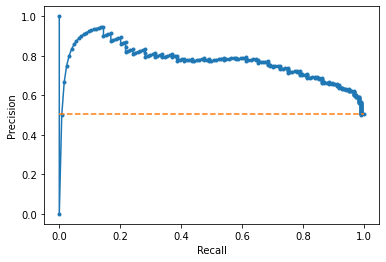

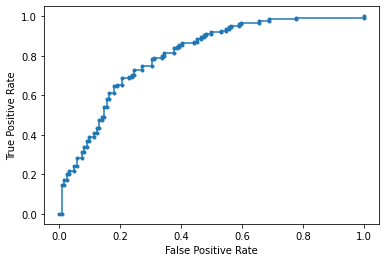

Accuracy: 71.95% Precision: 78.35% Recall: 61.29%
F1: 68.78% AUPRC: 76.84% AUROC: 80.44%
2023-02-07 00:52:30.919886
Fold 9
RCI threshold derived from training set: -0.8323262177397568
FIT
2023-02-07 00:52:33.378216
PREDICT
2023-02-07 00:52:36.625006


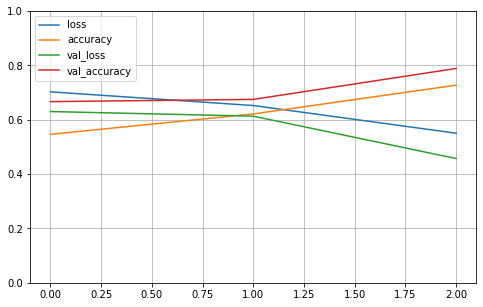

Train set ones/size 1272 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 164 / 246
Range of scores: 0.16032277 to 0.9947325
Score threshold 0.5
Prediction set ones/size 210 / 246


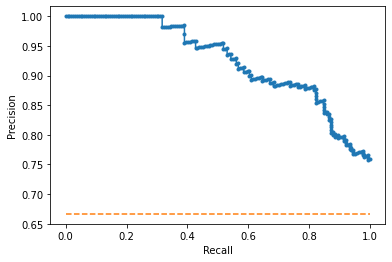

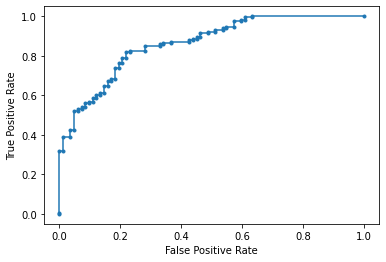

Accuracy: 78.86% Precision: 76.67% Recall: 98.17%
F1: 86.10% AUPRC: 92.58% AUROC: 86.25%
2023-02-07 00:52:37.343297
Fold 10
RCI threshold derived from training set: -0.8036815406573616
FIT
2023-02-07 00:52:39.905241
PREDICT
2023-02-07 00:52:43.349428


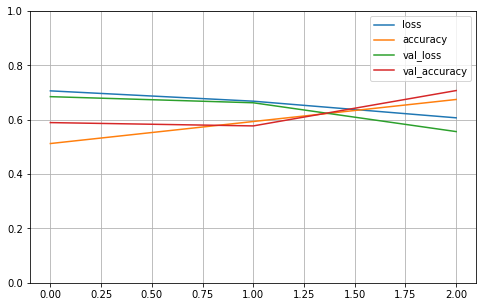

Train set ones/size 1088 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 117 / 246
Range of scores: 0.0048304554 to 0.9315551
Score threshold 0.5
Prediction set ones/size 107 / 246


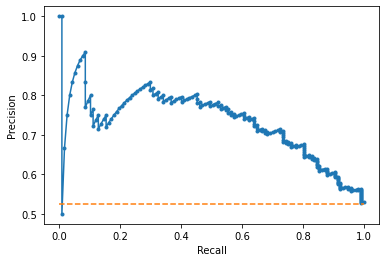

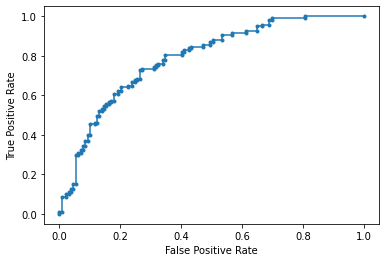

Accuracy: 70.73% Precision: 71.03% Recall: 64.96%
F1: 67.86% AUPRC: 73.18% AUROC: 78.79%
2023-02-07 00:52:43.976632

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.48% +/- 3.30
 precision mean 72.82% +/- 3.91
 recall mean 71.18% +/- 14.03
 F1 mean 71.25% +/- 7.18
 AUPRC mean 78.66% +/- 5.57
 AUROC mean 81.37% +/- 2.85
Finished cell Line 14 IMR.90

2023-02-07 00:52:45.269206


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())